Clustering GLM dropout scores from dff traces

In [7]:
import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [2]:
from sklearn.cluster import SpectralClustering

In [3]:
import visual_behavior_glm.GLM_analysis_tools as gat

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

In [5]:
from visual_behavior.dimensionality_reduction.clustering import processing
from visual_behavior.dimensionality_reduction.clustering import plotting

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


### get experiments and cells tables and limit to closest familiar and novel active

In [8]:
experiments_table = loading.get_platform_paper_experiment_table()
len(experiments_table)

1248

In [9]:
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)
print(len(experiments_table))
matched_experiments = experiments_table.index.values
cells_table = loading.get_cell_table()
print(len(cells_table.cell_specimen_id.unique()))
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

402

### get GLM output, filter and reshape

In [16]:
glm_version = '24_dff_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [17]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    
folder = '221107_clustering_dff_control'
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [18]:
features = processing.get_features_for_clustering()

In [21]:
# get GLM results from saved file in save_dir or from mongo if file doesnt exist
results_pivoted = processing.get_glm_results_pivoted_for_clustering(glm_version, model_output_type, save_dir)
results_pivoted.head()

loading results_pivoted from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_dff_all_L2_optimize_by_session\221107_clustering_dff_control\24_dff_all_L2_optimize_by_session_results_pivoted.h5


identifier  Full  all-images  behavioral      hits    image0  \
141  1003771765_1086489847   0.0   -0.012105   -0.963544 -0.083882 -0.018994   
142  1003771765_1086489860   0.0    0.000000    0.000000  0.000000  0.000000   
143  1003771765_1086489891   0.0   -0.055321   -0.552129 -0.413675  0.000000   
180  1004403369_1086489847   0.0   -0.529149   -0.468350 -0.134829 -0.421587   
181  1004403369_1086489860   0.0   -0.813781    0.000000 -0.362811  0.000000   

     image1    image2    image3    image4  ...  ophys_container_id  \
141     0.0  0.000000 -0.013553 -0.020888  ...          1000740410   
142     0.0  0.000000  0.000000  0.000000  ...          1000740410   
143     0.0 -0.087683 -0.900484  0.000000  ...          1000740410   
180     0.0 -0.182548  0.000000  0.000000  ...          1000740410   
181     0.0  0.000000  0.000000  0.000000  ...          1000740410   

             project_code  imaging_depth  targeted_structure  \
141  VisualBehaviorTask1B            175                VISp   
142  VisualBehaviorTask1B            175                VISp   
143  VisualBehaviorTask1B            175                VISp   
180  VisualBehaviorTask1B            175                VISp   
181  VisualBehaviorTask1B            175                VISp   

            date_of_acquisition      session_type  experience_level  passive  \
141  2020-01-29 16:25:58.000000  OPHYS_3_images_B          Familiar    False   
142  2020-01-29 16:25:58.000000  OPHYS_3_images_B          Familiar    False   
143  2020-01-29 16:25:58.000000  OPHYS_3_images_B          Familiar    False   
180  2020-01-31 16:32:20.000000  OPHYS_4_images_A           Novel 1    False   
181  2020-01-31 16:32:20.000000  OPHYS_4_images_A           Novel 1    False   

     image_set     file_id  
141          B  1003809811  
142          B  1003809811  
143          B  1003809811  
180          A  1004465164  
181          A  1004465164  

[5 rows x 68 columns]

In [22]:
# get dropout scores just for the features we want to cluster on
dropouts = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted)
dropouts.head()

all-images  omissions  behavioral      task  cell_specimen_id  \
141   -0.012105  -0.112785   -0.963544 -0.003805        1086489847   
142    0.000000   0.000000    0.000000  0.000000        1086489860   
143   -0.055321  -0.556917   -0.552129 -0.028019        1086489891   
180   -0.529149  -0.153512   -0.468350 -0.015944        1086489847   
181   -0.813781  -0.195218    0.000000 -0.231648        1086489860   

    experience_level  
141         Familiar  
142         Familiar  
143         Familiar  
180          Novel 1  
181          Novel 1

In [23]:
# unstack dropout scores to get a vector of features x experience levels for each cell
feature_matrix = processing.get_feature_matrix_for_clustering(dropouts, glm_version, save_dir=save_dir)
feature_matrix.head()

No duplicated cells found
3921


all-images                     omissions                      \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1   
cell_specimen_id                                                                
1086489847        -0.012105 -0.529149 -0.001467 -0.112785 -0.153512 -0.028176   
1086489860         0.000000 -0.813781  0.000000  0.000000 -0.195218  0.000000   
1086489891        -0.055321 -0.602348  0.000000 -0.556917 -0.381988  0.000000   
1086489976        -0.683818 -0.629994 -0.559606 -0.096100 -0.194190 -0.172733   
1086490002        -0.661373 -0.584163 -0.397421 -0.086036 -0.024809 -0.136702   

                 behavioral                          task                      
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                               
1086489847        -0.963544 -0.468350 -1.000000 -0.003805 -0.015944 -0.006705  
1086489860         0.000000  0.000000  0.000000  0.000000 -0.231648  0.000000  
1086489891        -0.552129 -0.176099 -1.000000 -0.028019 -0.099654 -0.030652  
1086489976        -0.044653 -0.016107 -0.026972  0.000000  0.000000  0.000000  
1086490002        -0.072155 -0.013983 -0.085174  0.000000 -0.004114 -0.050063

In [24]:
# get cell metadata for all cells in feature_matrix
cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
cell_metadata.head()

3921 cells in cell_metadata for feature_matrix


ophys_experiment_id equipment_name  \
cell_specimen_id                                       
1086551315                  794381992        CAM2P.4   
1086550804                  794381992        CAM2P.4   
1086541251                  794381992        CAM2P.4   
1086540341                  794381992        CAM2P.4   
1086539950                  794381992        CAM2P.4   

                                                      full_genotype  mouse_id  \
cell_specimen_id                                                                
1086551315        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    412366   
1086550804        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    412366   
1086541251        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    412366   
1086540341        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    412366   
1086539950        Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    412366   

                       reporter_line                      driver_line sex  \
cell_specimen_id                                                            
1086551315        Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   
1086550804        Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   
1086541251        Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   
1086540341        Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   
1086539950        Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F   

                  age_in_days           cre_line indicator  ...  layer  \
cell_specimen_id                                            ...          
1086551315              149.0  Slc17a7-IRES2-Cre   GCaMP6f  ...  lower   
1086550804              149.0  Slc17a7-IRES2-Cre   GCaMP6f  ...  lower   
1086541251              149.0  Slc17a7-IRES2-Cre   GCaMP6f  ...  lower   
1086540341              149.0  Slc17a7-IRES2-Cre   GCaMP6f  ...  lower   
1086539950              149.0  Slc17a7-IRES2-Cre   GCaMP6f  ...  lower   

                  area_layer      date  first_novel  \
cell_specimen_id                                      
1086551315        VISp_lower  20181212        False   
1086550804        VISp_lower  20181212        False   
1086541251        VISp_lower  20181212        False   
1086540341        VISp_lower  20181212        False   
1086539950        VISp_lower  20181212        False   

                  n_relative_to_first_novel  last_familiar  \
cell_specimen_id                                             
1086551315                             -1.0           True   
1086550804                             -1.0           True   
1086541251                             -1.0           True   
1086540341                             -1.0           True   
1086539950                             -1.0           True   

                  last_familiar_active second_novel  second_novel_active  \
cell_specimen_id                                                           
1086551315                        True        False                False   
1086550804                        True        False                False   
1086541251                        True        False                False   
1086540341                        True        False                False   
1086539950                        True        False                False   

                 experience_exposure  
cell_specimen_id                      
1086551315                Familiar 3  
1086550804                Familiar 3  
1086541251                Familiar 3  
1086540341                Familiar 3  
1086539950                Familiar 3  

[5 rows x 41 columns]

### plot feature matrix for each cre line

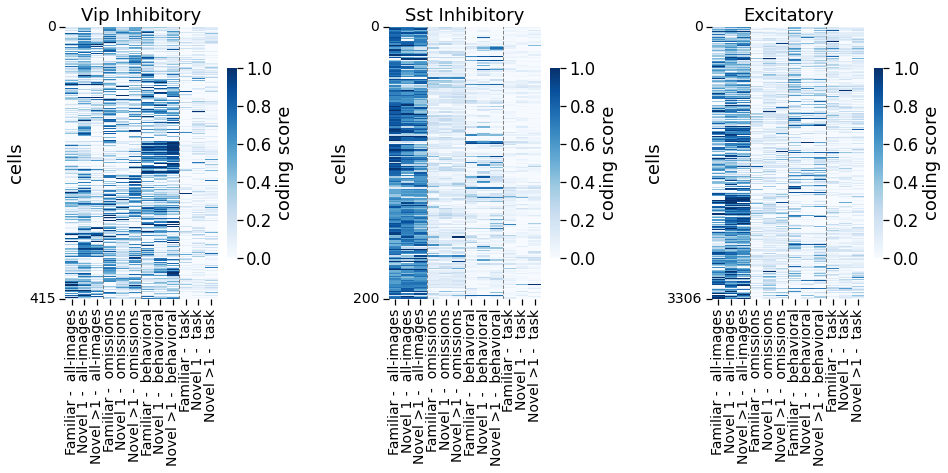

In [87]:
plotting.plot_feature_matrix_for_cre_lines(feature_matrix, cell_metadata, save_dir=base_dir, folder=folder)

### select  number of clusters

In [49]:
n_clusters_cre = {'Slc17a7-IRES2-Cre': 10,
                 'Sst-IRES-Cre': 5, 
                 'Vip-IRES-Cre':10}

### get coclustering matrices per cre line

cell_specimen_id
1086551315    Slc17a7-IRES2-Cre
1086550804    Slc17a7-IRES2-Cre
1086541251    Slc17a7-IRES2-Cre
1086540341    Slc17a7-IRES2-Cre
1086539950    Slc17a7-IRES2-Cre
                    ...        
1120113340    Slc17a7-IRES2-Cre
1120112555    Slc17a7-IRES2-Cre
1120111975    Slc17a7-IRES2-Cre
1120111711    Slc17a7-IRES2-Cre
1120111106    Slc17a7-IRES2-Cre
Name: cre_line, Length: 3921, dtype: object

In [41]:
from sklearn.cluster import SpectralClustering
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [42]:
cre_dfs = {}
eigenvalues_cre = {}
for cre_line in cre_lines:
    cre_ids = cell_metadata[cell_metadata.cre_line==cre_line].index.values
    cre_dfs[cre_line] = feature_matrix.loc[cre_ids]
    sc = SpectralClustering(n_clusters=2).fit(cre_dfs[cre_line])
    A = sc.affinity_matrix_
    eigenvalues, eigenvectors, nb_clusters = vba_clust.get_eigenDecomposition(A, max_n_clusters=25)
    eigenvalues_cre[cre_line] = eigenvalues
    

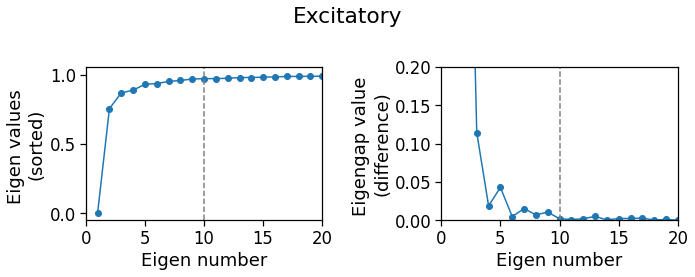

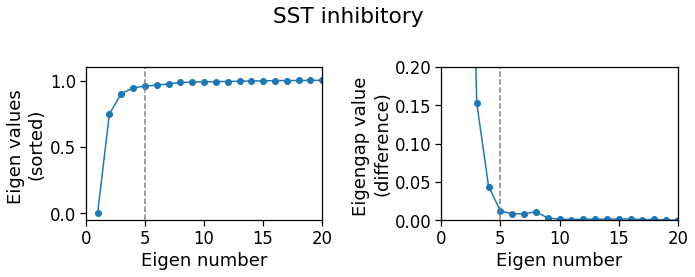

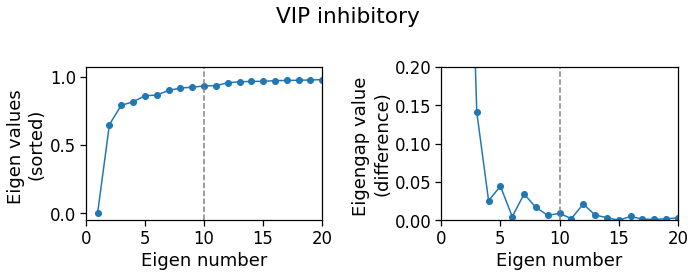

In [50]:
vba_clust.plot_eigengap_values(eigenvalues_cre, cre_lines, n_clusters_cre=n_clusters_cre,
                     save_dir=save_dir, folder='optimal_k')


In [53]:
coclustering_matrices = vba_clust.get_coclustering_matrix(glm_version, feature_matrix, cell_metadata, n_clusters_cre, save_dir, nboot=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.84s/it]


### get cluster labels per cre line from Agglomerative clustering on co-clustering matrix

In [58]:
cluster_labels = processing.get_cluster_labels(coclustering_matrices, cell_metadata, n_clusters_cre, save_dir, load=False)
cluster_labels.head()

generating cluster labels from coclustering matrix
saving cluster_labels to \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_dff_all_L2_optimize_by_session\221107_clustering_dff_control\cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5


labels  cell_specimen_id      cre_line  cluster_id
0       4        1086492406  Vip-IRES-Cre           3
1       8        1086492307  Vip-IRES-Cre           1
2       8        1086492221  Vip-IRES-Cre           1
3       8        1086492174  Vip-IRES-Cre           1
4       3        1086491936  Vip-IRES-Cre           8

#### merge cluster labels with cell metadata, remove small clusters, and add manual sort order

In [60]:
cluster_meta = processing.get_cluster_meta(cluster_labels, cell_metadata, feature_matrix, n_clusters_cre, save_dir, load=False)
cluster_meta.head()

generating cluster_meta
dropping 2 cells for ('Slc17a7-IRES2-Cre', 10)
dropping 3 cells for ('Sst-IRES-Cre', 5)
5 cells dropped total
adding within cluster correlation to cluster_meta


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


saving cluster_meta to \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_dff_all_L2_optimize_by_session\221107_clustering_dff_control\cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['equipment_name', 'full_genotype', 'reporter_line', 'driver_line',
       'sex', 'cre_line', 'indicator', 'project_code', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'cell_type', 'depth', 'binned_depth', 'area_depth',
       'area_binned_depth', 'layer', 'area_layer', 'last_familiar_active',
       'second_novel_active', 'experience_exposure'],
      dtype='object')]

  encoding=encoding,


cluster_id  labels  ophys_experiment_id equipment_name  \
cell_specimen_id                                                           
1086492406                 3       4            795073741        CAM2P.4   
1086492307                 1       8            795073741        CAM2P.4   
1086492221                 1       8            795073741        CAM2P.4   
1086492174                 1       8            795073741        CAM2P.4   
1086491936                 8       3            795073741        CAM2P.4   

                                                  full_genotype  mouse_id  \
cell_specimen_id                                                            
1086492406        Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    412036   
1086492307        Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    412036   
1086492221        Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    412036   
1086492174        Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    412036   
1086491936        Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    412036   

                               reporter_line     driver_line sex  age_in_days  \
cell_specimen_id                                                                
1086492406        Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   F        151.0   
1086492307        Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   F        151.0   
1086492221        Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   F        151.0   
1086492174        Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   F        151.0   
1086491936        Ai148(TIT2L-GC6f-ICL-tTA2)  [Vip-IRES-Cre]   F        151.0   

                  ...      date first_novel  n_relative_to_first_novel  \
cell_specimen_id  ...                                                    
1086492406        ...  20181213       False                       -1.0   
1086492307        ...  20181213       False                       -1.0   
1086492221        ...  20181213       False                       -1.0   
1086492174        ...  20181213       False                       -1.0   
1086491936        ...  20181213       False                       -1.0   

                  last_familiar  last_familiar_active  second_novel  \
cell_specimen_id                                                      
1086492406                 True                  True         False   
1086492307                 True                  True         False   
1086492221                 True                  True         False   
1086492174                 True                  True         False   
1086491936                 True                  True         False   

                  second_novel_active  experience_exposure  \
cell_specimen_id                                             
1086492406                      False           Familiar 3   
1086492307                      False           Familiar 3   
1086492221                      False           Familiar 3   
1086492174                      False           Familiar 3   
1086491936                      False           Familiar 3   

                  original_cluster_id within_cluster_correlation  
cell_specimen_id                                                  
1086492406                          3                  -0.797203  
1086492307                          1                  -0.640861  
1086492221                          1                  -0.888112  
1086492174                          1                  -0.783217  
1086491936                          8                  -0.893171  

[5 rows x 45 columns]

### sort coclustering matrix by cluster ID / cluster size

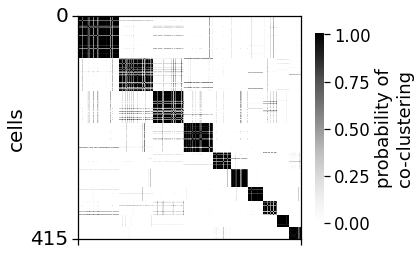

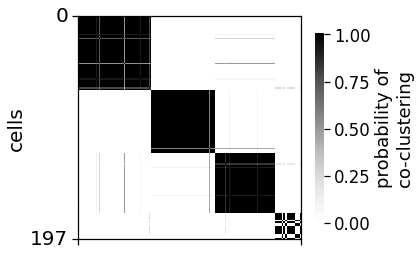

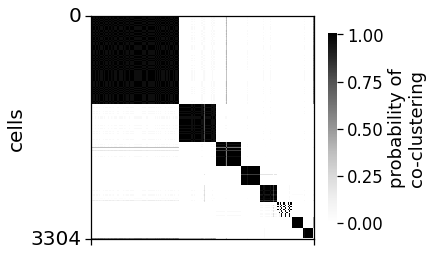

In [67]:
for cre_line in cre_lines: 
    plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_matrices, cluster_meta, cre_line, 
                                                    save_dir=save_dir, folder='', ax=None)

### plot average dropout scores for each cluster

### plot each cluster separately and save to single cell examples dir

In [68]:
cell_examples_dir = os.path.join(save_dir, 'matched_cell_examples')
if not os.path.exists(cell_examples_dir):
    os.mkdir(cell_examples_dir)

In [75]:
feature_matrix = feature_matrix.abs()

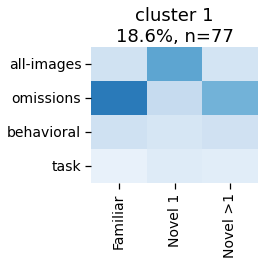

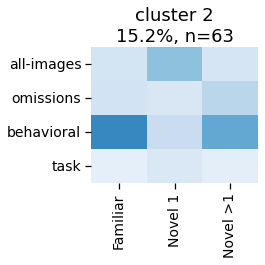

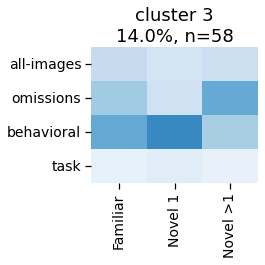

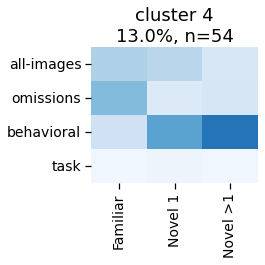

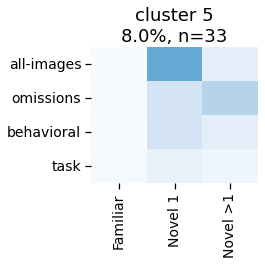

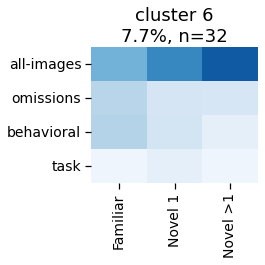

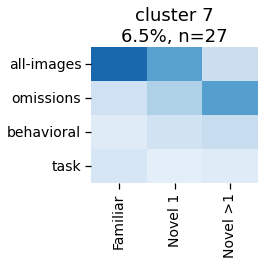

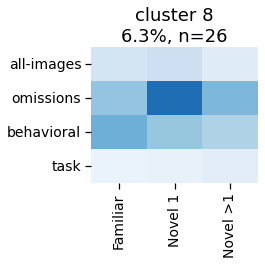

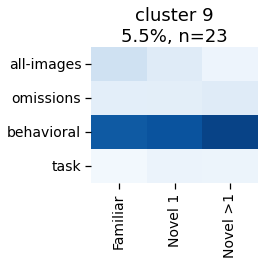

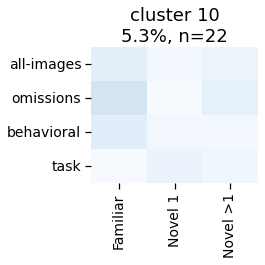

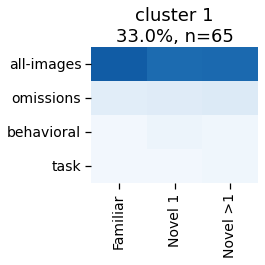

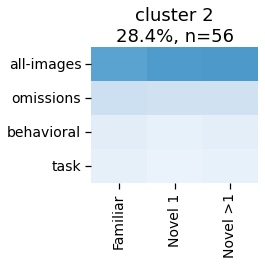

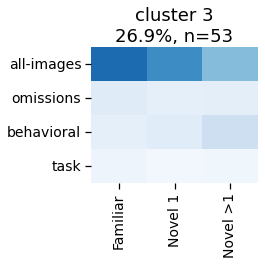

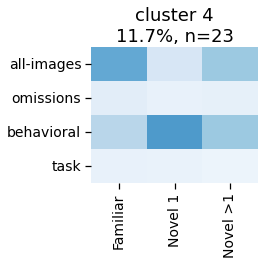

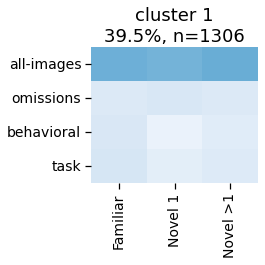

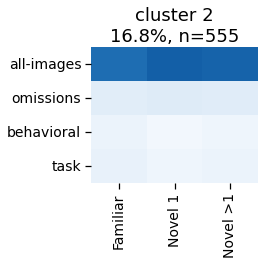

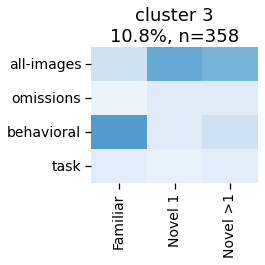

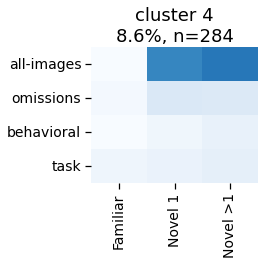

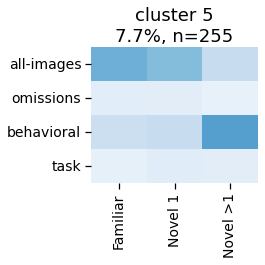

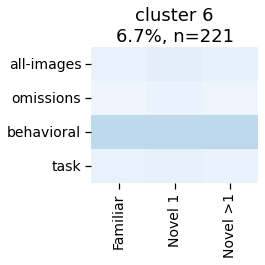

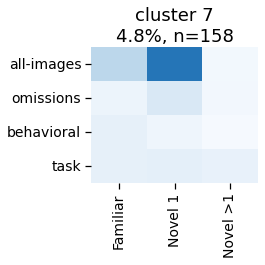

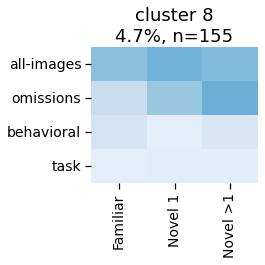

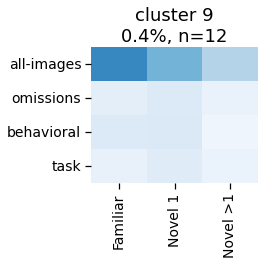

In [76]:
plotting.plot_dropout_heatmaps_and_save_to_cell_examples_folders(cluster_meta, feature_matrix, save_dir)

### plot average dropouts for each cre line in cluster size order

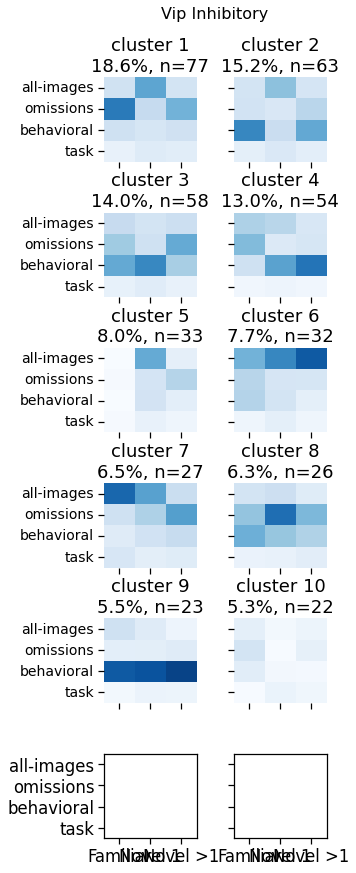

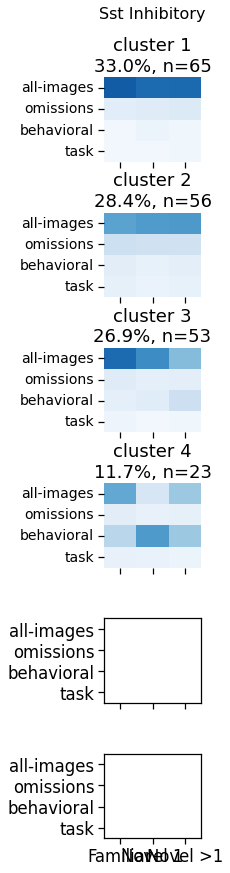

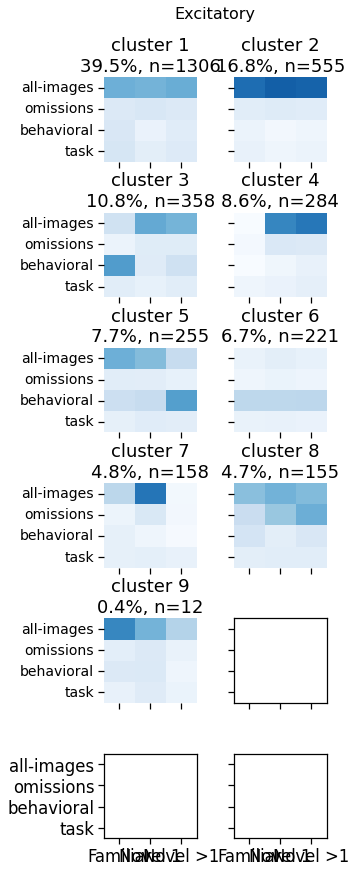

In [79]:
sort_col = 'cluster_id'

plotting.plot_dropout_heatmaps_for_clusters(cluster_meta, feature_matrix, sort_col=sort_col, save_dir=base_dir, folder=folder)

### plot dropout heatmaps in manually sorted order

### plot feature matrix sorted by cluster ID

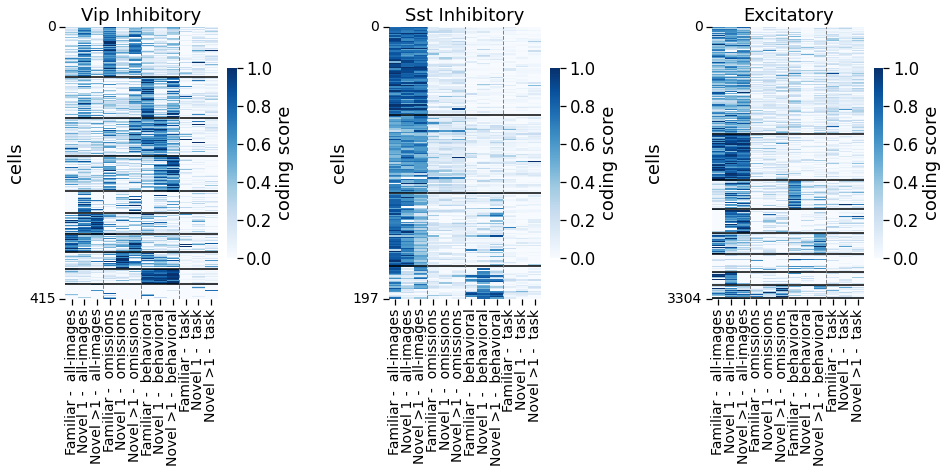

In [81]:
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='cluster_id', save_dir=save_dir, folder=folder)
    

### umap with cluster labels

AttributeError: module 'umap' has no attribute 'UMAP'

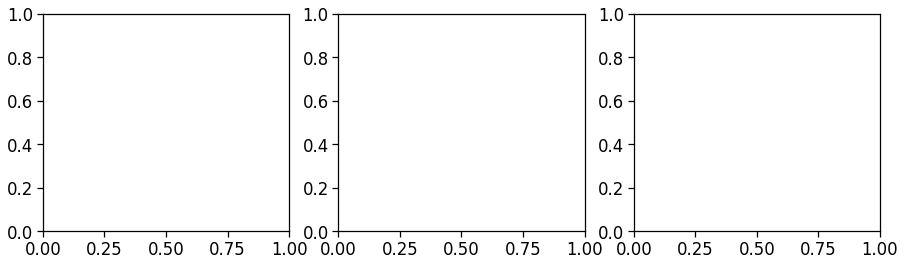

In [82]:
# for column in ['project_code', 'binned_depth', 'targeted_structure', 'mouse_id']:
label_col = 'cluster_id'

plotting.plot_umap_for_clusters(cluster_meta, feature_matrix, label_col=label_col, save_dir=base_dir, folder=folder)


### Correlations within clusters

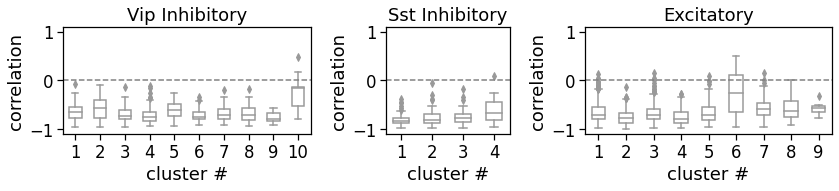

In [83]:
plotting.plot_within_cluster_correlations_all_cre(cluster_meta, n_clusters_cre, sort_order=None, save_dir=base_dir, folder=folder)

### average dropouts per cre line

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


KeyError: 'experience_level'

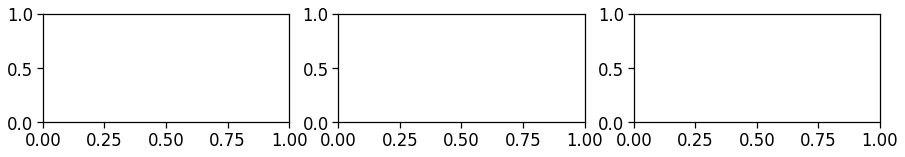

In [86]:
plotting.plot_average_dropout_heatmap_for_cre_lines(feature_matrix, cluster_meta, save_dir=save_dir, folder=folder)

### plot 100 cells per cluster to examine within cluster variability

Note: this takes a while

49 cells in cluster 2
selecting a random subset of 49
41 cells in cluster 3
selecting a random subset of 41
22 cells in cluster 9
selecting a random subset of 22
19 cells in cluster 11
selecting a random subset of 19
40 cells in cluster 5
selecting a random subset of 40
71 cells in cluster 1
selecting a random subset of 71
40 cells in cluster 4
selecting a random subset of 40
23 cells in cluster 8
selecting a random subset of 23
36 cells in cluster 7
selecting a random subset of 36
38 cells in cluster 6
selecting a random subset of 38
20 cells in cluster 10
selecting a random subset of 20
16 cells in cluster 12
selecting a random subset of 16
104 cells in cluster 1
selecting a random subset of 100
26 cells in cluster 3
selecting a random subset of 26
14 cells in cluster 5
selecting a random subset of 14
22 cells in cluster 4
selecting a random subset of 22
33 cells in cluster 2
selecting a random subset of 33
513 cells in cluster 3
selecting a random subset of 100
816 cells in cluster 

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = ax.ravel()


228 cells in cluster 5
selecting a random subset of 100
359 cells in cluster 4
selecting a random subset of 100
202 cells in cluster 8
selecting a random subset of 100
148 cells in cluster 9
selecting a random subset of 100
227 cells in cluster 6
selecting a random subset of 100


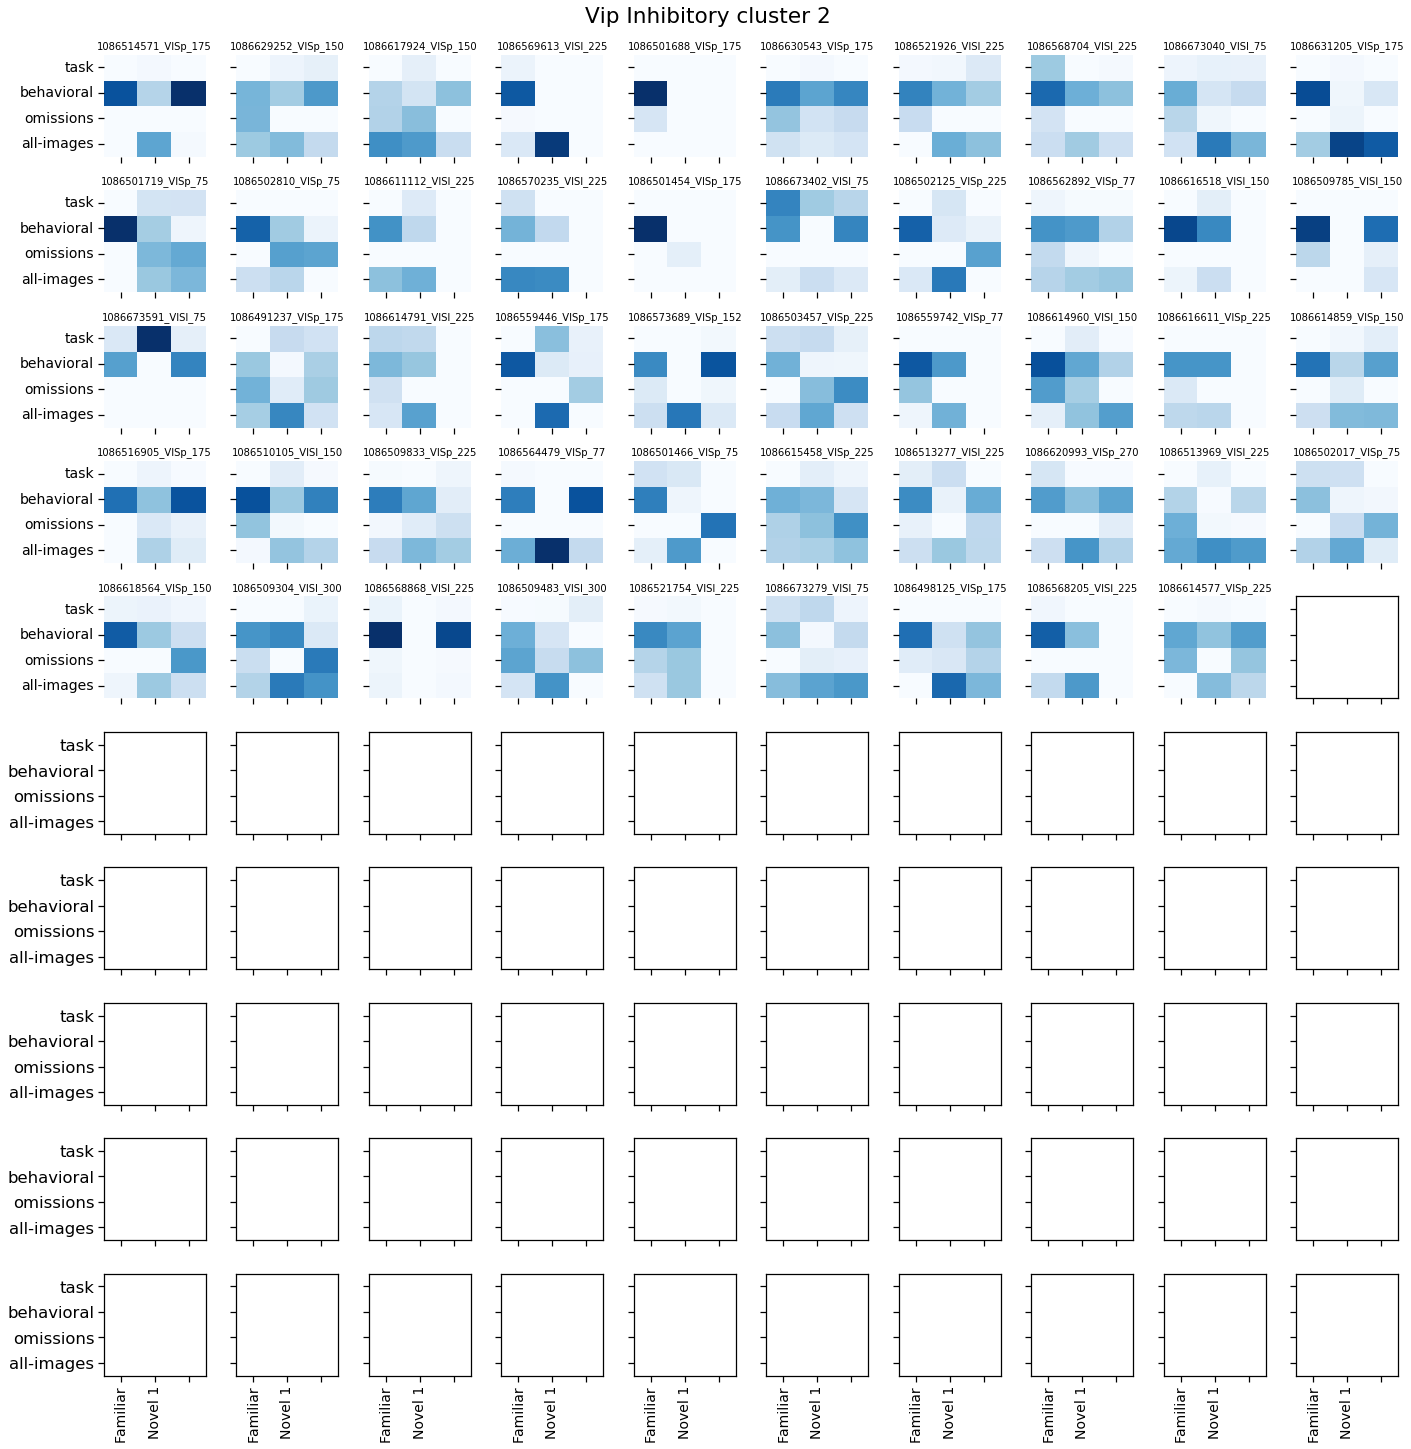

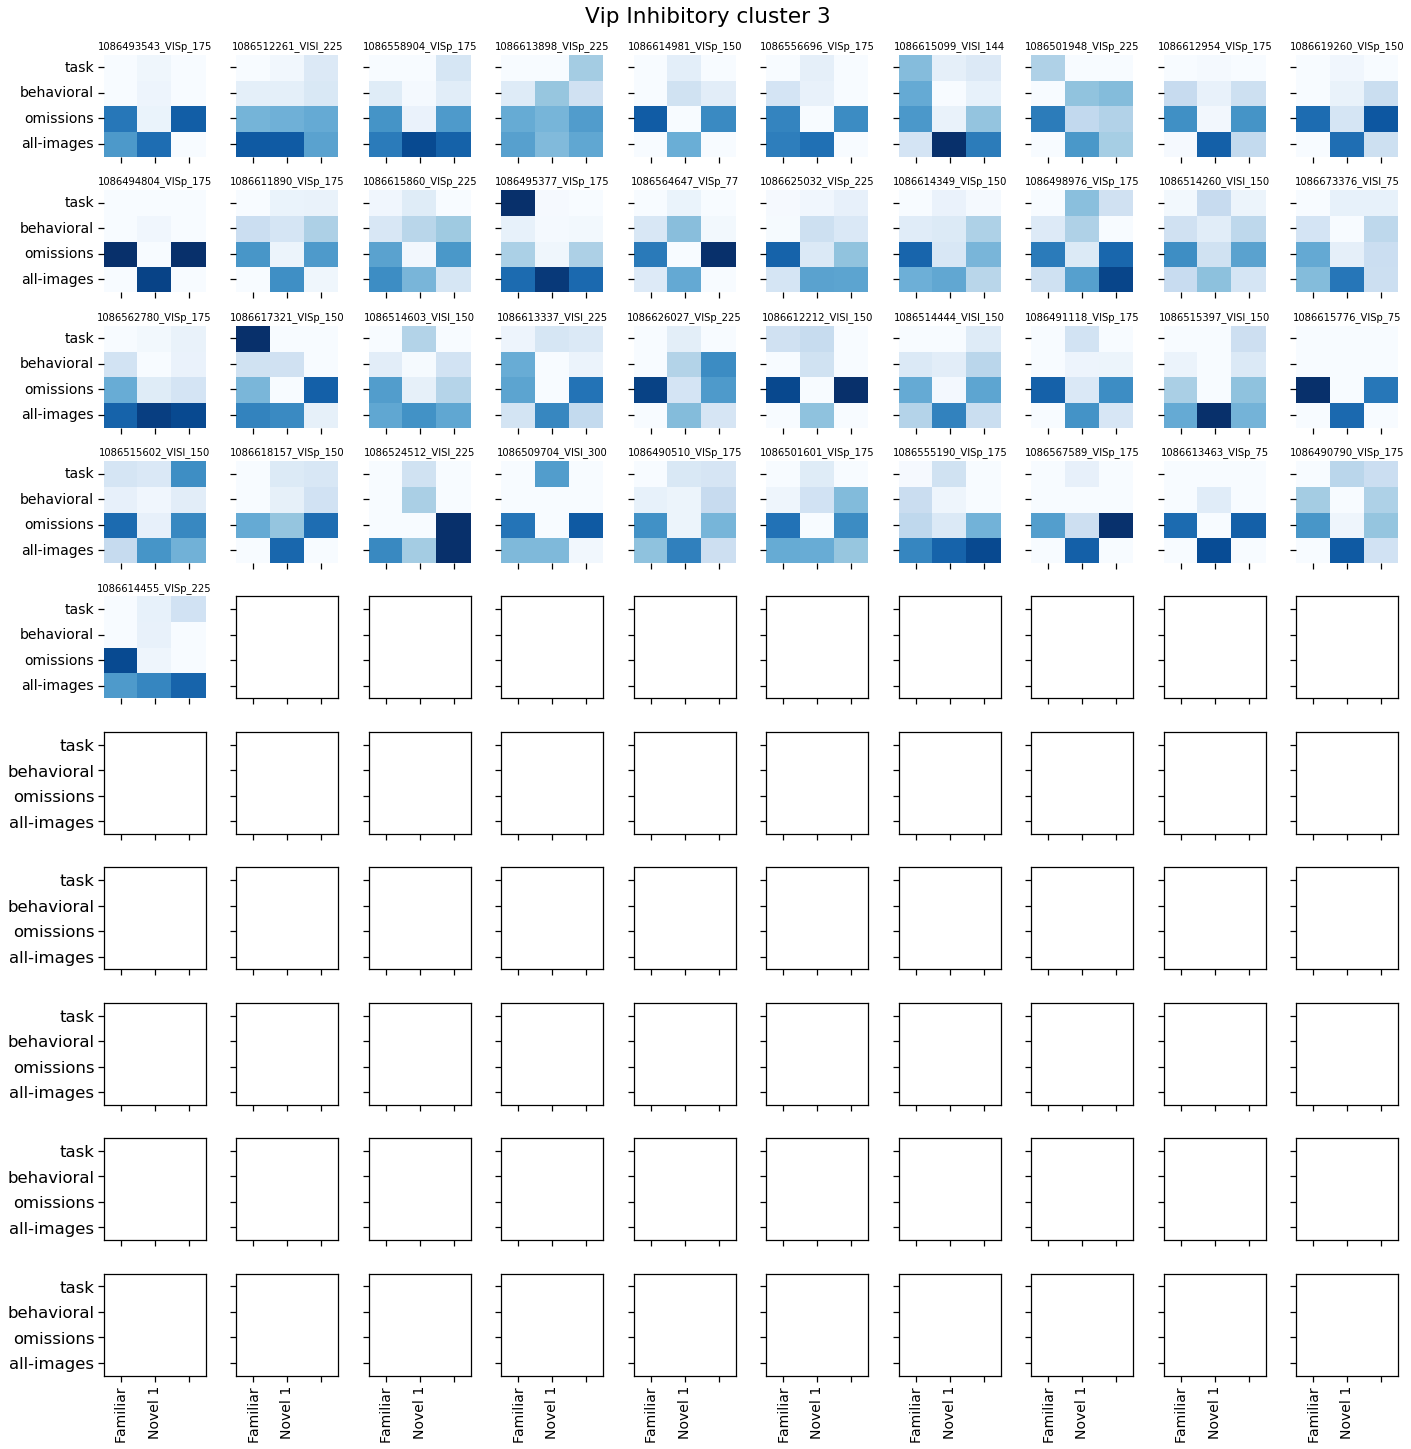

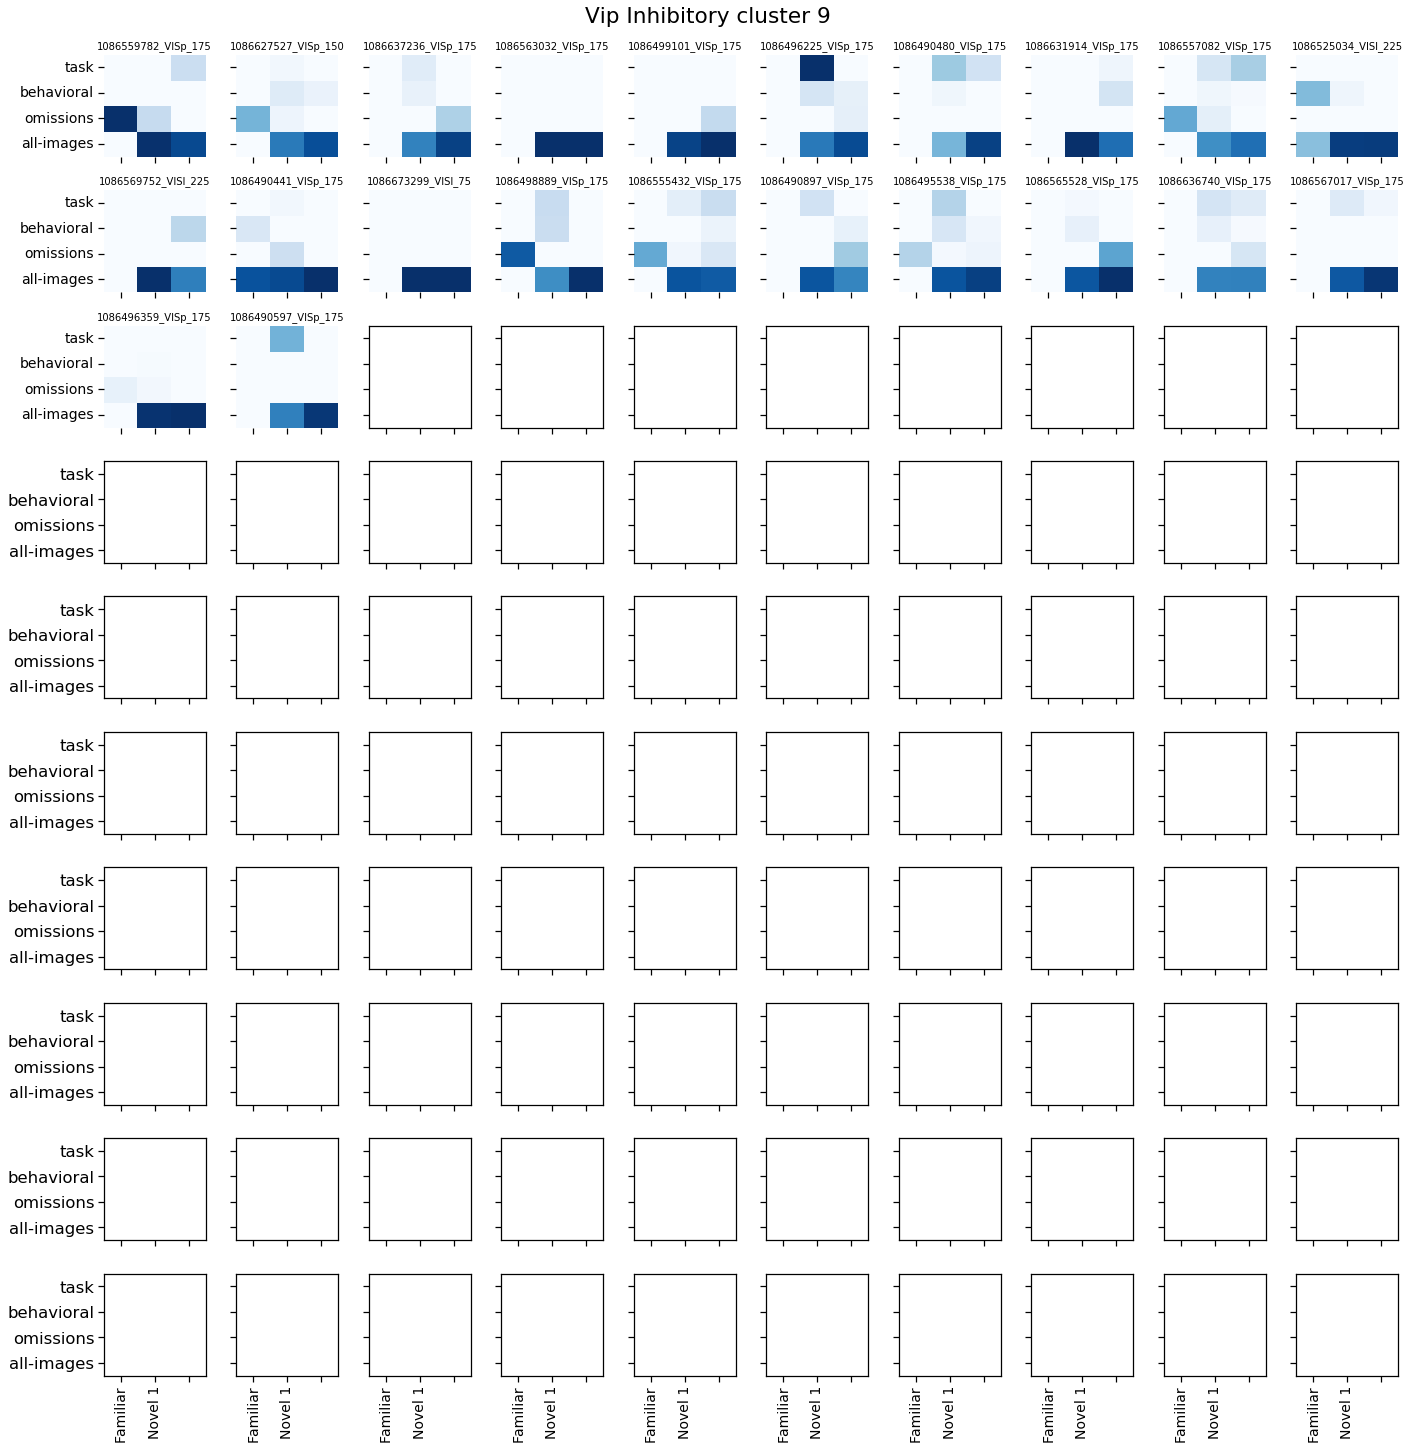

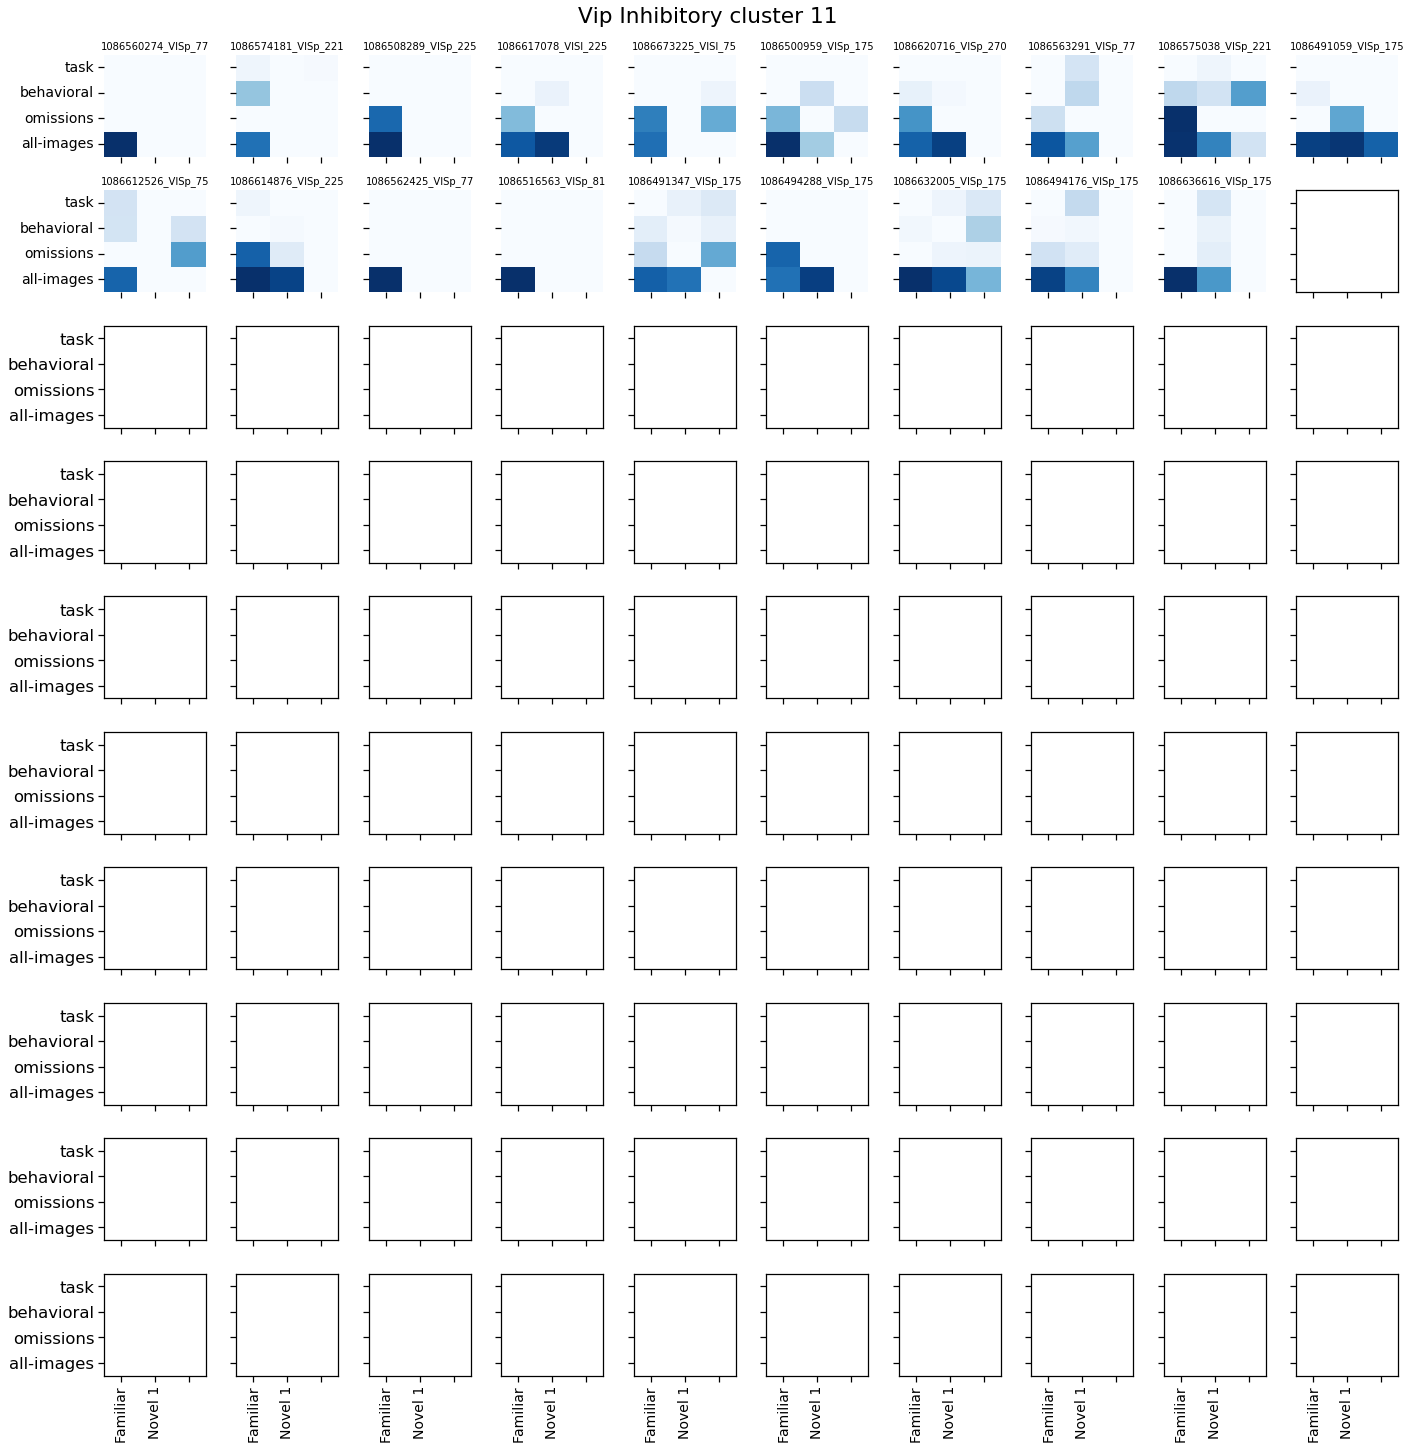

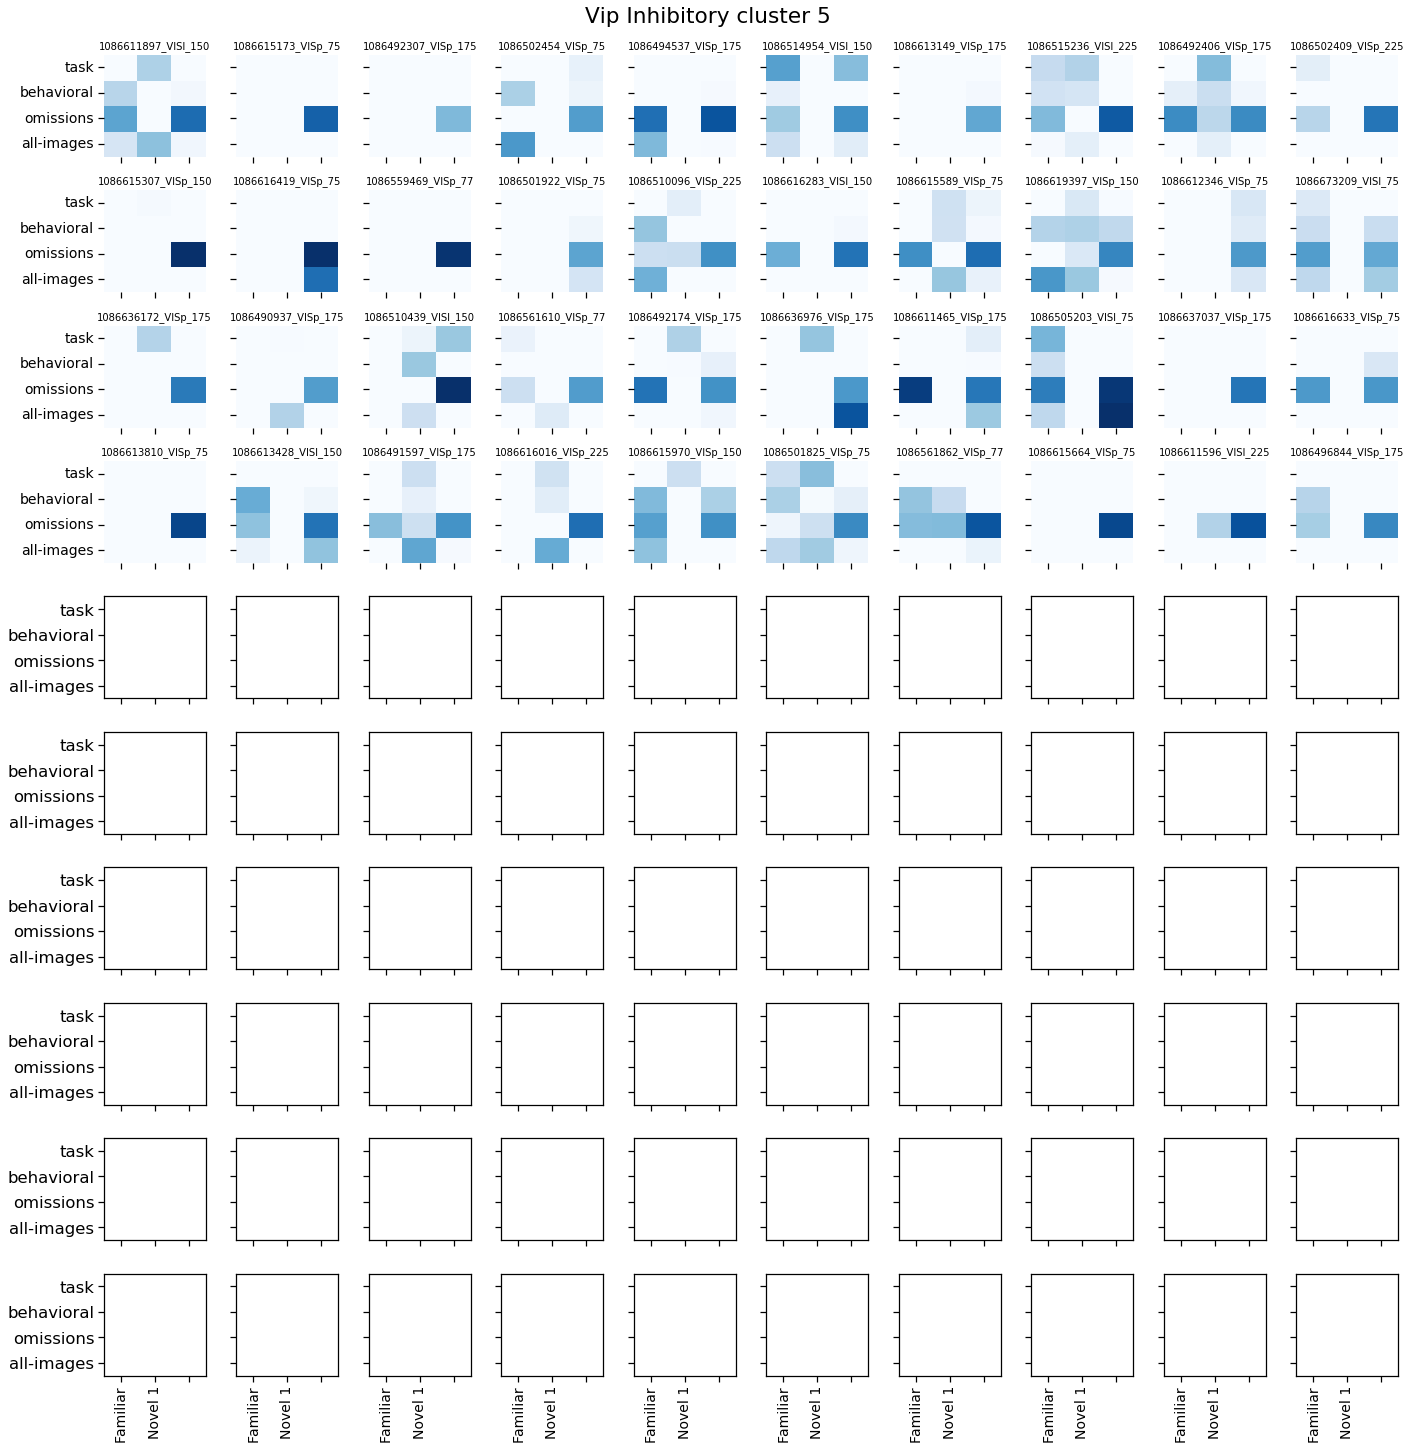

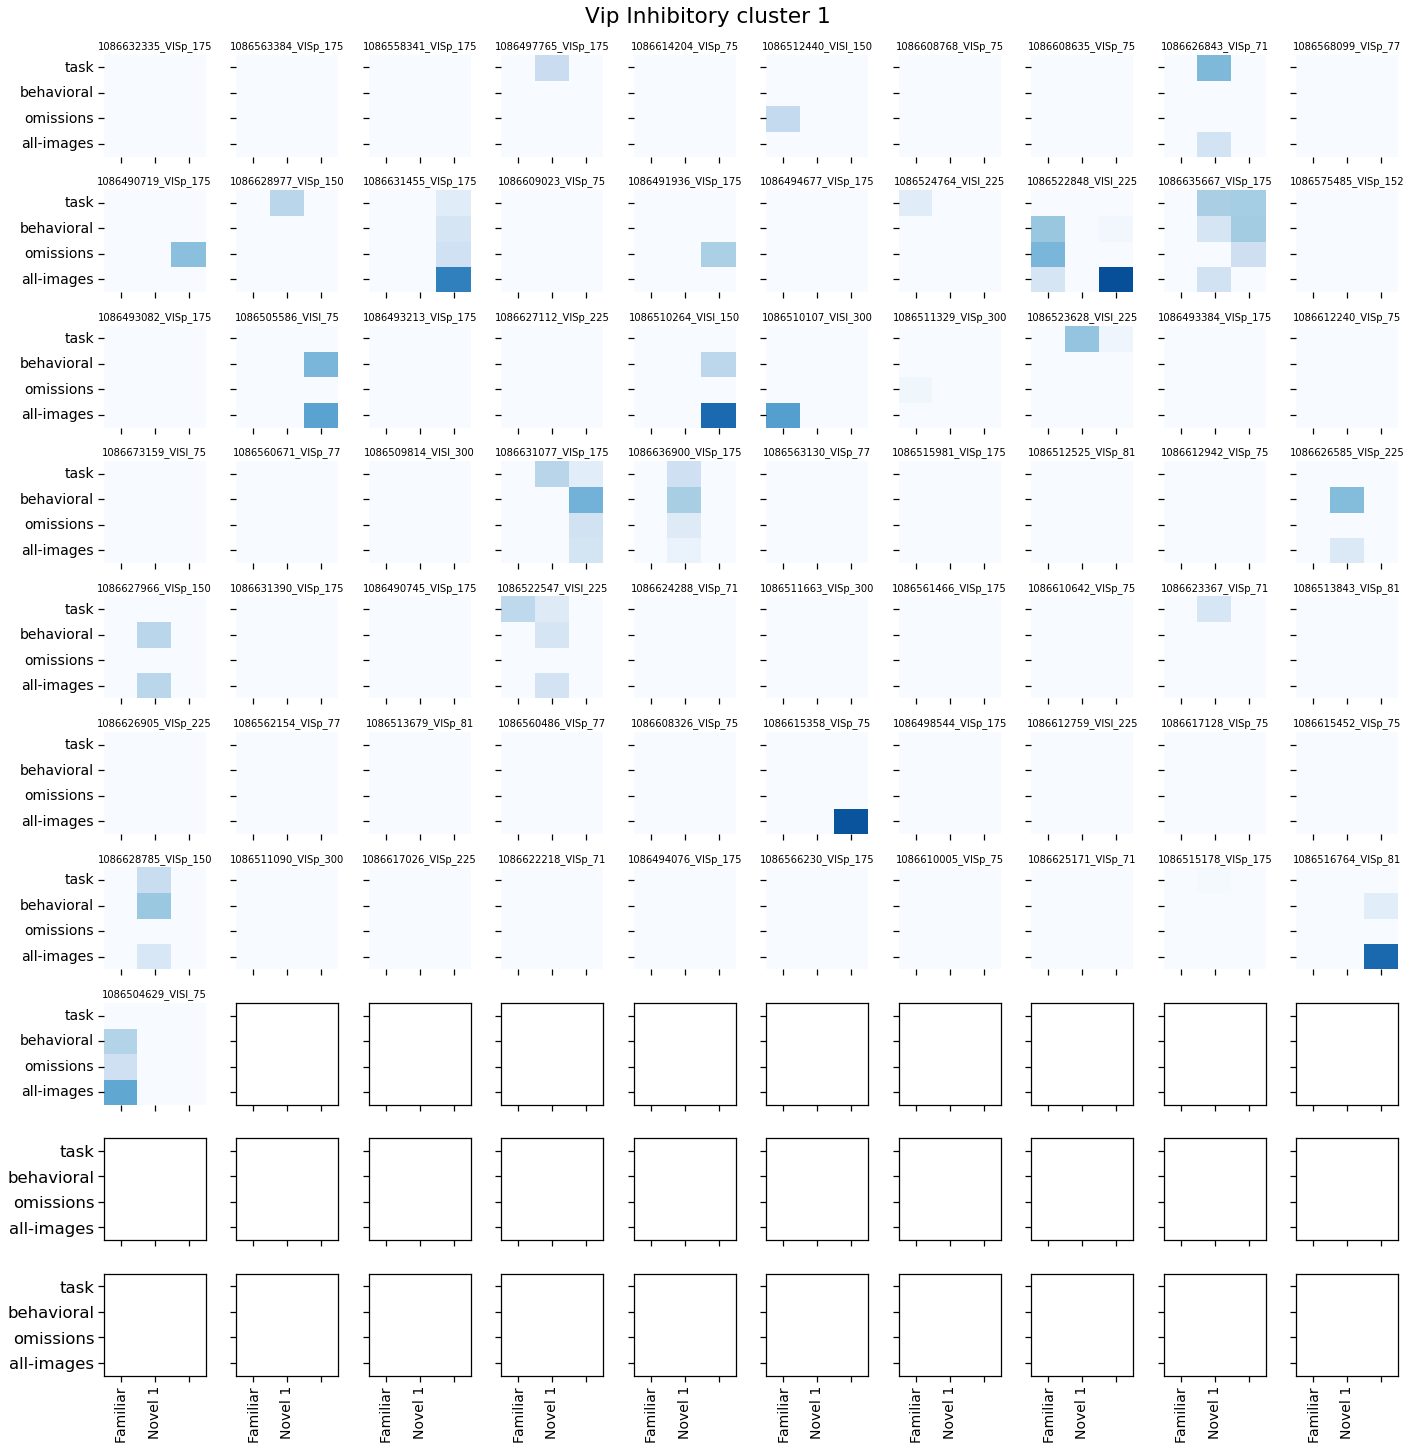

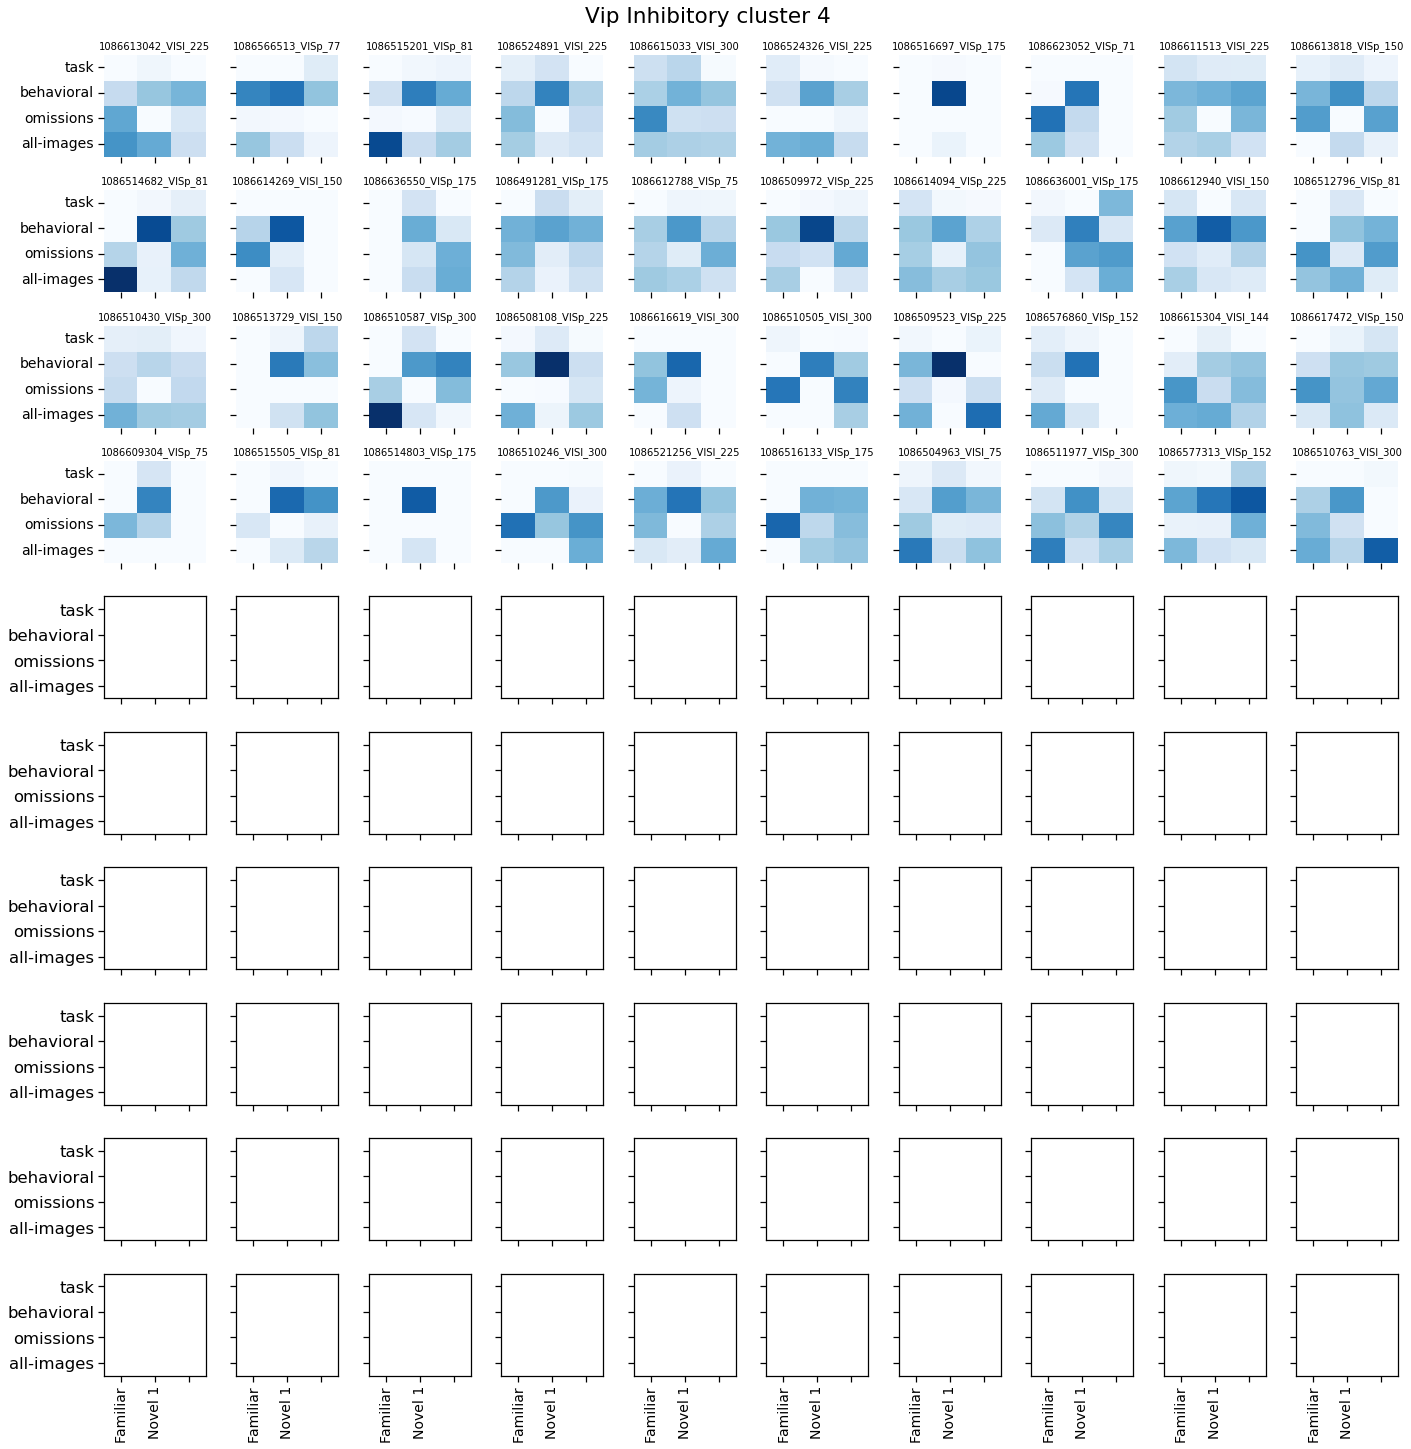

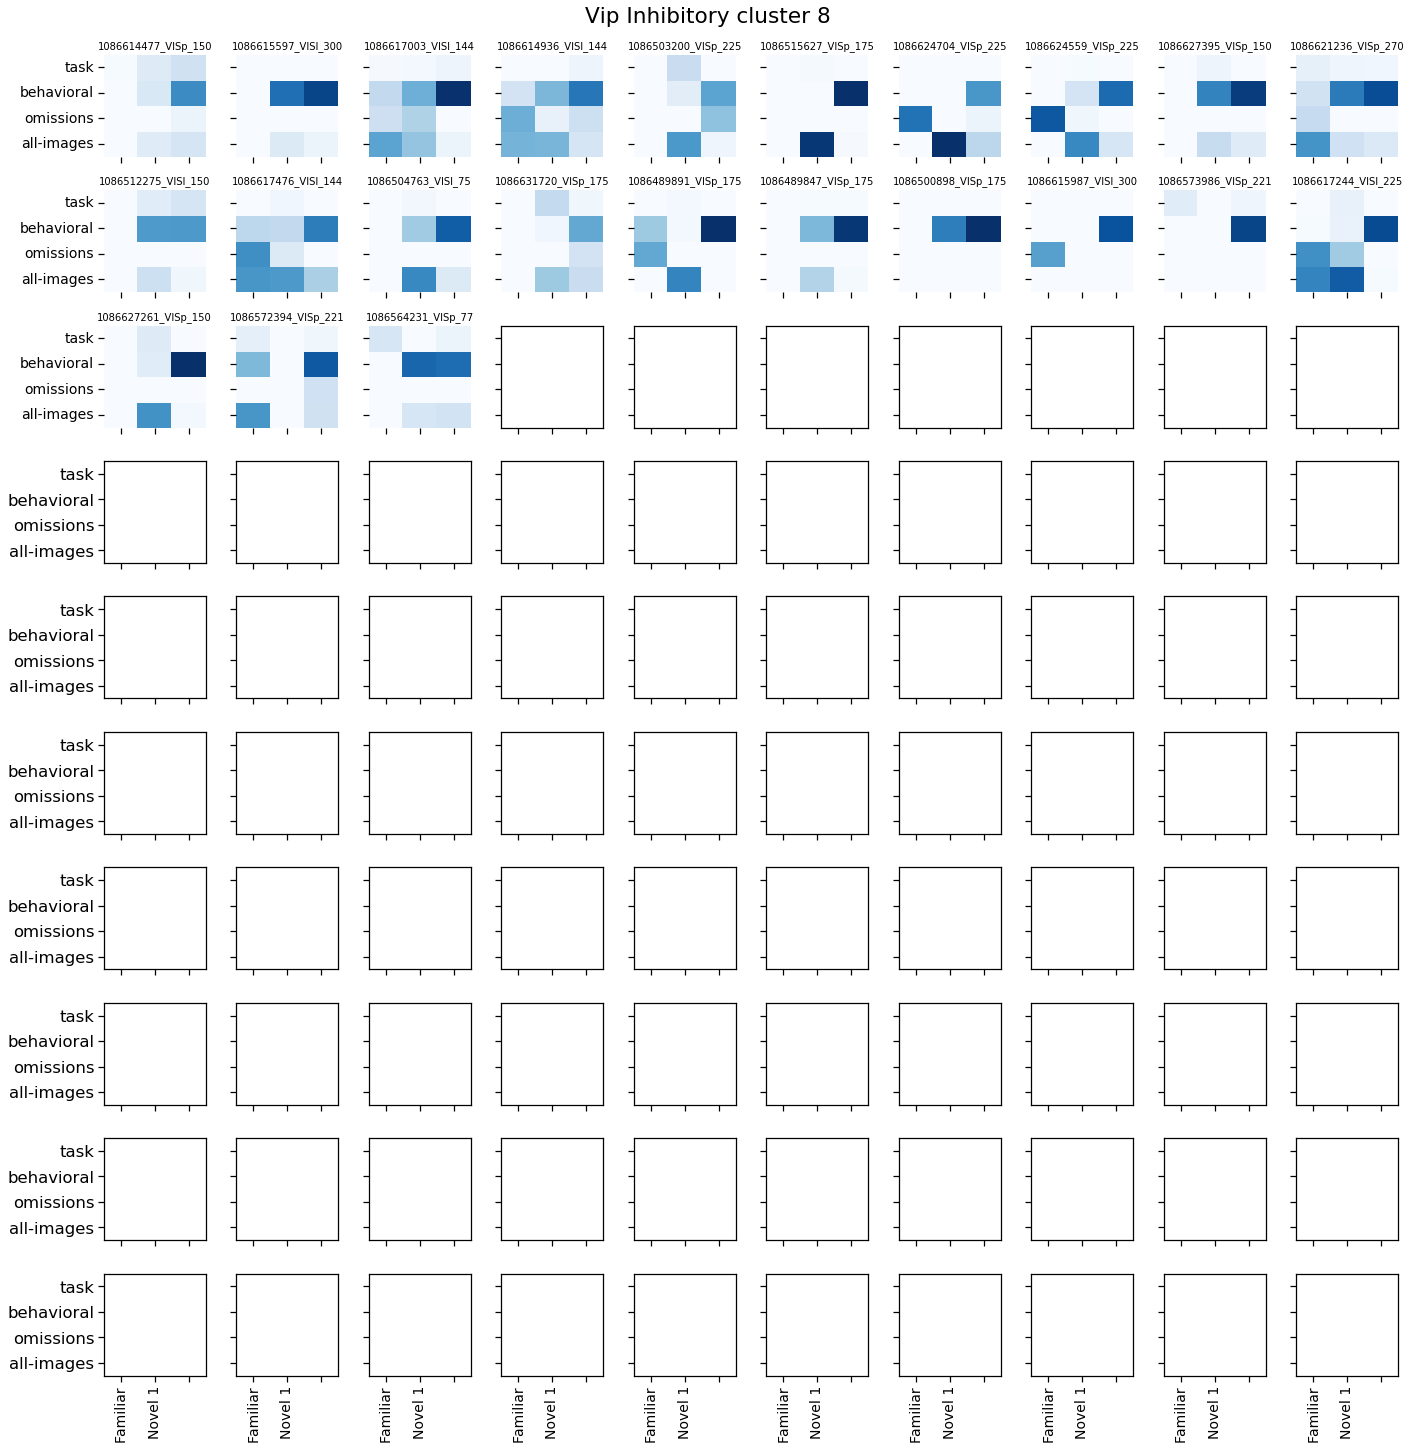

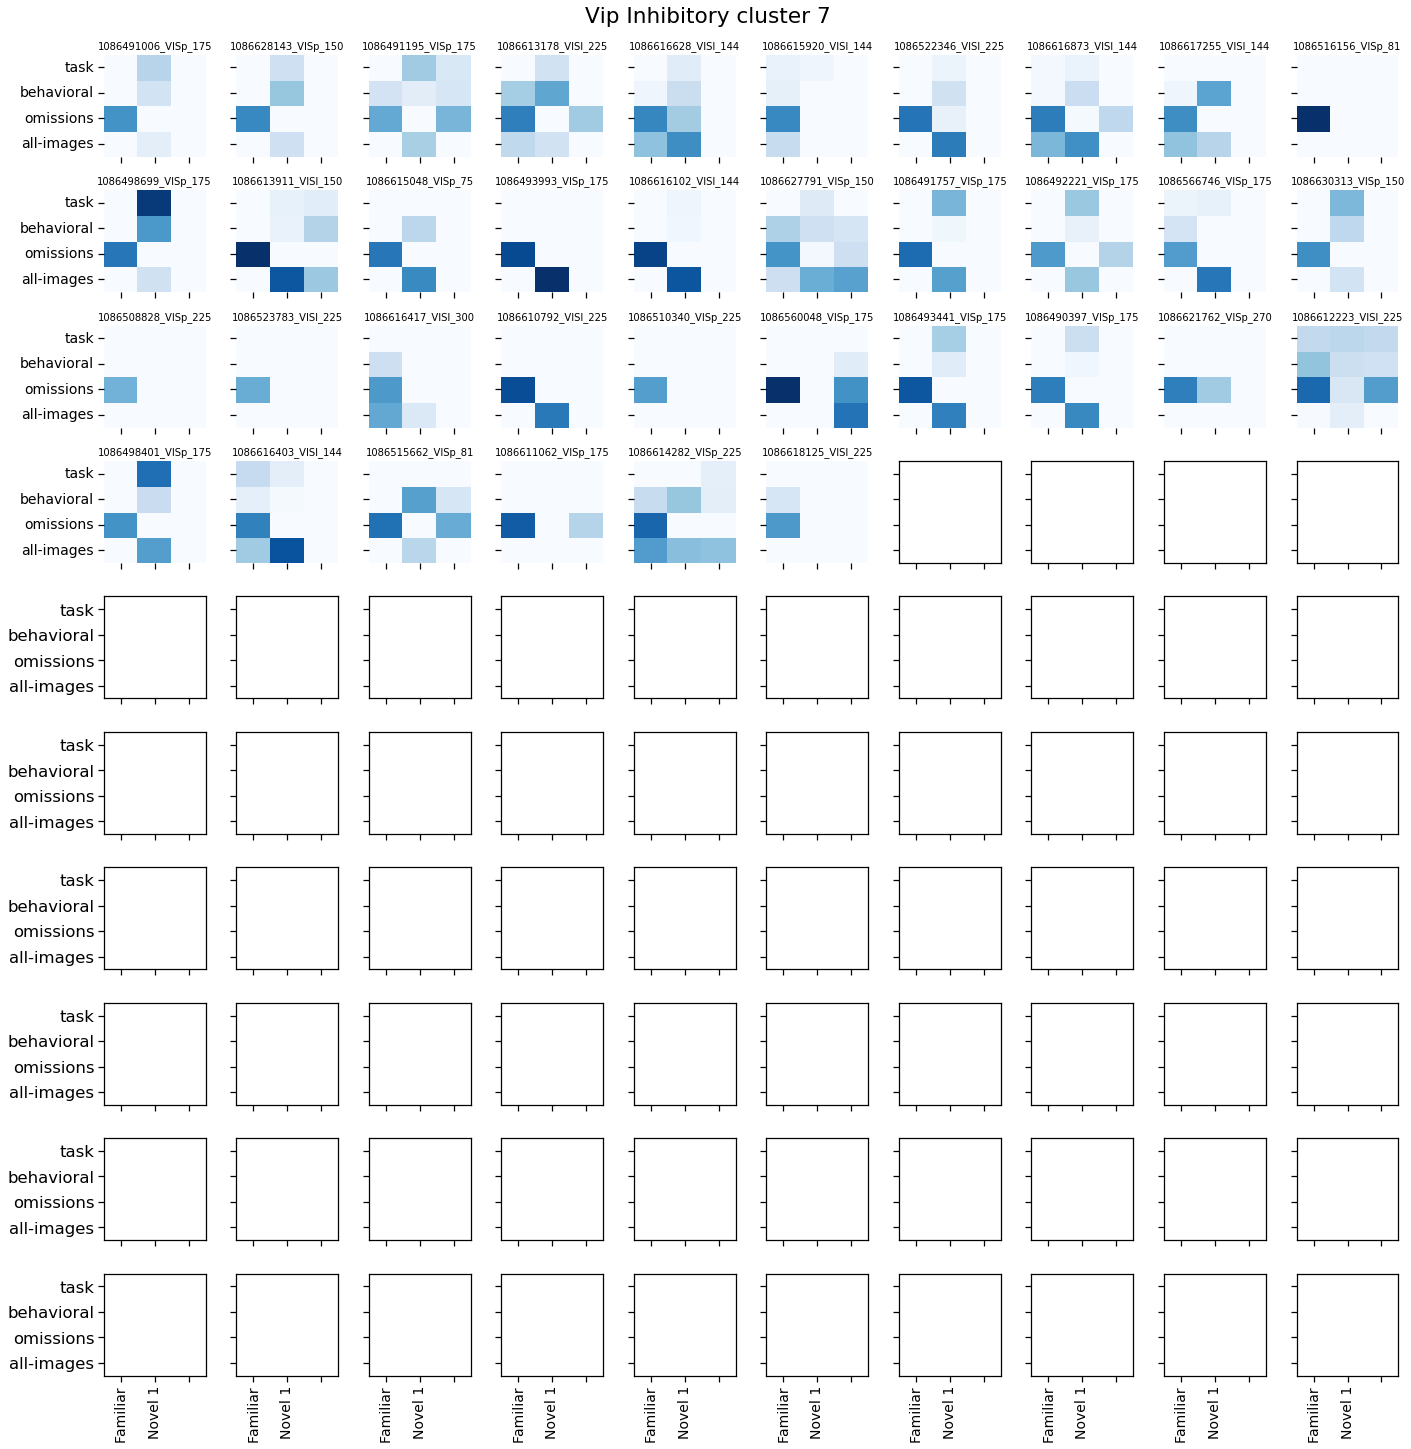

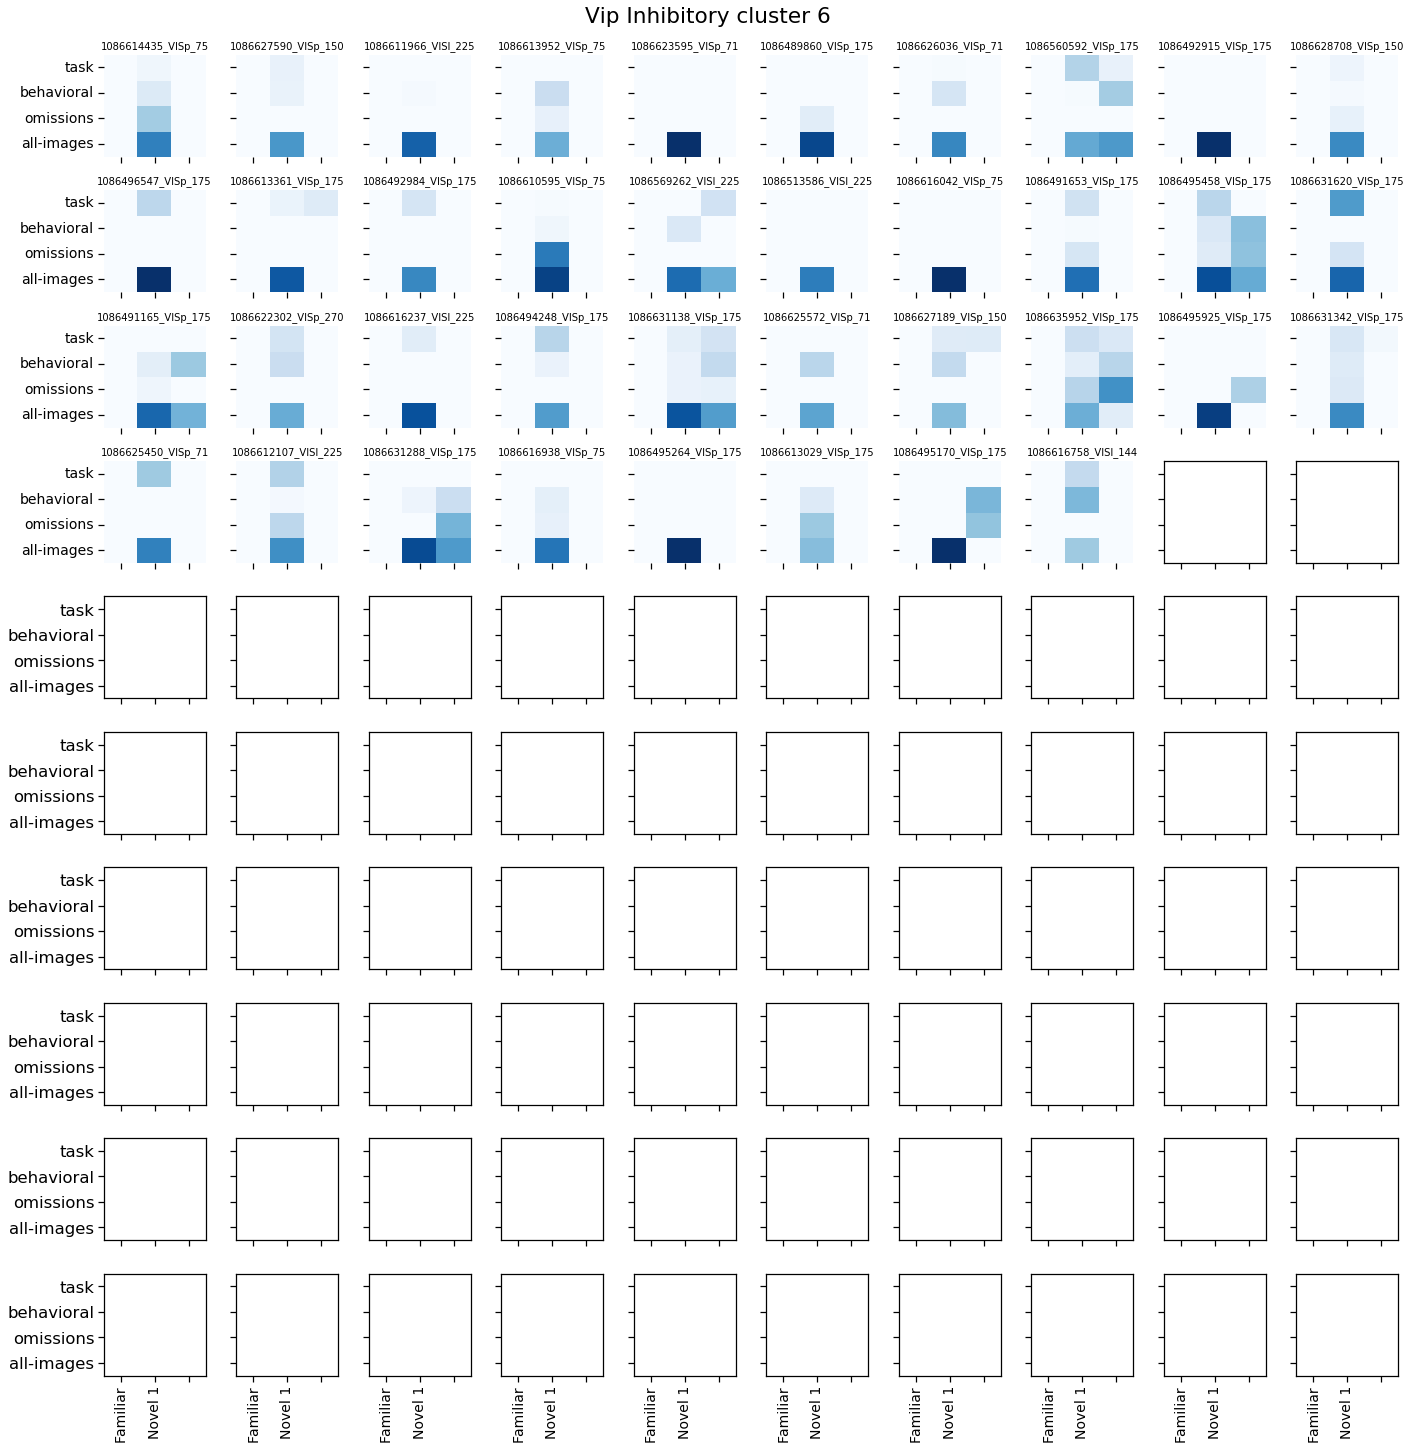

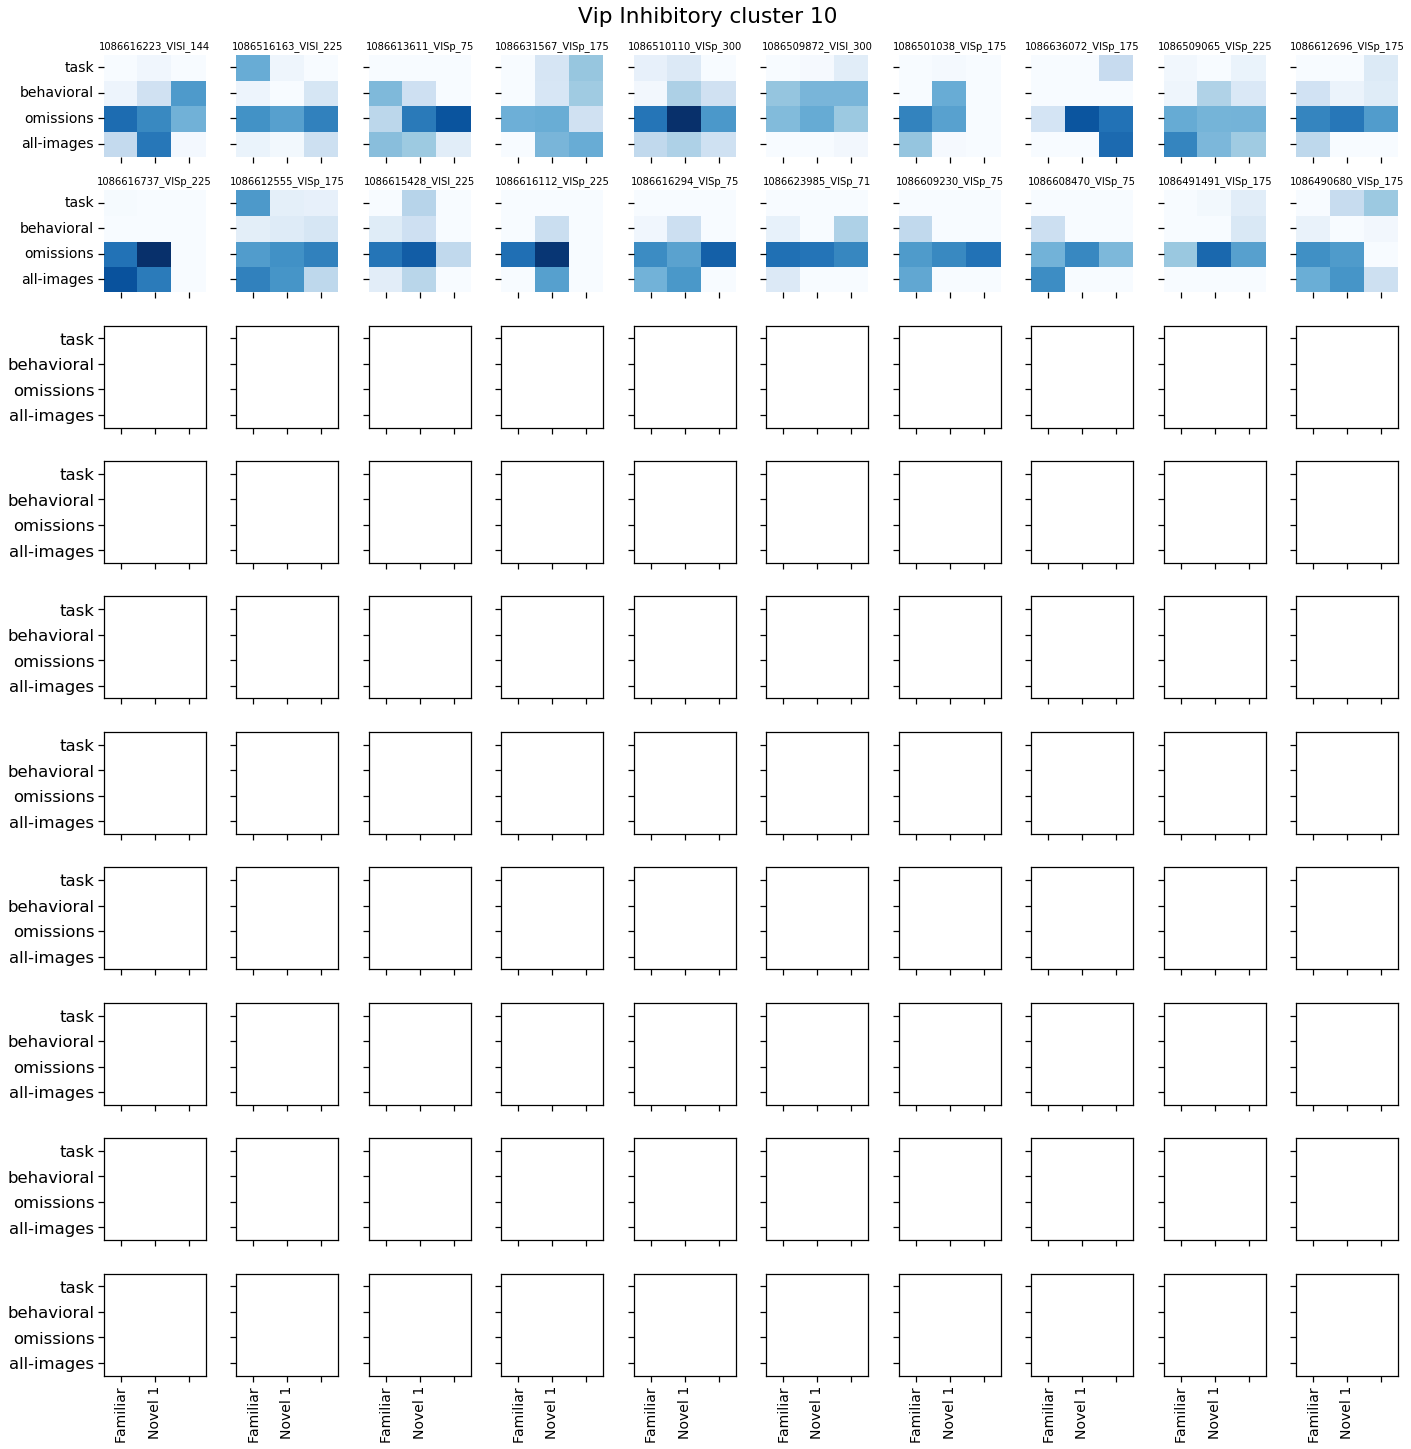

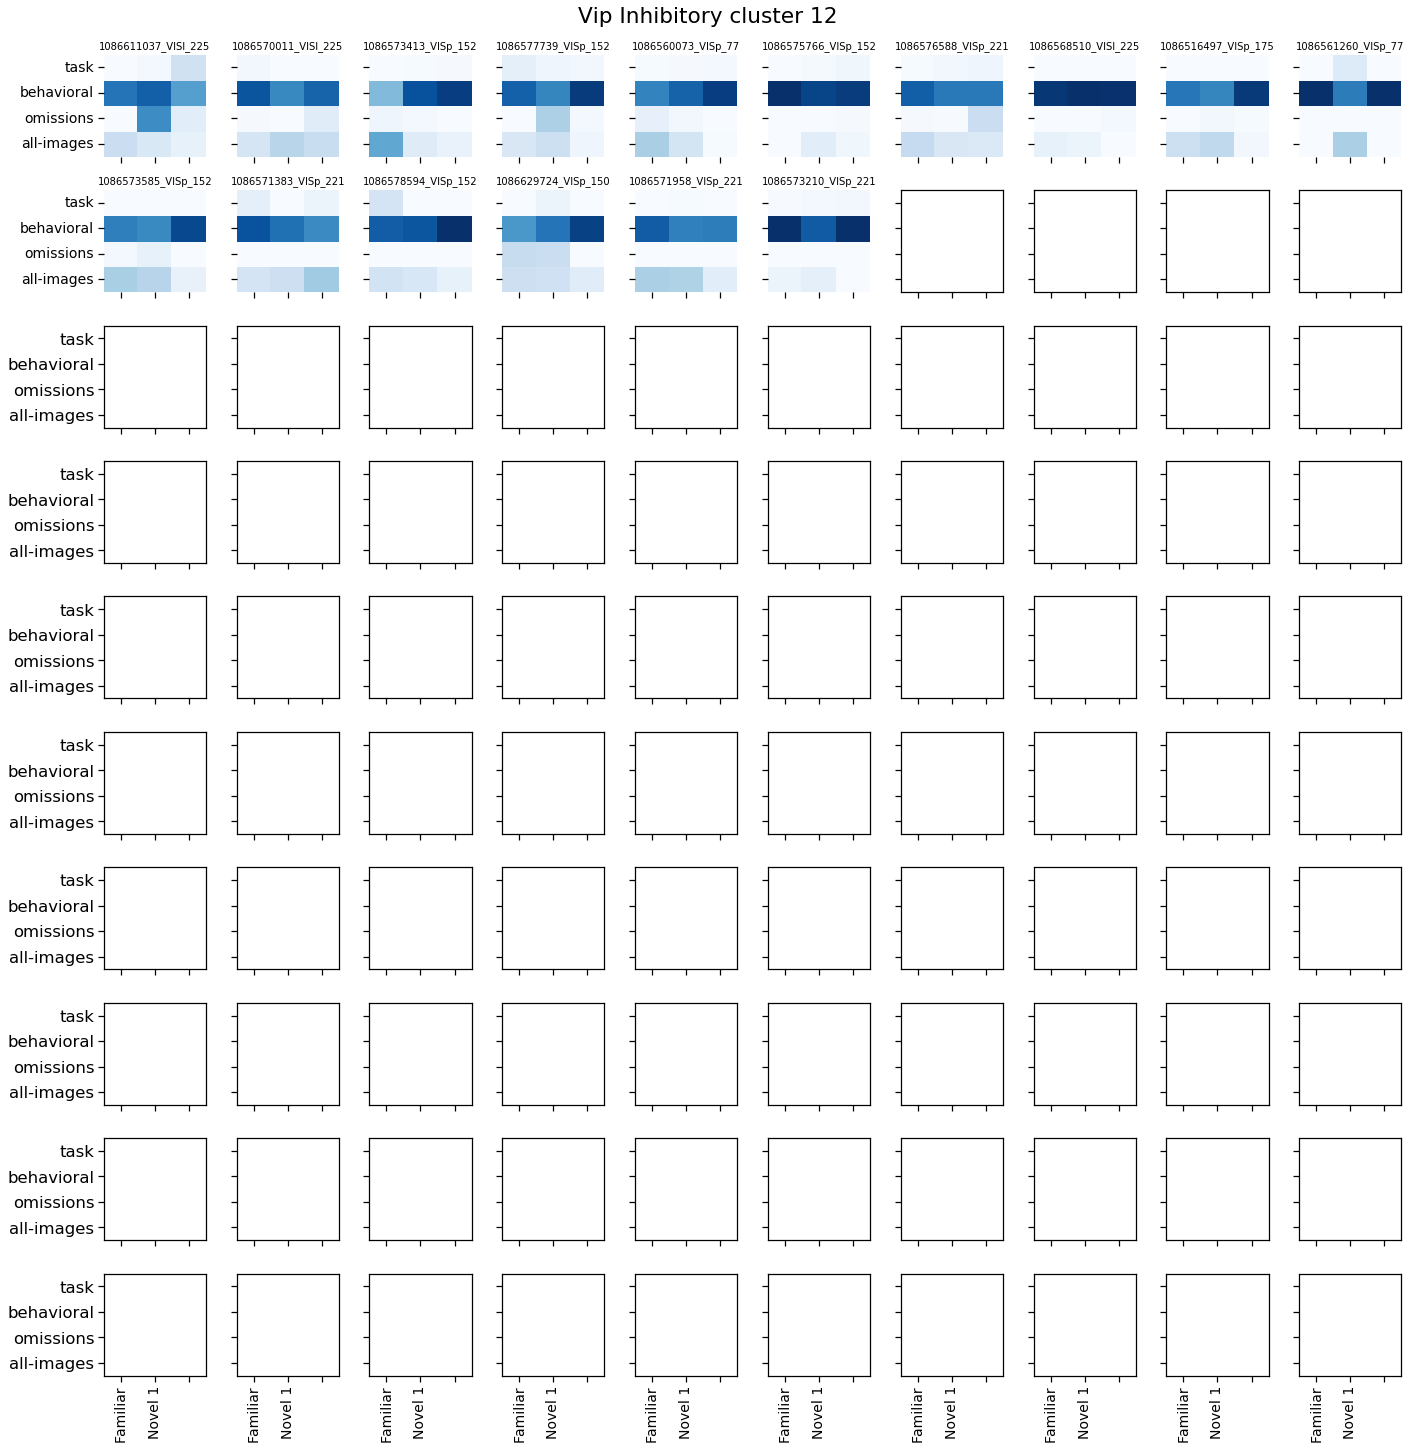

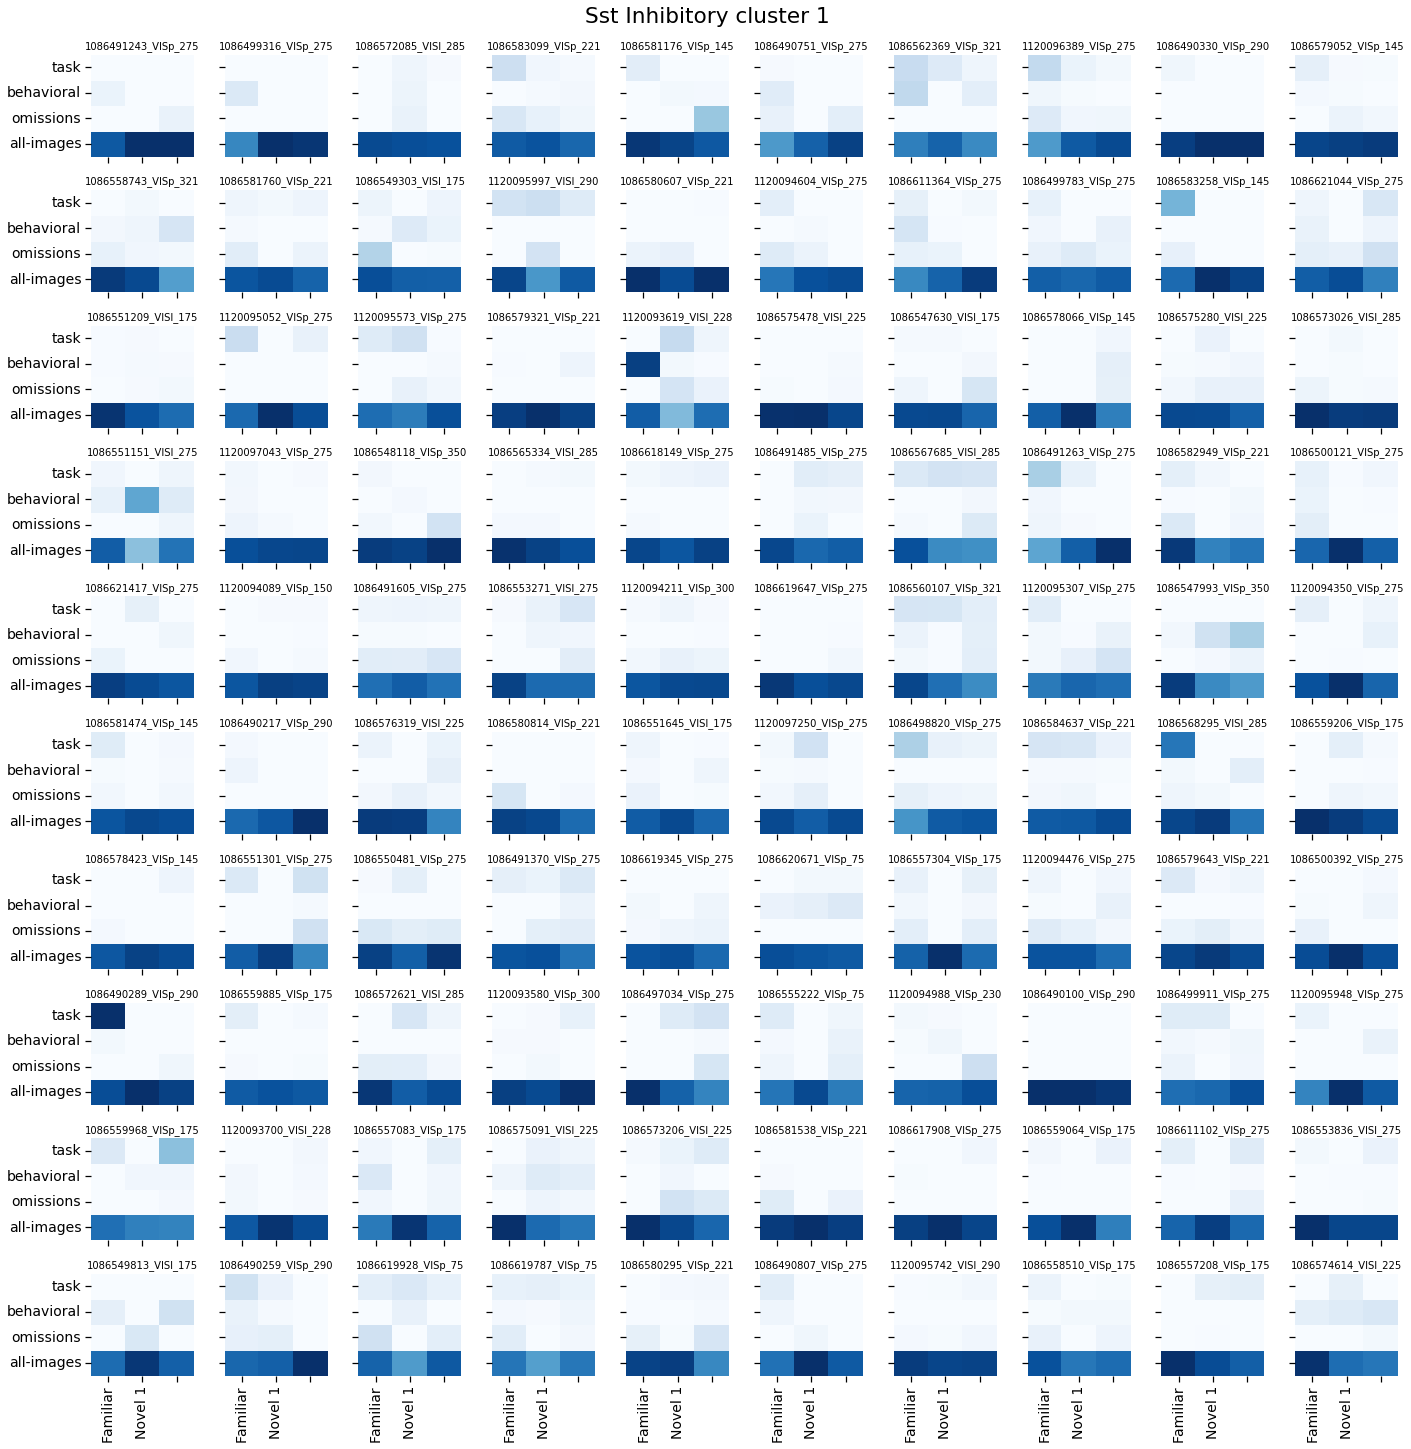

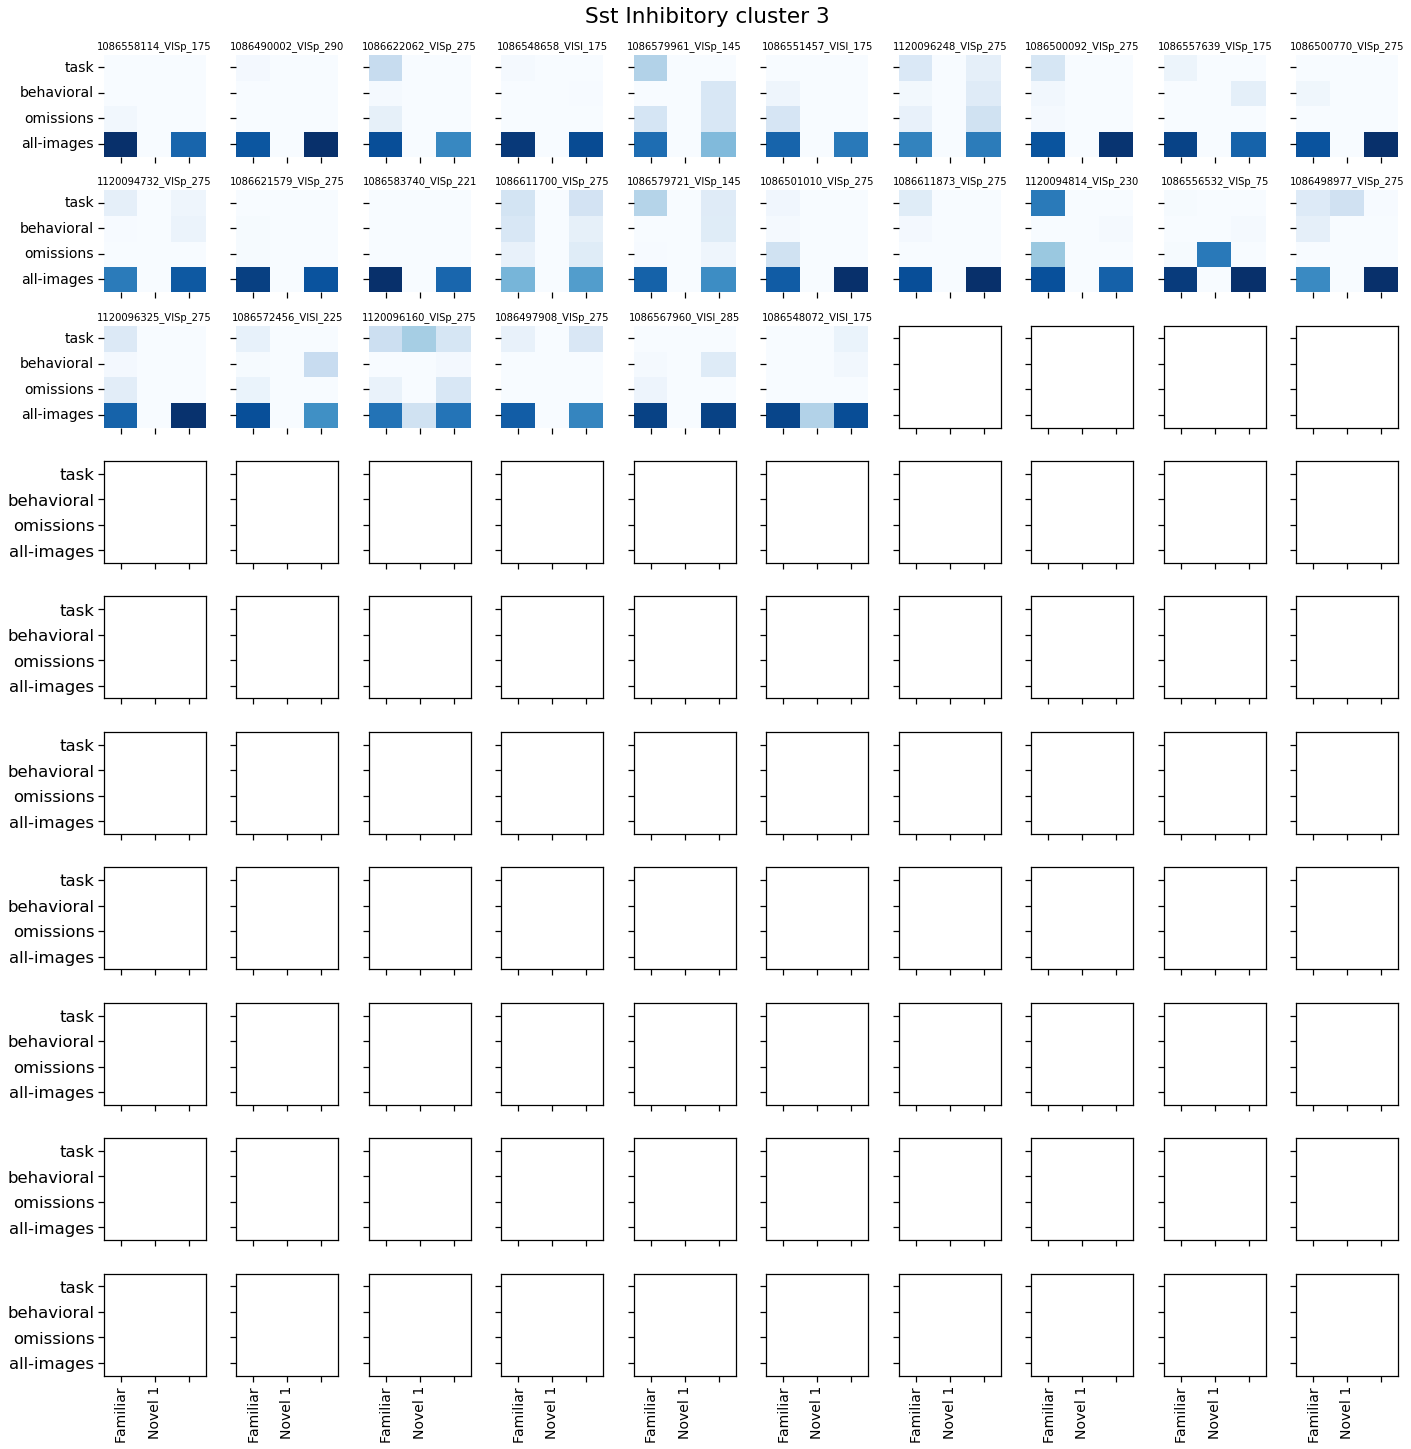

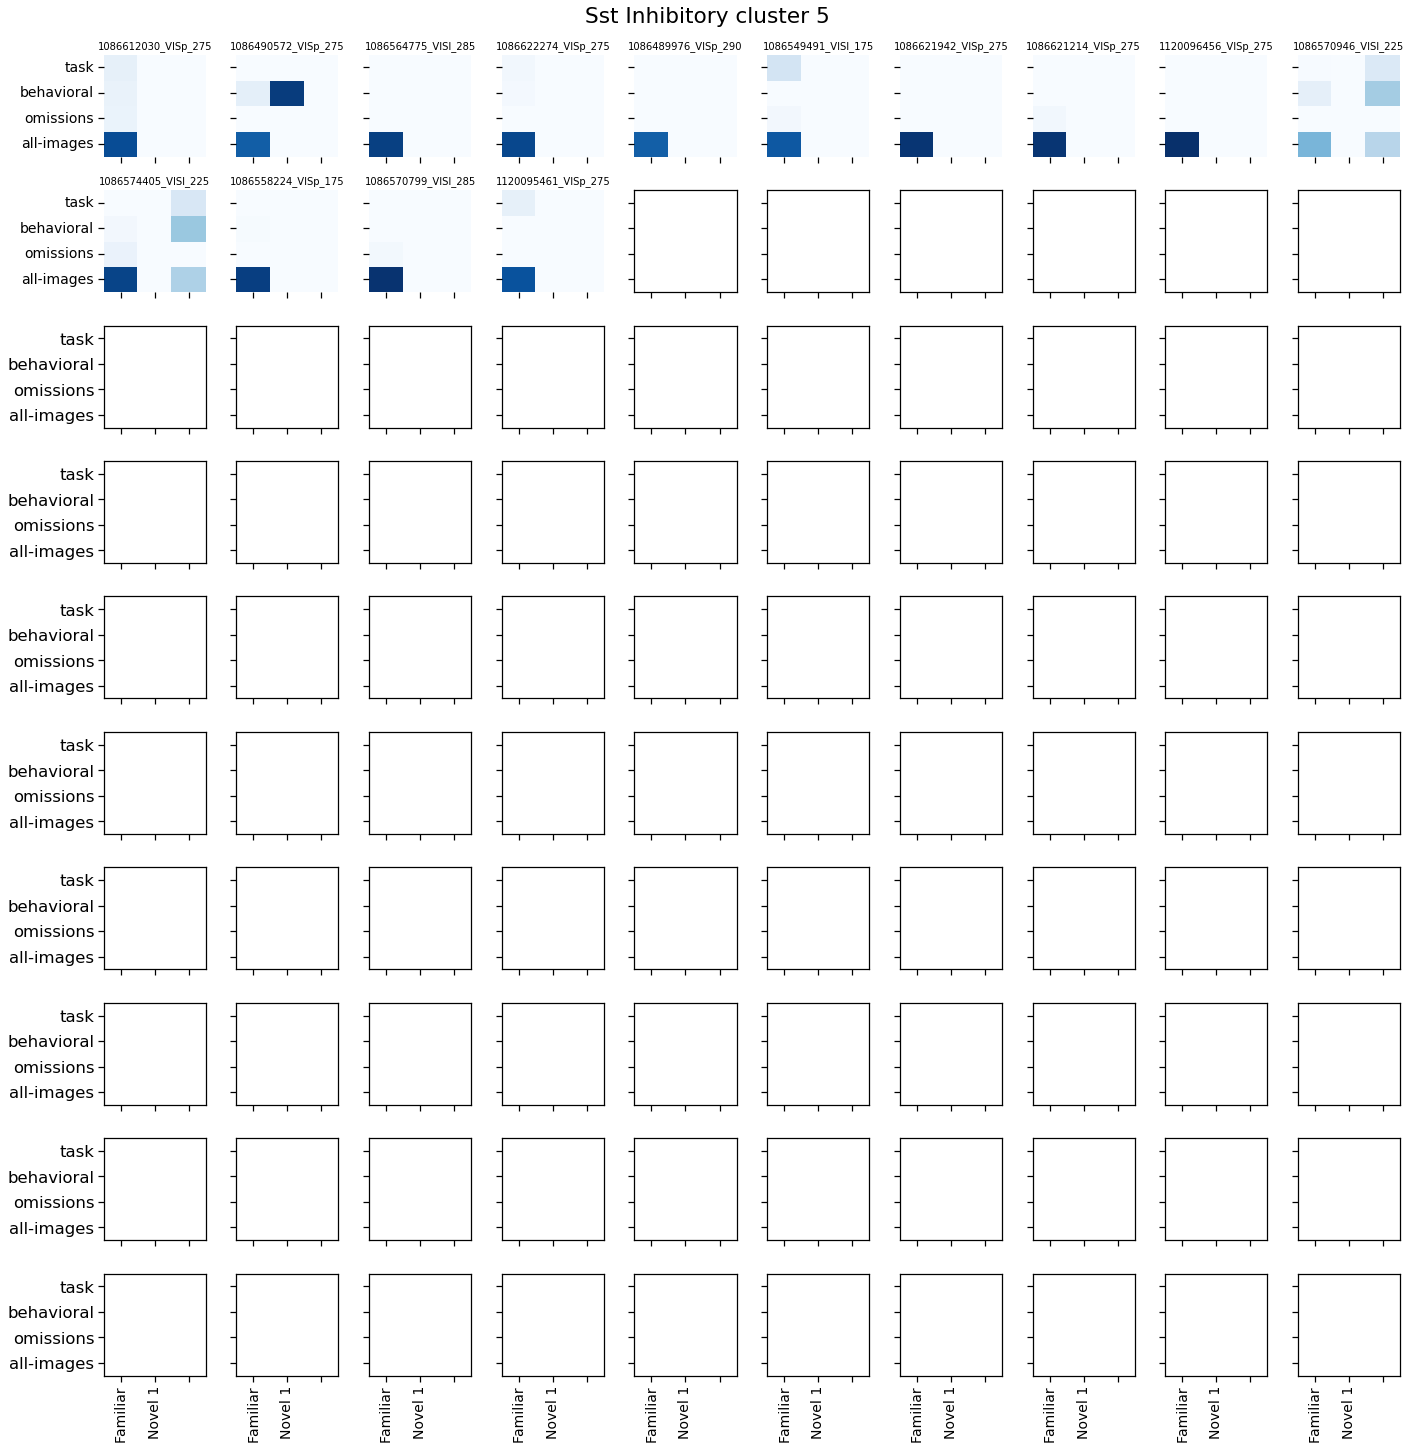

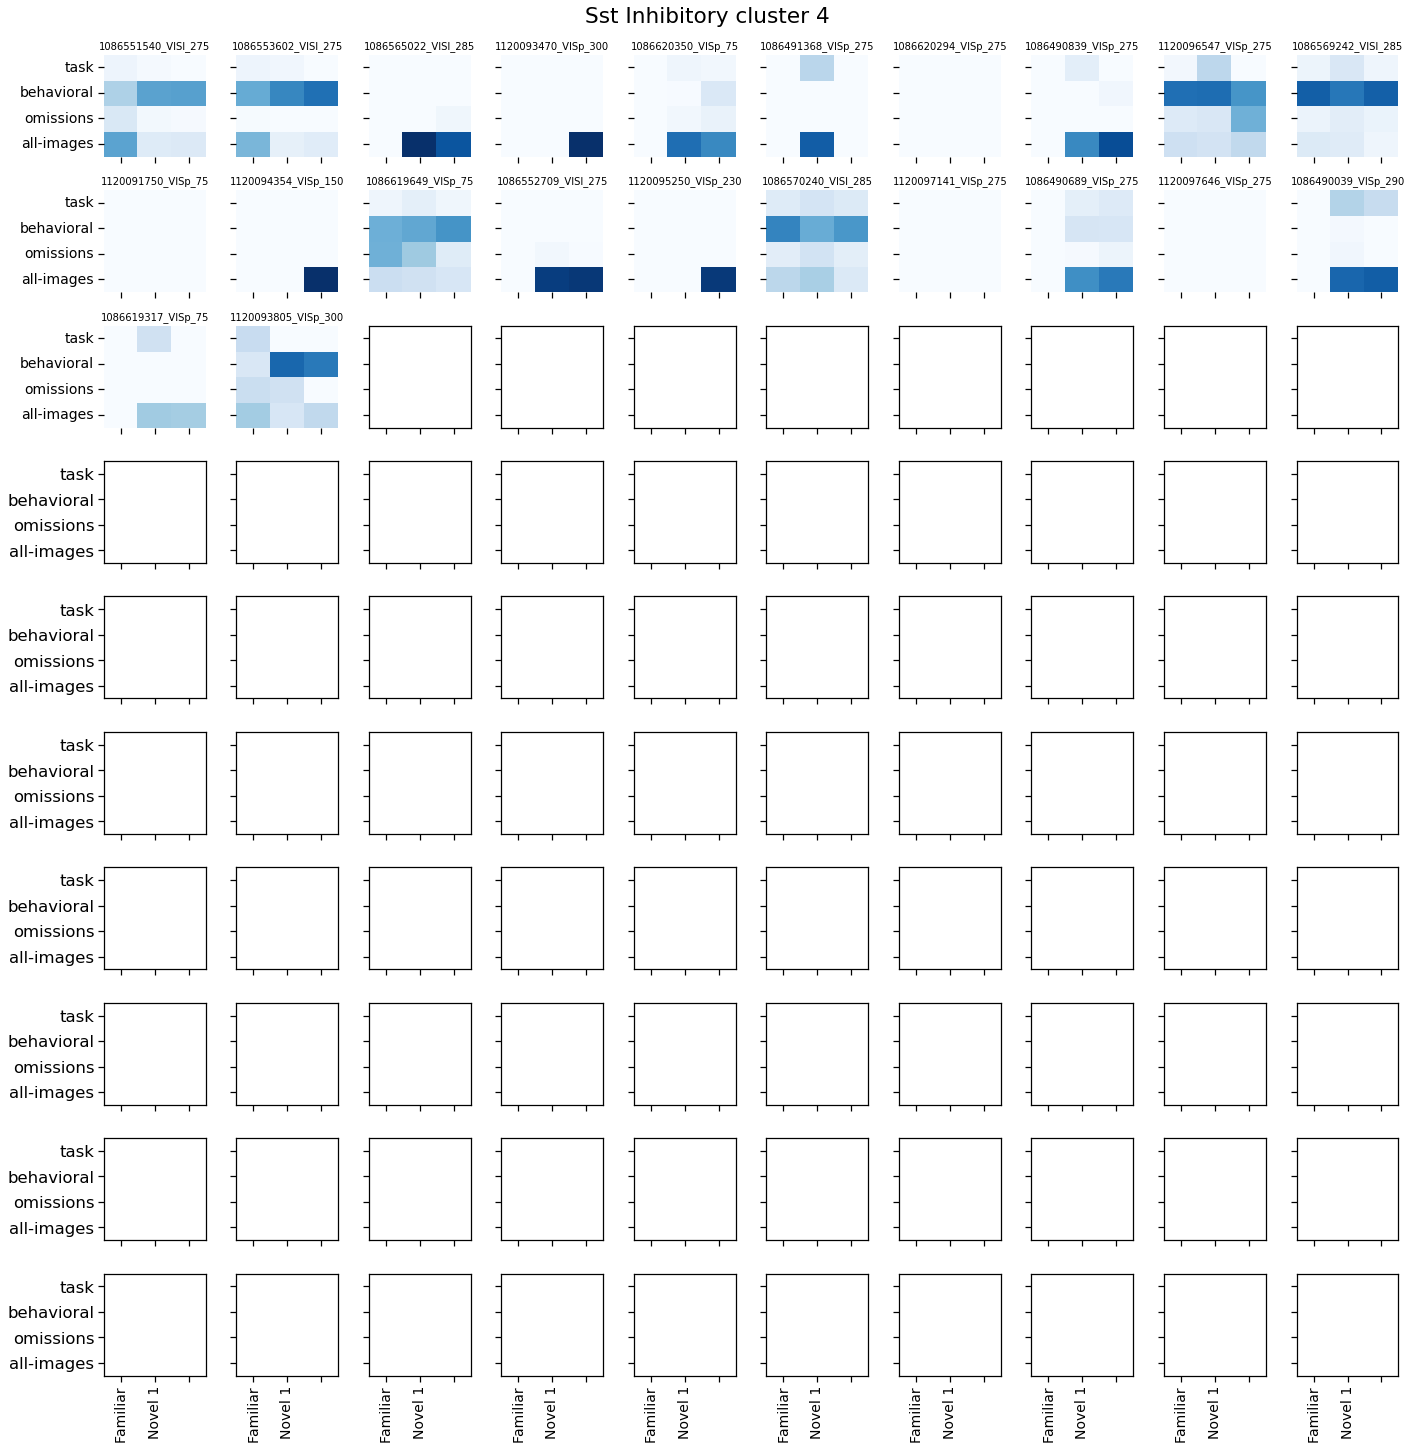

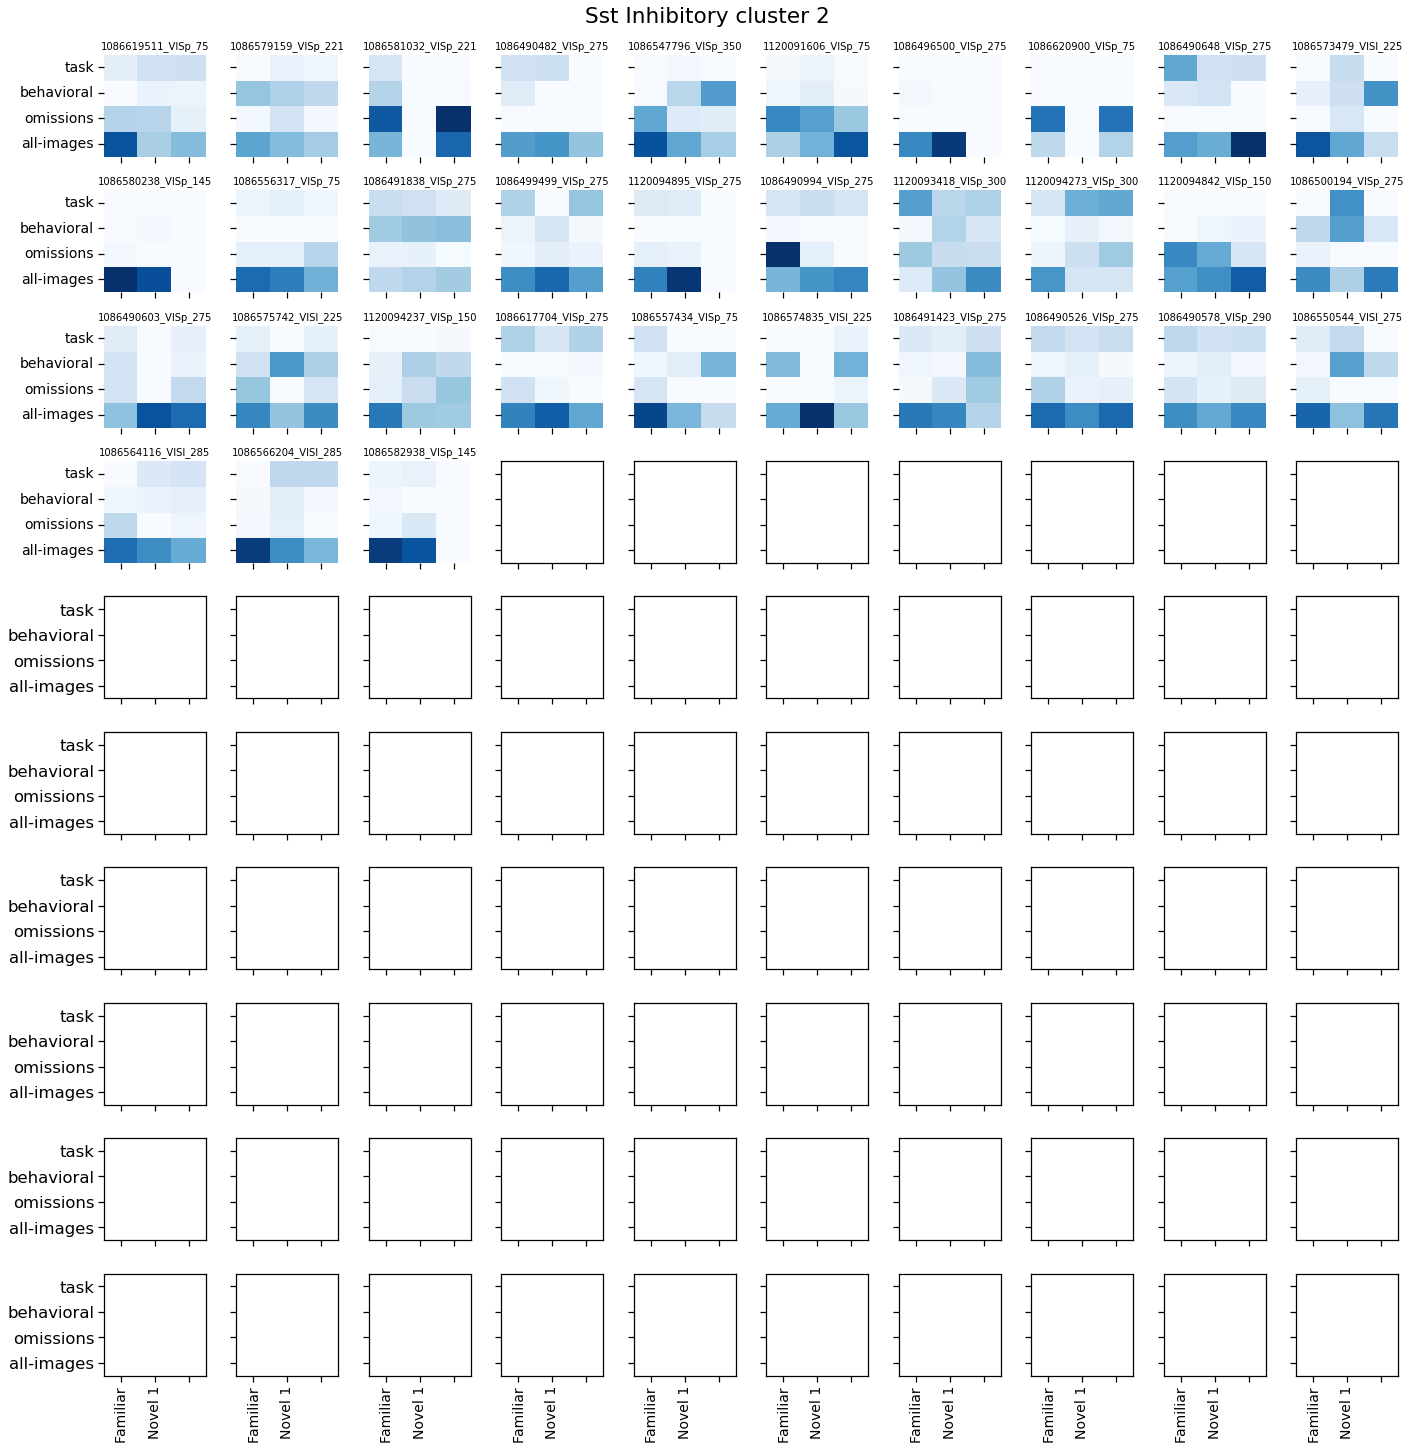

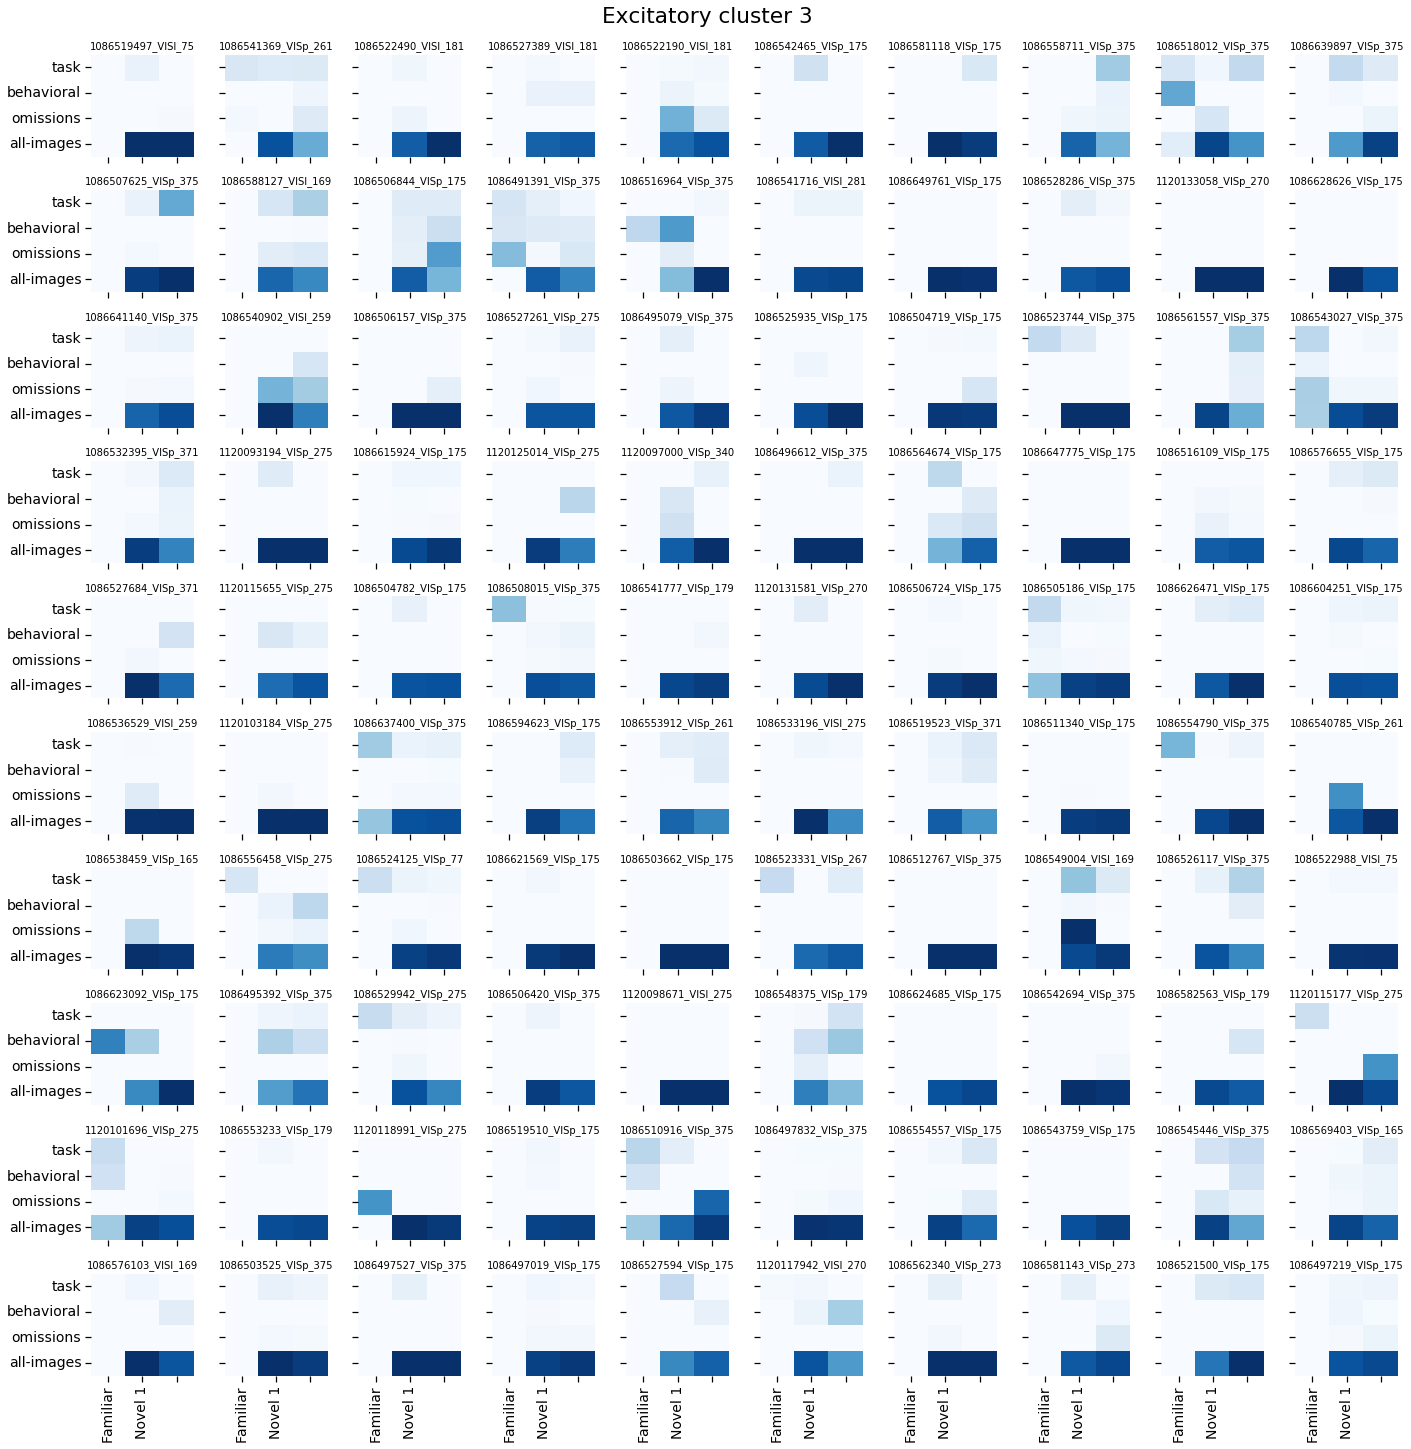

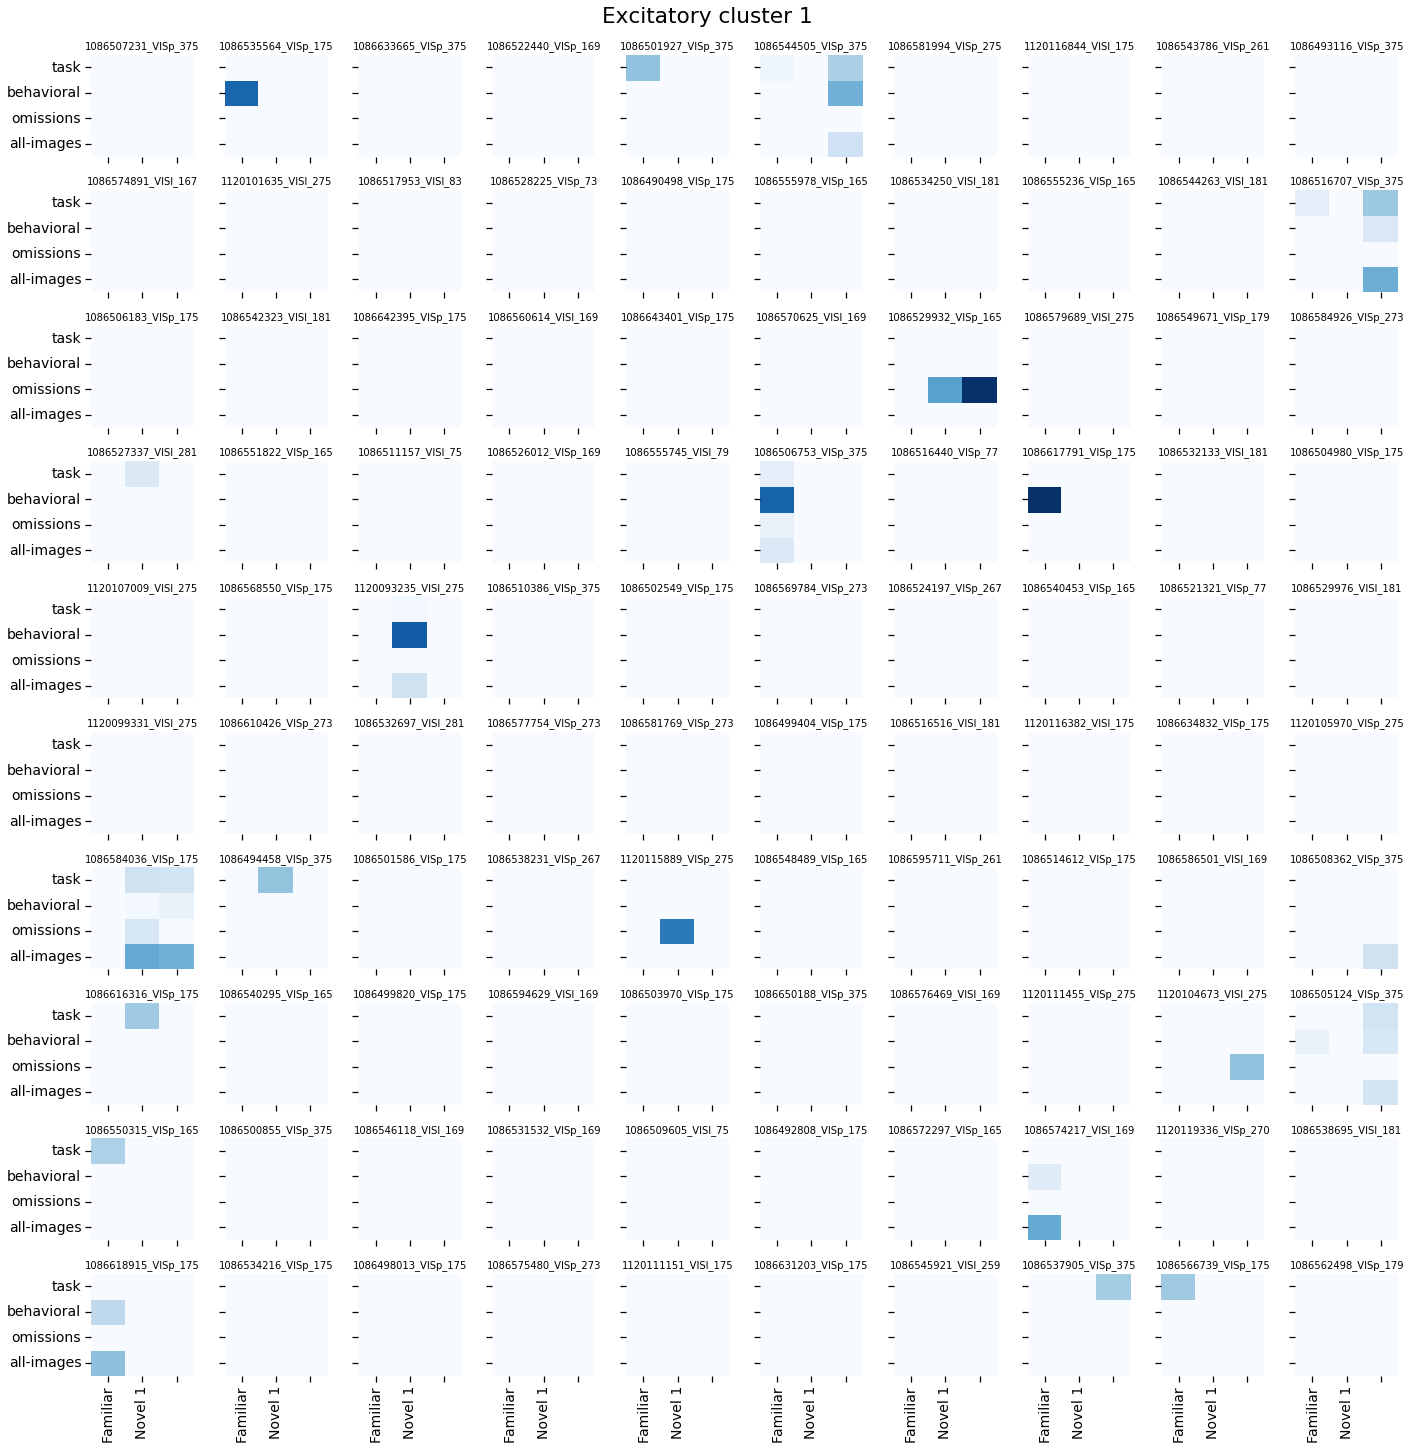

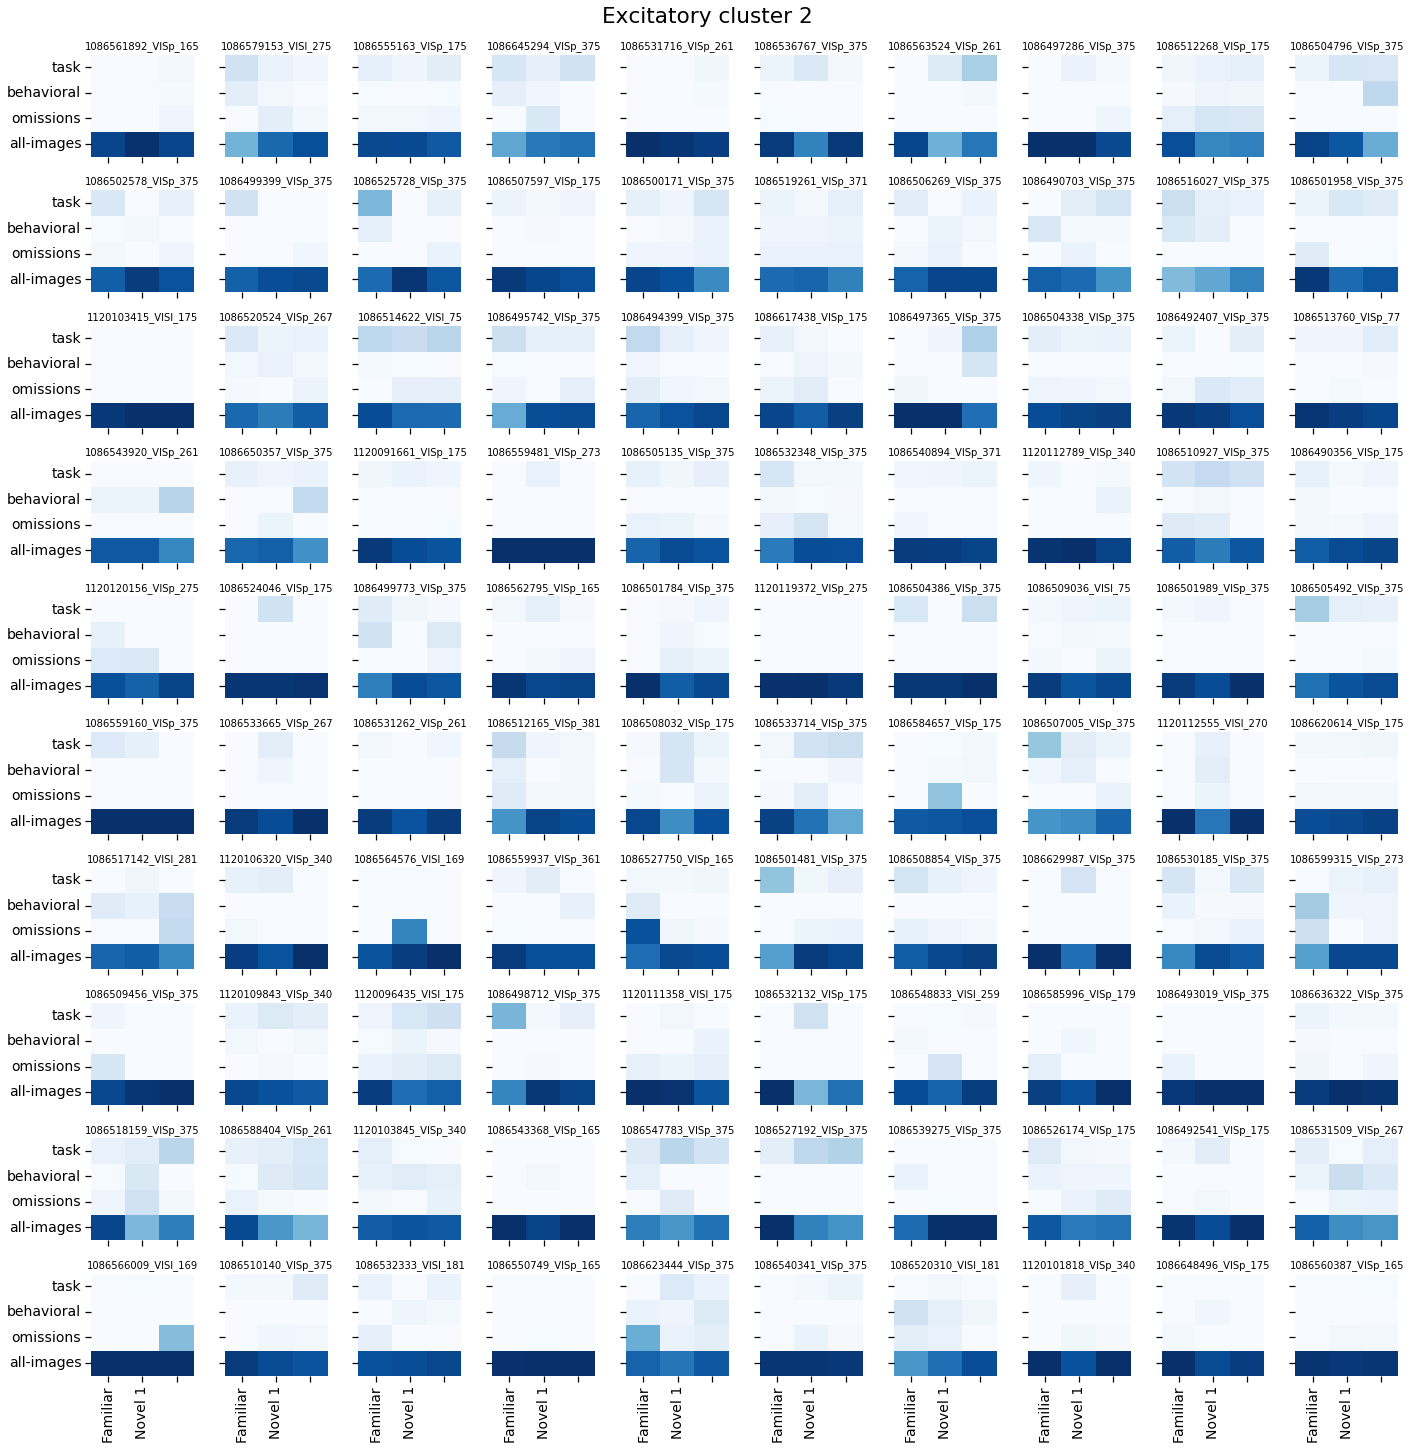

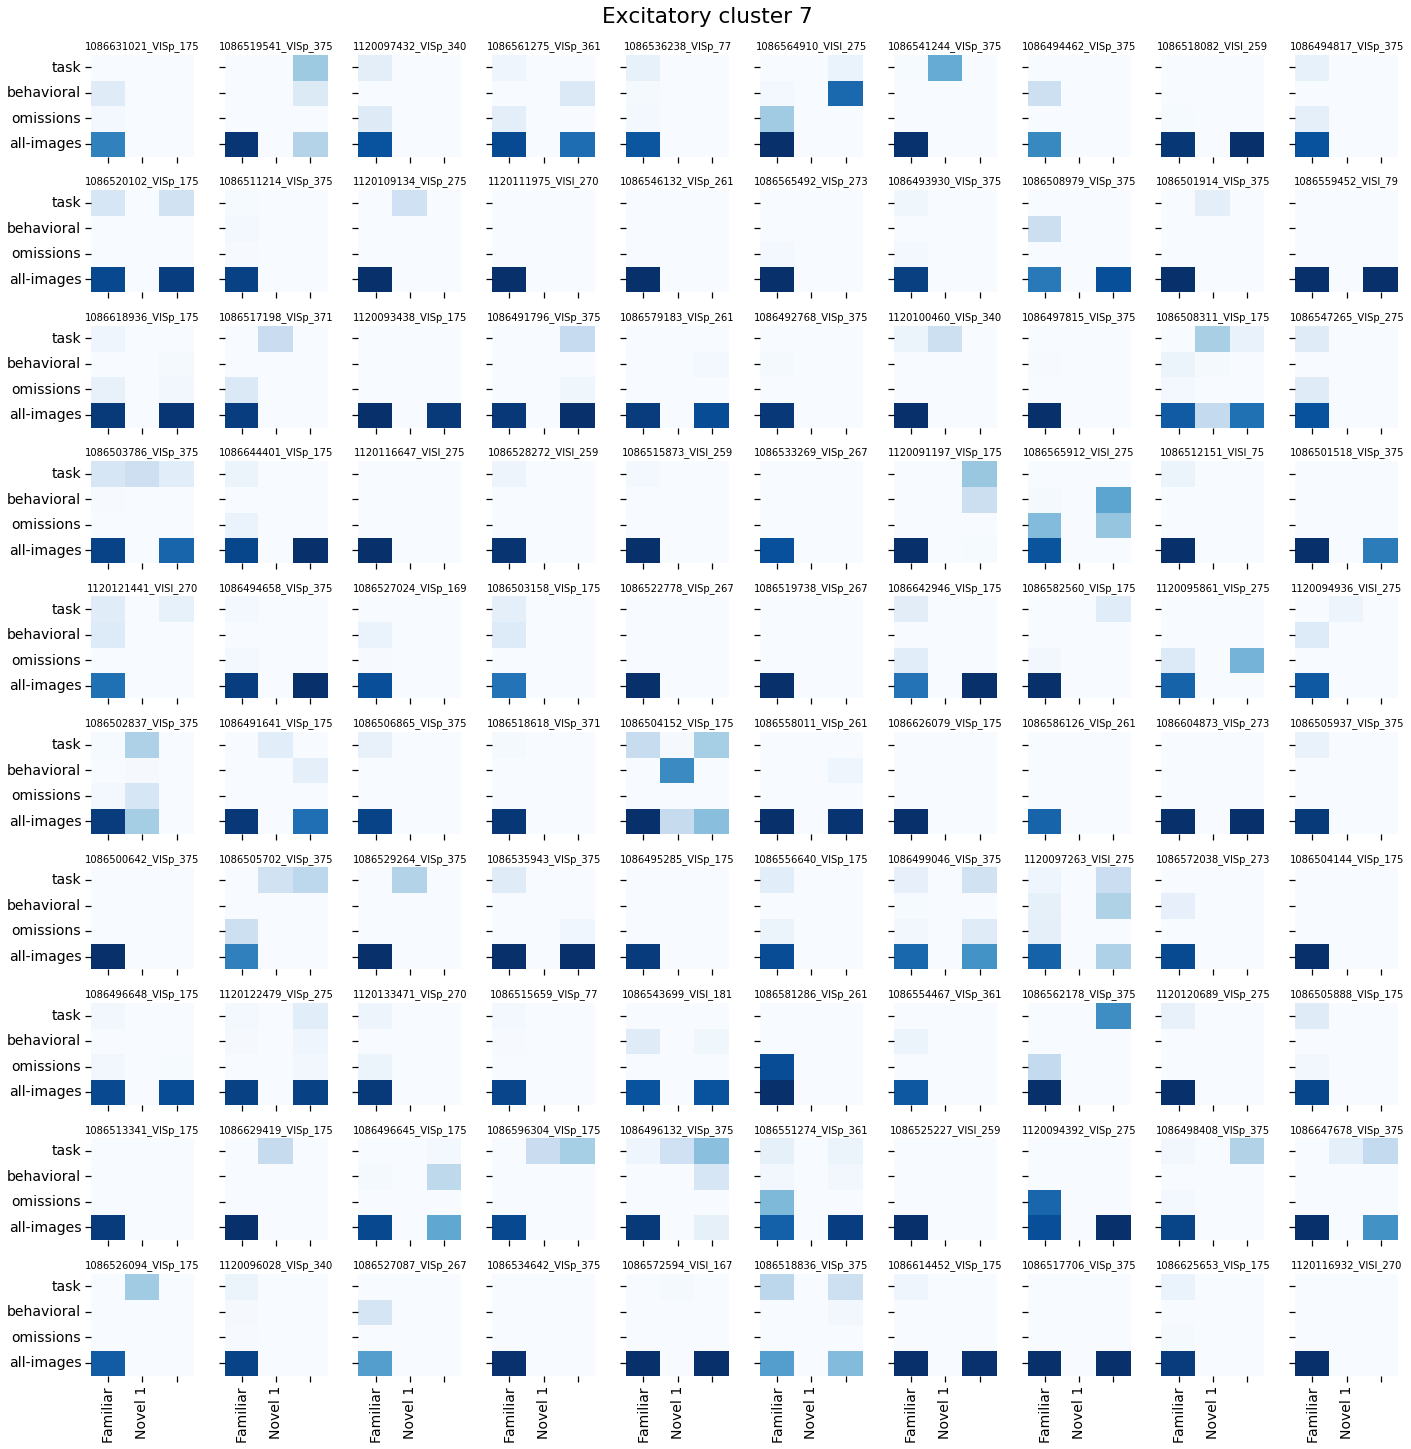

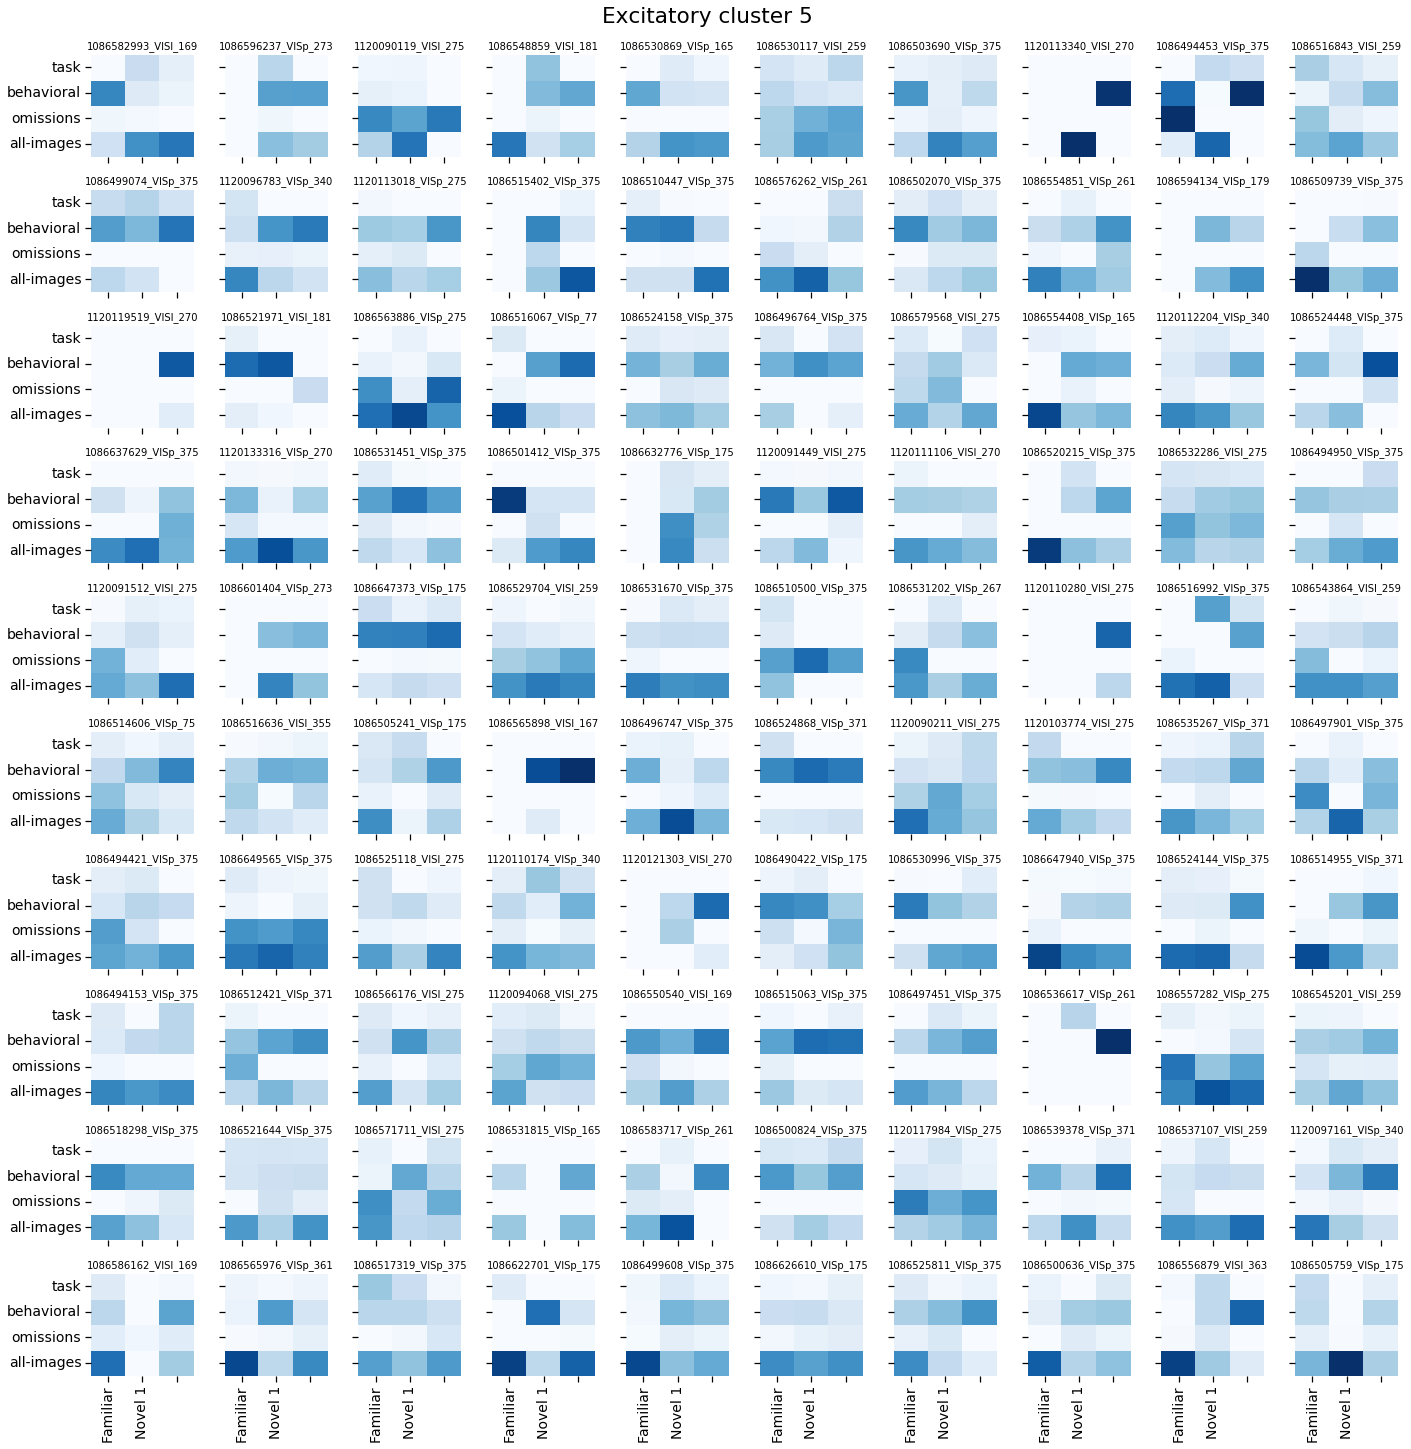

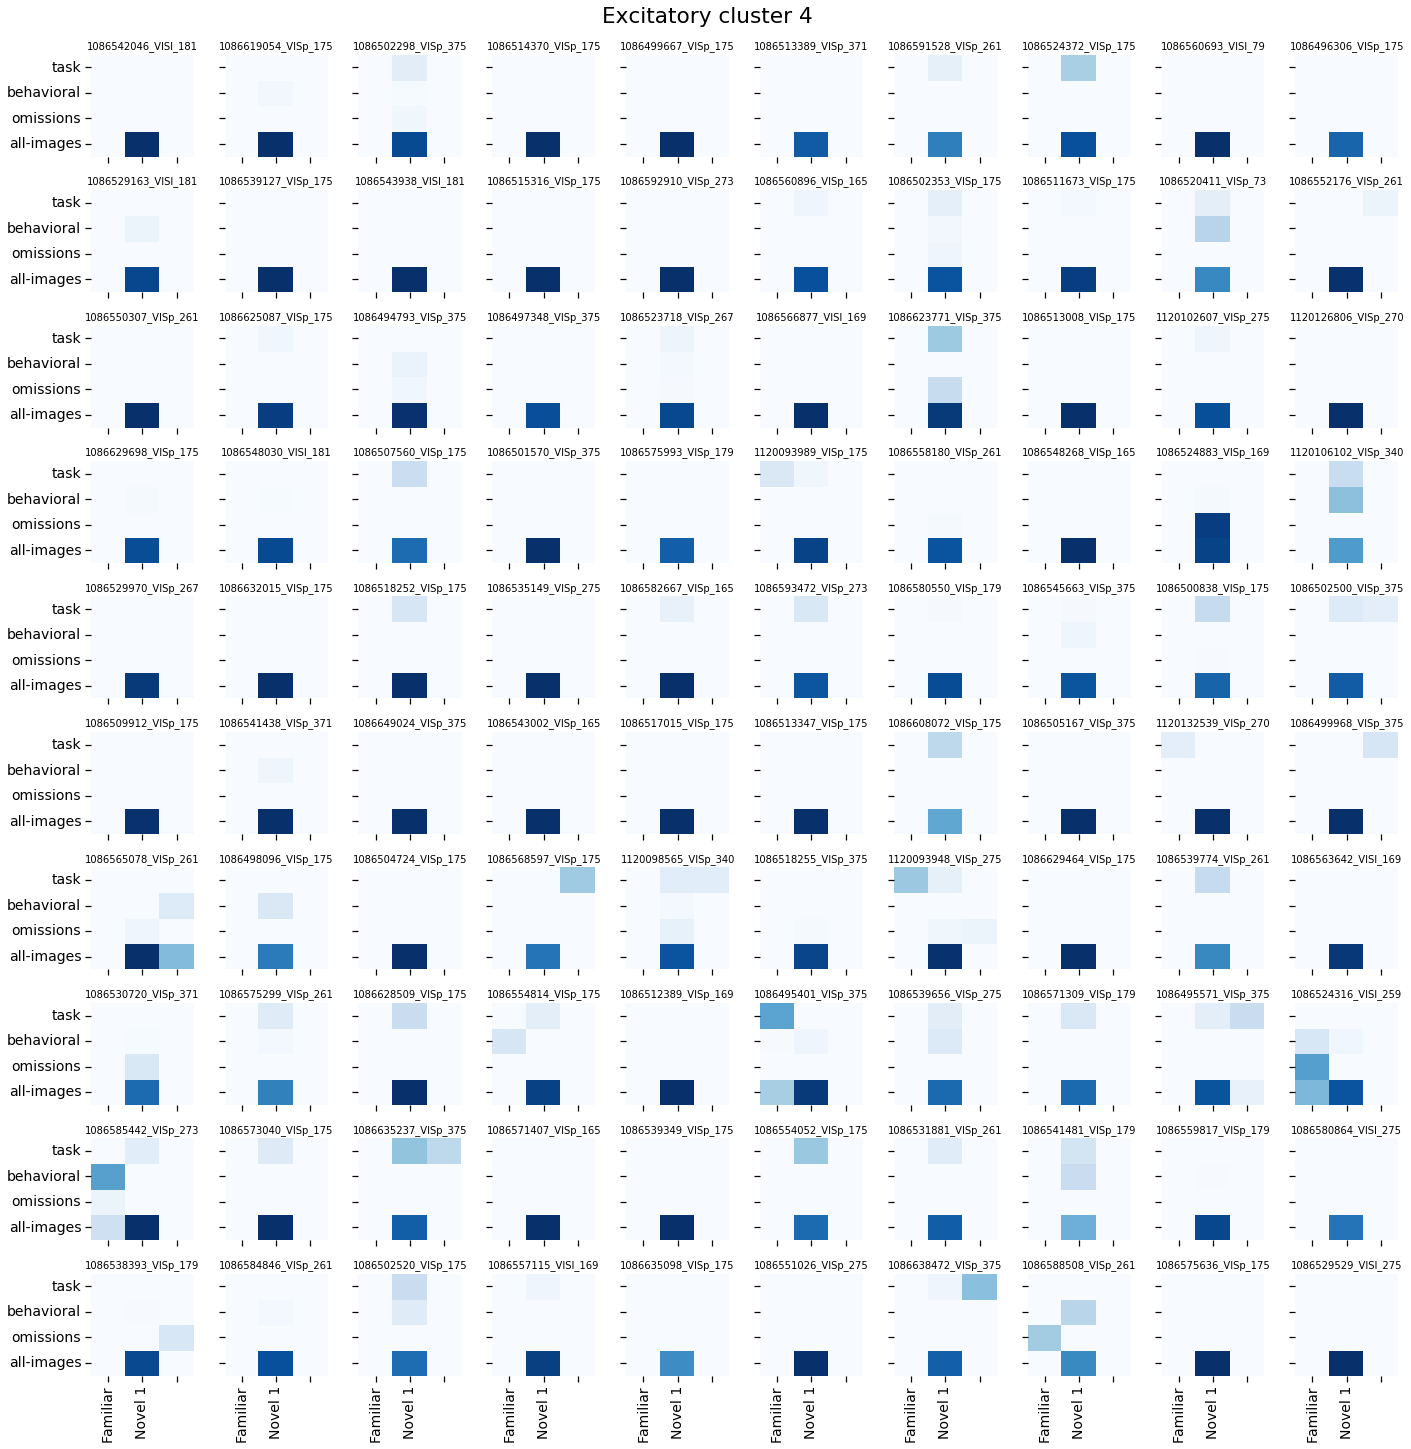

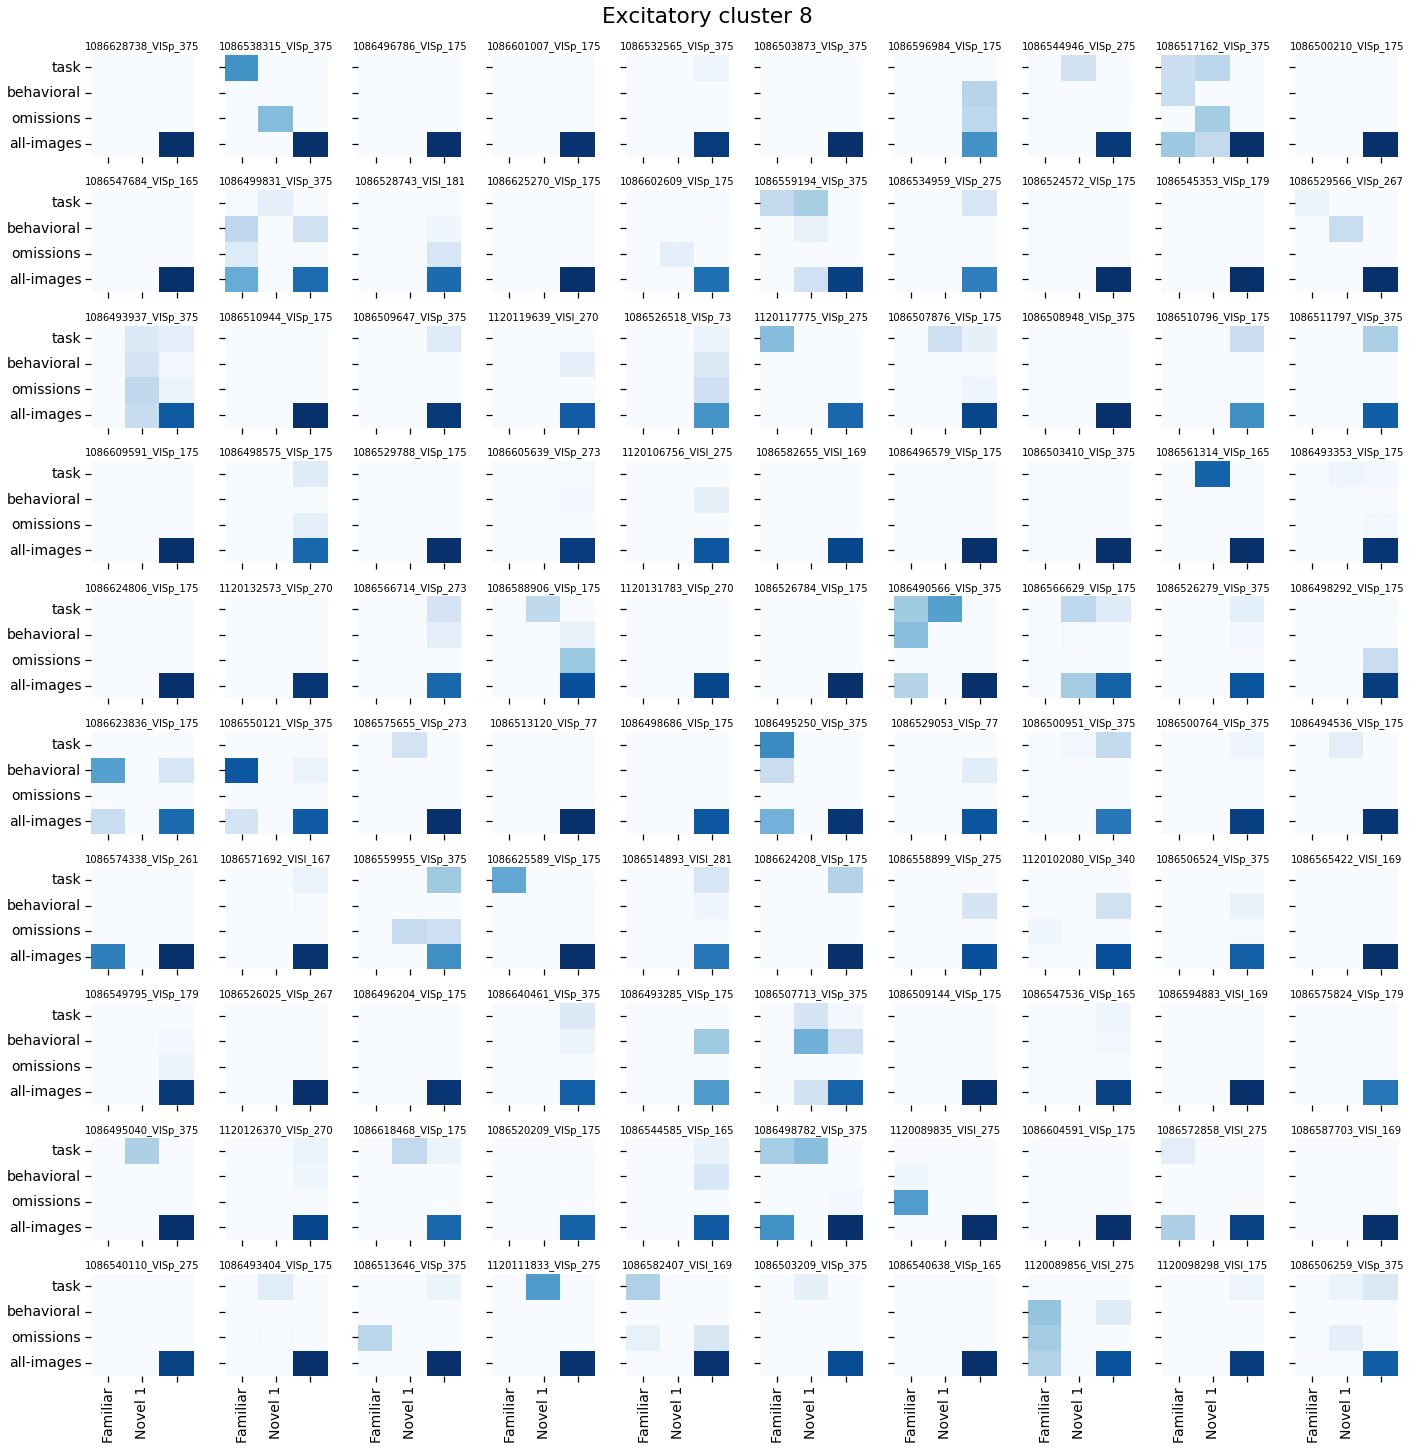

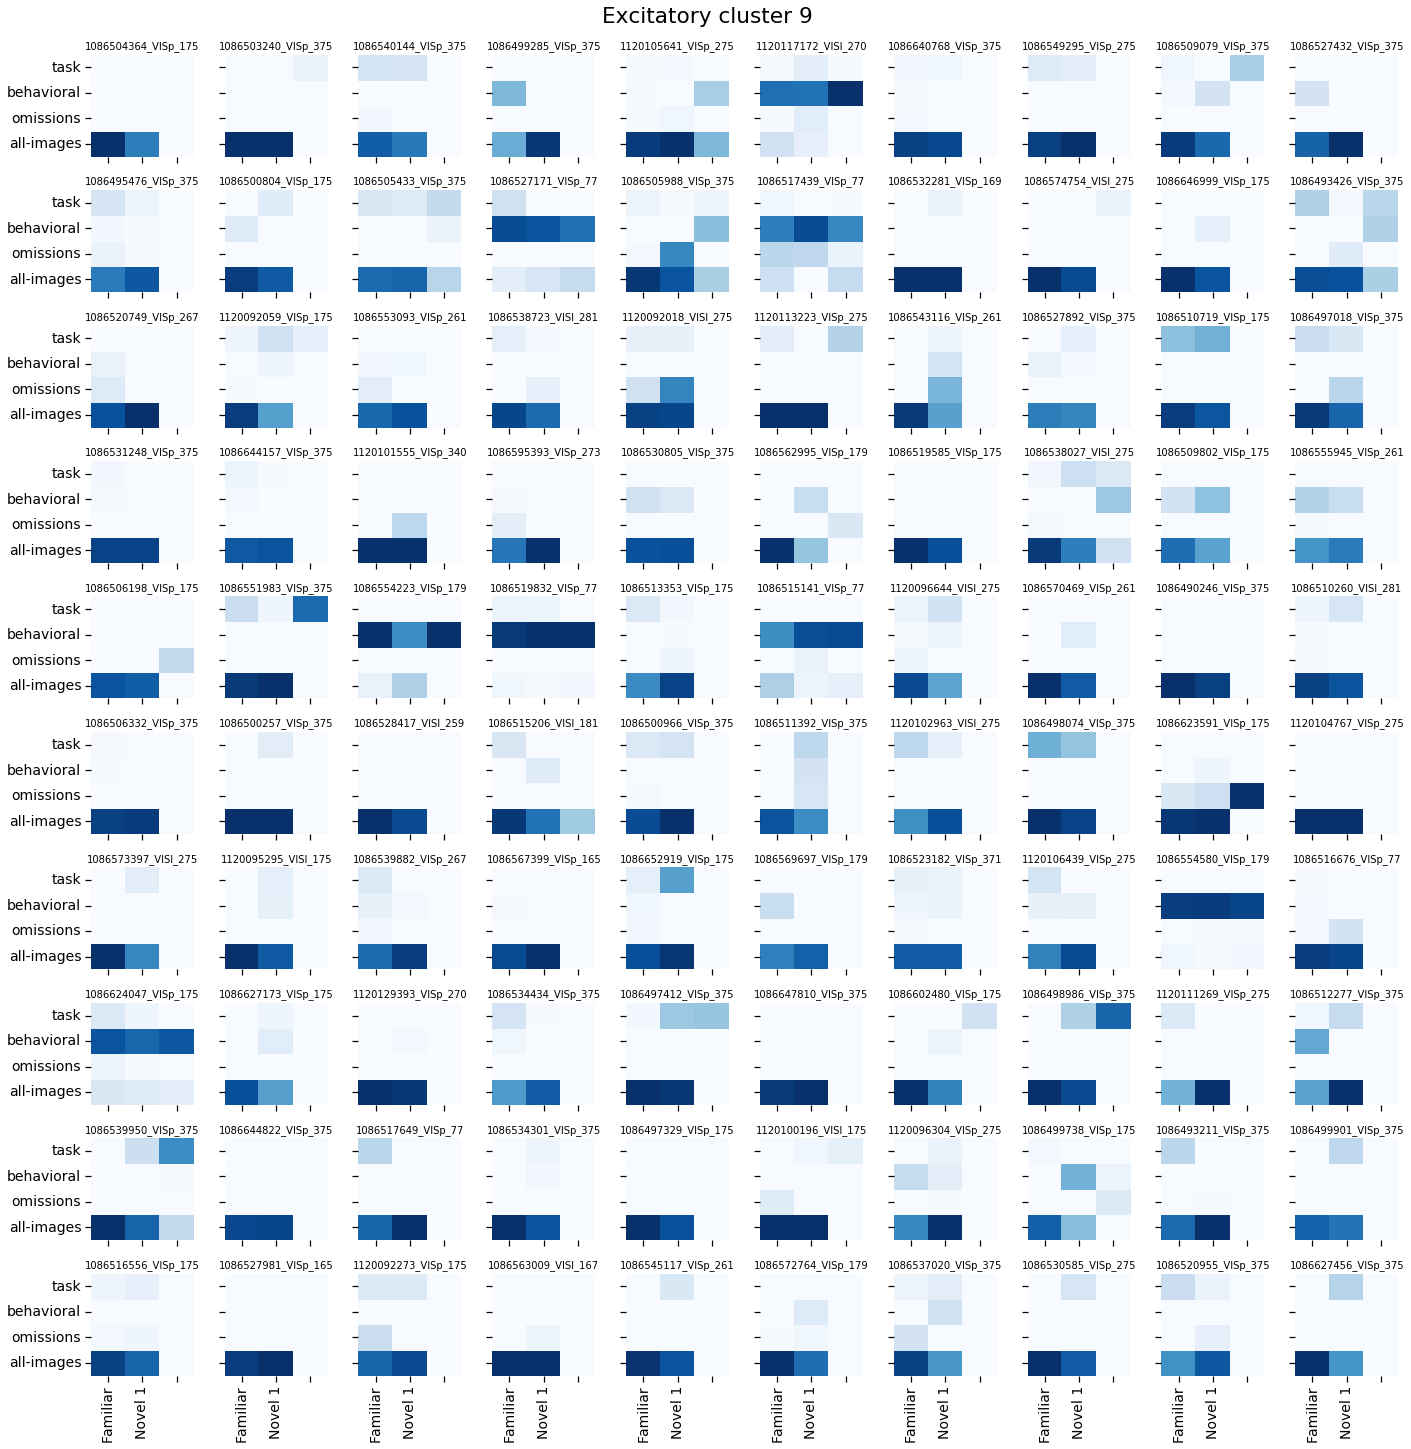

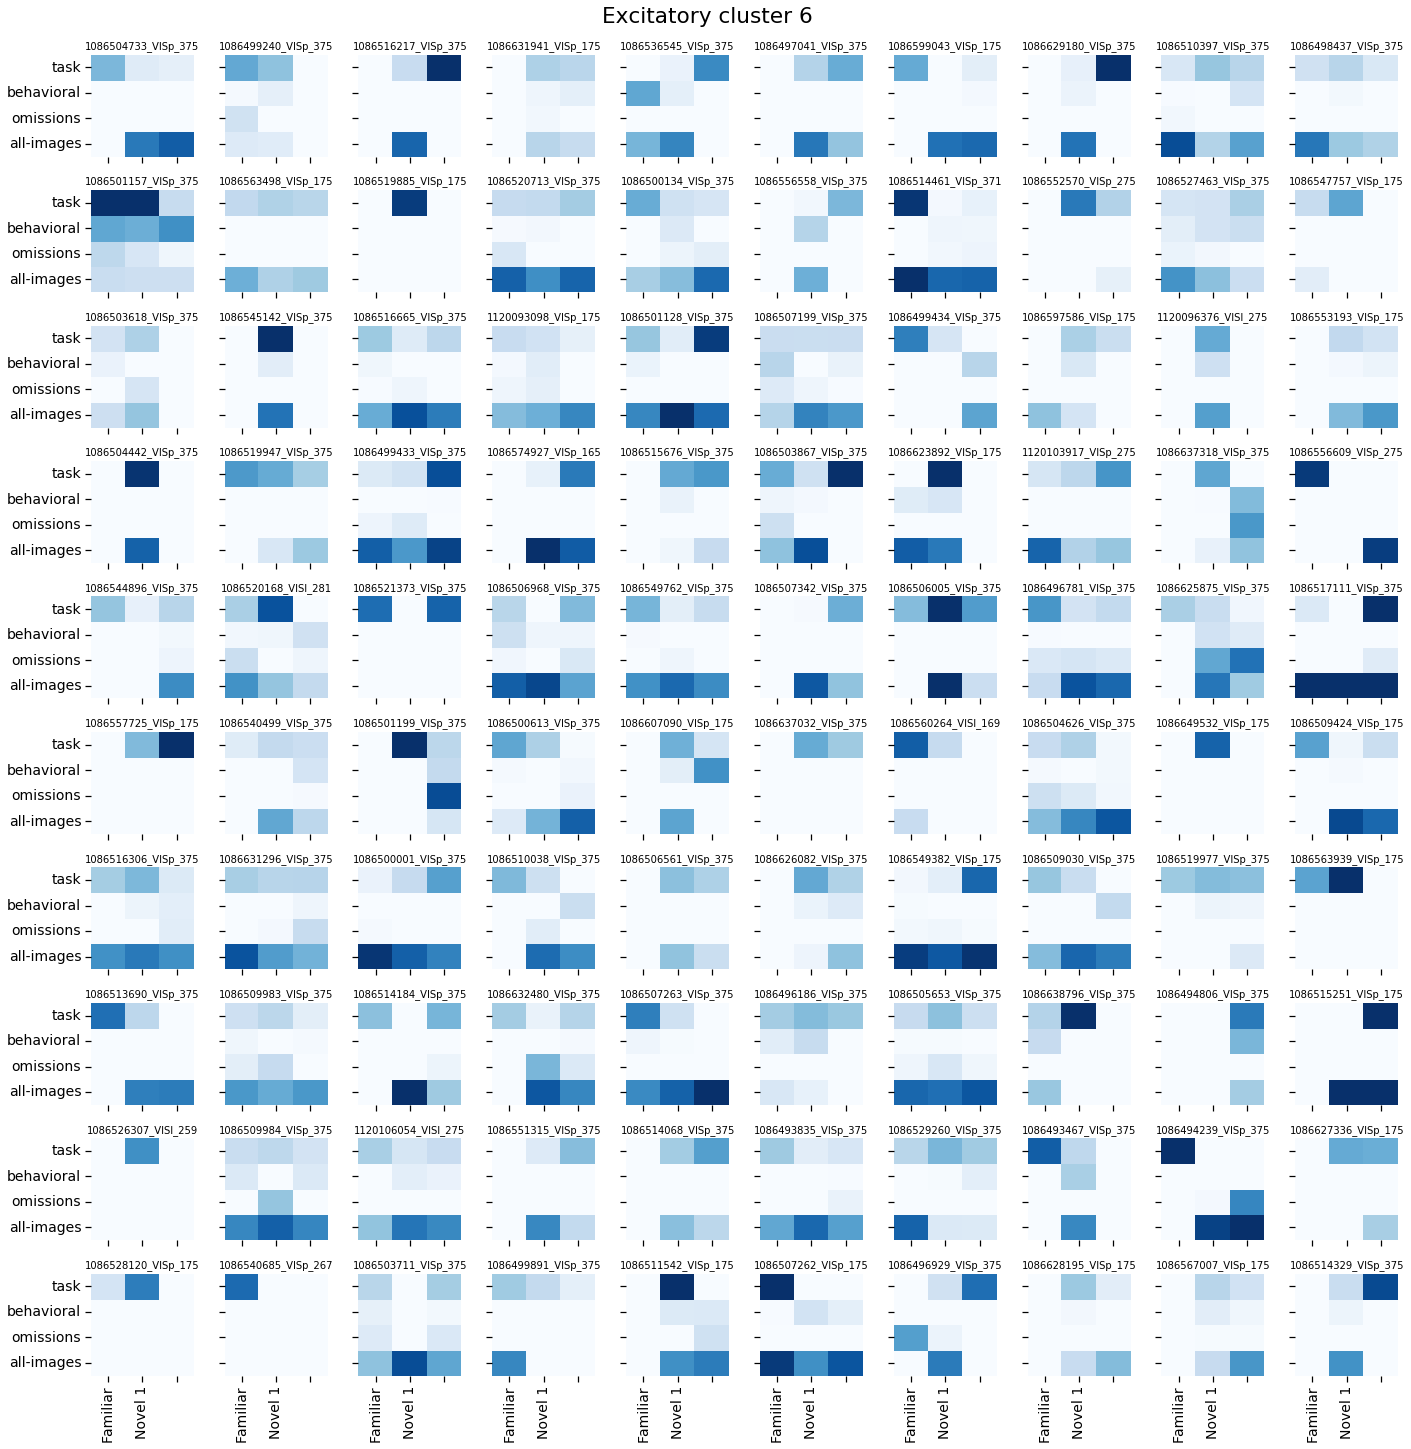

In [49]:
plotting.plot_random_subset_of_cells_per_cluster(cluster_meta, dropouts, save_dir)

### breakdown by area and depth

We are going to normalize within each area or depth to account for the large imbalance in N due to Scientifica datasets only being performed in V1 at certain depths, as well as biological variation in cell type specific expression by depth

### plot fraction cells by area and depth

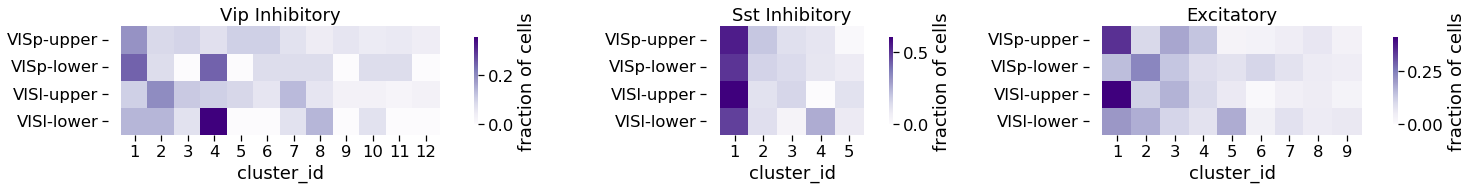

In [50]:
label = 'fraction of cells'
plotting.plot_fraction_cells_by_area_depth(cluster_meta, n_clusters_cre, normalize=True, label=label, 
                                           save_dir=base_dir, folder=folder)

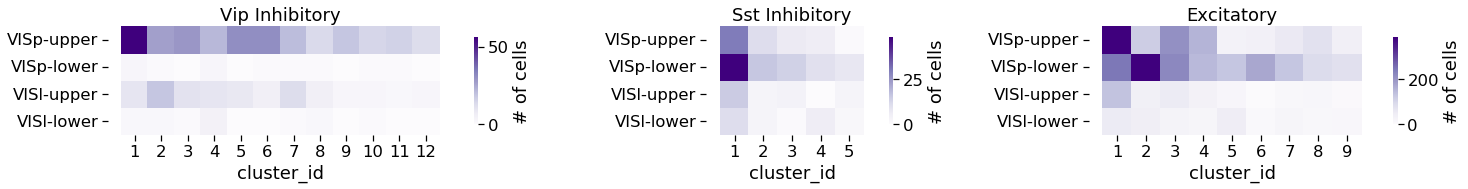

In [51]:
label = '# of cells'
plotting.plot_fraction_cells_by_area_depth(cluster_meta, n_clusters_cre, normalize=False, label=label, 
                                           save_dir=base_dir, folder=folder)

### compute % cells per area / depth relative to chance

to deal with uneven sampling across areas & depths, we will express the fraction of cells per cluster in each area & depth as a percentage relative to chance. We can compute the expected number of cells per area and depth in each cluster based on random sampling of our area/depth distribution, then compute how many cells are actually in each area and depth per cluster and express that as a % relative to chance

To compute the expected number of cells in each cluster based on sampling: 
    * take size of cluster (n_neurons) and select a random set of cells of that size
    * repeat 100x to get a distribution of random cells
    * compute the number of cells in each area and depth in the random distribution
    * quantify how many cells are actually in each area and depth in the clustered data
    * compute significance of actual # cells relative to random distrubution 
    * report % cells relative to chance and p_value
    

In [52]:
cell_count_stats = processing.get_cell_count_stats(cluster_meta, conditions_to_groupby = ['targeted_structure', 'layer'])

In [53]:
cell_count_stats.head()[cell_count_stats.keys()[:16]]

targeted_structure  layer           cre_line  n_cells_total_cre  \
0               VISl  lower  Slc17a7-IRES2-Cre               3302   
1               VISl  upper  Slc17a7-IRES2-Cre               3302   
2               VISp  lower  Slc17a7-IRES2-Cre               3302   
3               VISp  upper  Slc17a7-IRES2-Cre               3302   
0               VISl  lower  Slc17a7-IRES2-Cre               3302   

   n_cells_cond_cre  fraction_per_cond_cre  cluster_id  n_cells_total_cluster  \
0               263               0.079649           1                    816   
1               328               0.099334           1                    816   
2              1600               0.484555           1                    816   
3              1111               0.336463           1                    816   
0               263               0.079649           2                    585   

   n_cells_cond_cluster  fraction_per_cond_cluster  n_cells  \
0                    55                   0.067402       55   
1                   134                   0.164216      134   
2                   244                   0.299020      244   
3                   383                   0.469363      383   
0                    46                   0.078632       46   

                                      random_n_cells  random_n_cells_mean  \
0  [68, 71, 67, 71, 68, 61, 67, 58, 55, 58, 66, 6...                65.87   
1  [74, 70, 77, 83, 86, 75, 78, 84, 77, 89, 82, 7...                80.24   
2  [381, 388, 396, 360, 392, 419, 406, 408, 414, ...               395.14   
3  [293, 287, 276, 302, 270, 261, 265, 266, 270, ...               274.75   
0  [37, 52, 45, 41, 41, 34, 47, 45, 41, 42, 46, 5...                46.56   

   fraction_of_random  relative_to_random  n_times_actual_greater_than_random  
0            0.834978           -0.165022                                 4.0  
1            1.669990            0.669990                               100.0  
2            0.617503           -0.382497                                 0.0  
3            1.393995            0.393995                               100.0  
0            0.987973           -0.012027                                41.0

In [54]:
# save stats
cell_count_stats.to_csv(os.path.join(save_dir, 'cell_count_stats.csv'))

### heatmap of % rel chance

#### fraction of cells relative to random distribution

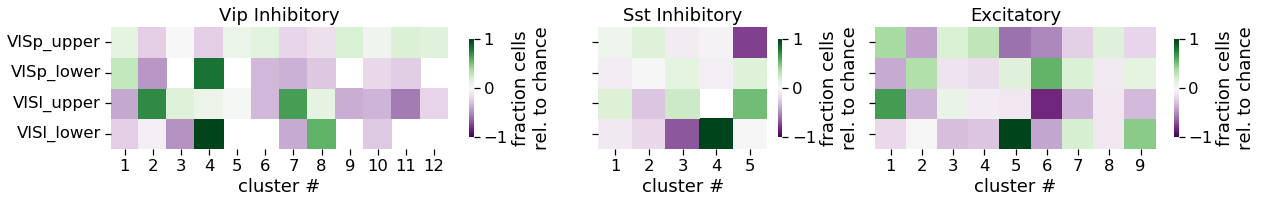

In [55]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_limited_range'

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre, 
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-1, vmax=1, 
                                                      cluster_order=None, suffix=suffix, save_dir=base_dir, folder=folder)

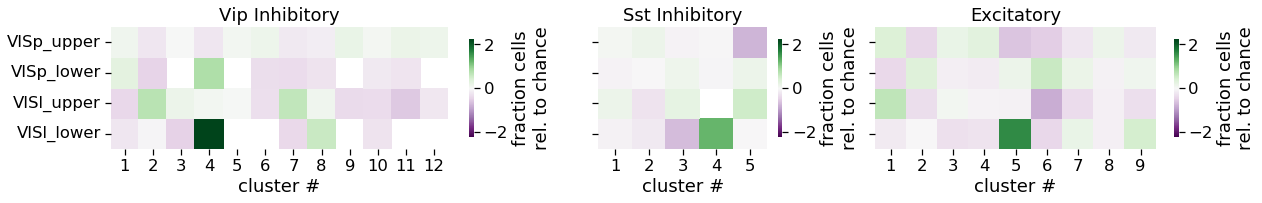

In [56]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_full_range'

vmax = cell_count_stats.relative_to_random.max()
vmin = cell_count_stats.relative_to_random.min()

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre, 
                                             value_to_plot, cbar_label, cmap='PRGn', vmin=-vmax, vmax=vmax, 
                                             cluster_order=None, save_dir=base_dir, folder=folder, suffix=suffix)

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1213: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  ax[i] = sns.heatmap(data.T, vmin=vmin, vmax=vmax, cmap=cmap, ax=ax[i],


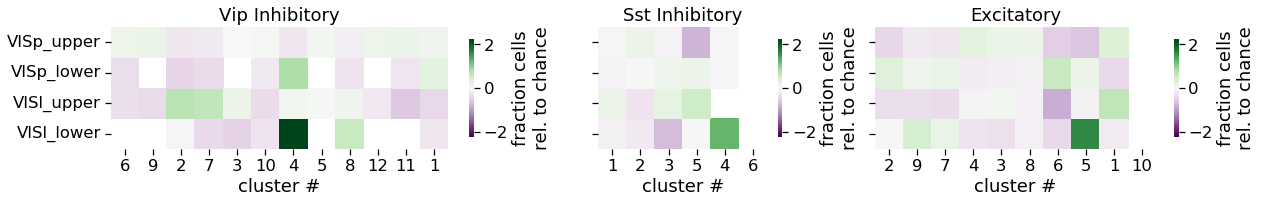

In [57]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_full_range_manual_sort_order'

vmax = cell_count_stats.relative_to_random.max()
vmin = cell_count_stats.relative_to_random.min()

cluster_order = processing.get_manual_sort_order()

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre,
                                             value_to_plot, cbar_label, cmap='PRGn', vmin=-vmax, vmax=vmax, 
                                             cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

### sort clusters by the fraction of cells in VISp upper

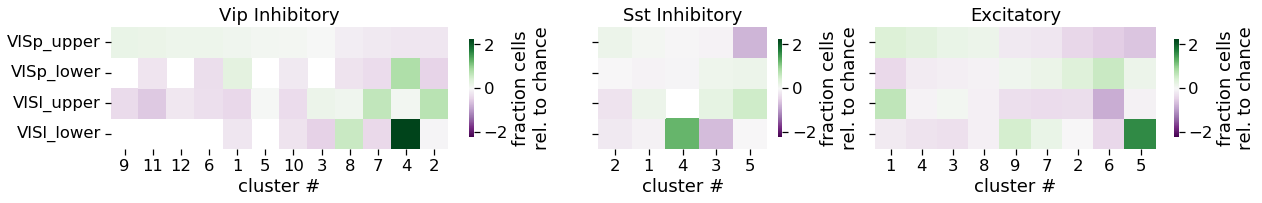

In [58]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_full_range_VISp_upper_sort'

vmax = cell_count_stats.relative_to_random.max()
vmin = cell_count_stats.relative_to_random.min()

cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, 
                                                                 location='VISp_upper', metric='relative_to_random')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre,
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-vmax, vmax=vmax, 
                                                      cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

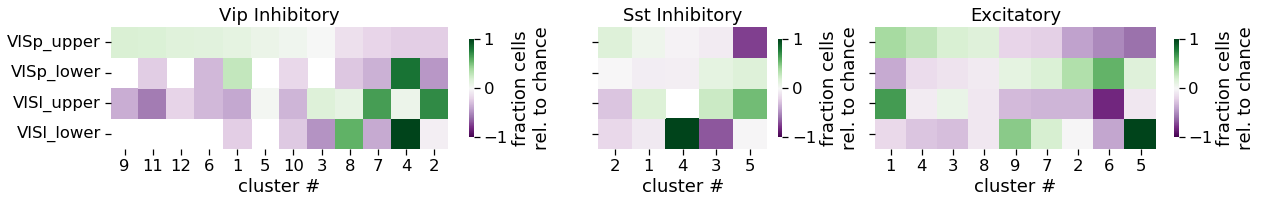

In [59]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_limited_range_VISp_upper_sort'

cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, 
                                                                 location='VISp_upper', metric='relative_to_random')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre,
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-1, vmax=1, 
                                                      cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

### plot dropouts in this order

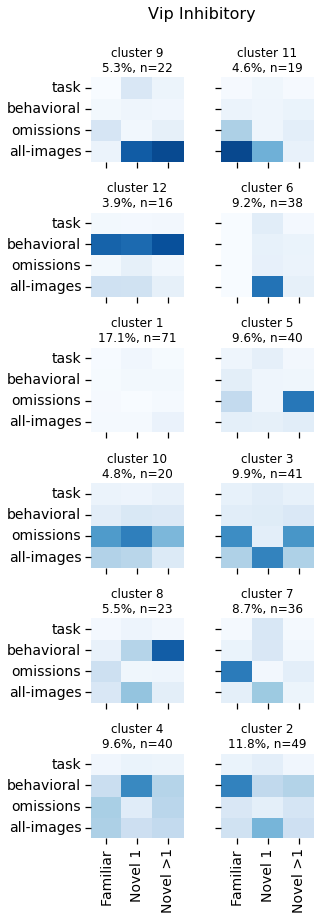

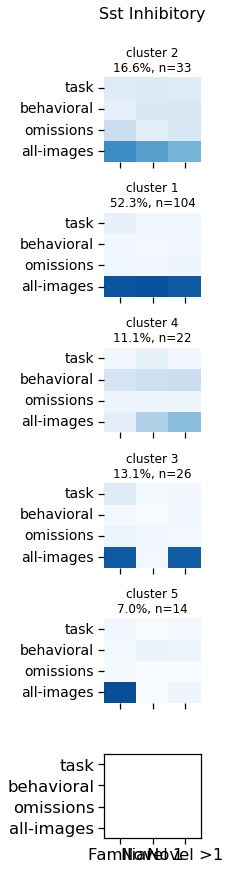

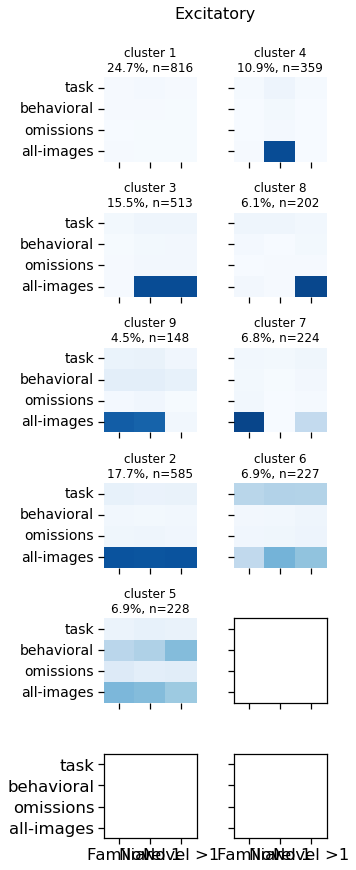

In [60]:
plotting.plot_dropout_heatmaps_for_clusters_sorted(cluster_meta, feature_matrix, cluster_order=cluster_order, 
                                       save_dir=base_dir, folder=folder, sort_type='VISp_upper_pct_rel_chance')

### try for just V1 vs LM or upper vs lower

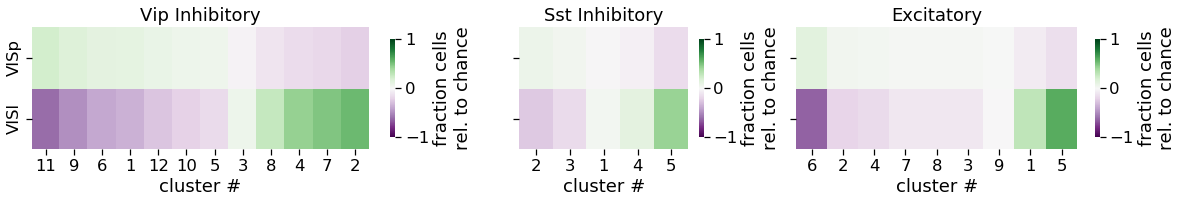

In [61]:
cell_count_stats_area = processing.get_cell_count_stats(cluster_meta, conditions_to_groupby = ['targeted_structure'])

value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_limited_range_area_sort'

cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats_area, cluster_meta, 
                                                                 location='VISp', metric='relative_to_random')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats_area, n_clusters_cre,
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-1, vmax=1, 
                                                      cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

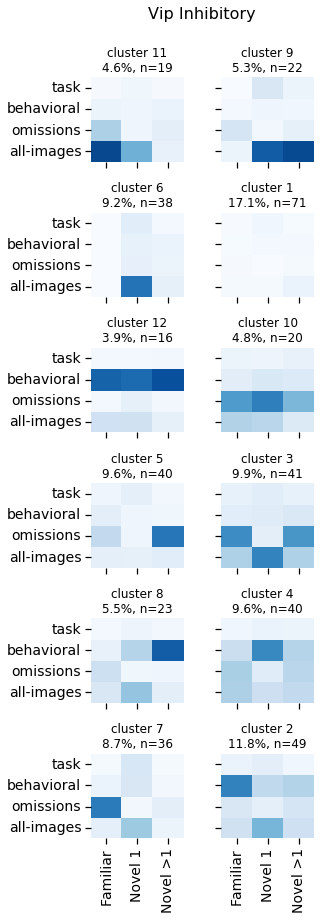

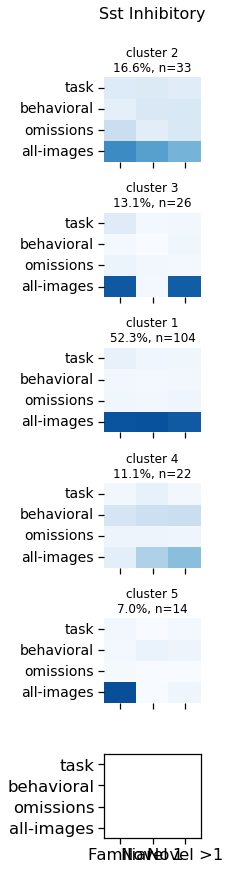

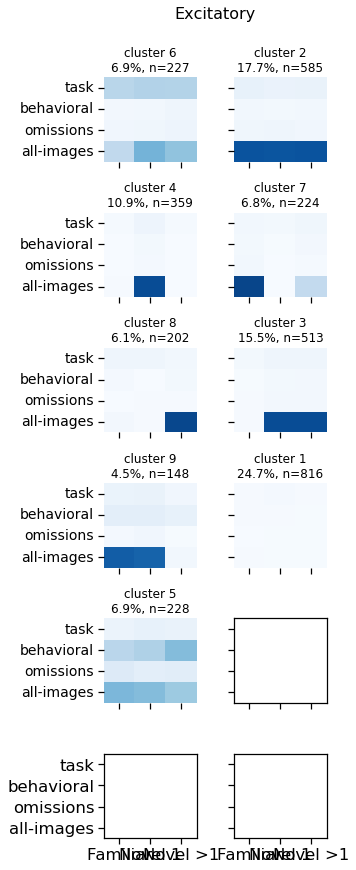

In [62]:
plotting.plot_dropout_heatmaps_for_clusters_sorted(cluster_meta, feature_matrix, cluster_order=cluster_order, 
                                       save_dir=base_dir, folder=folder, sort_type='area_sort')

### depths

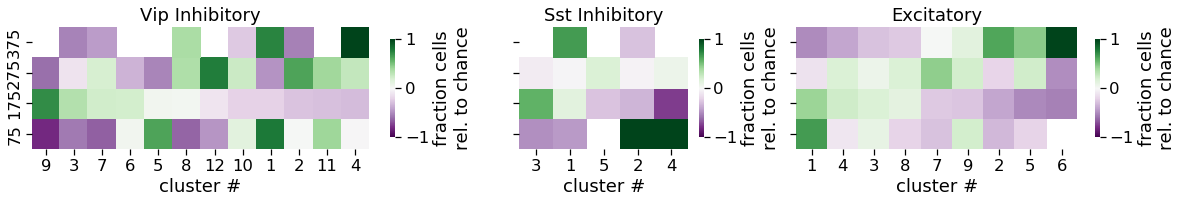

In [63]:
cell_count_stats_area = processing.get_cell_count_stats(cluster_meta, conditions_to_groupby = ['binned_depth'])

value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_limited_range_binned_depth_sort'

cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats_area, cluster_meta, 
                                                                 location=175, metric='relative_to_random')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats_area, n_clusters_cre,
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-1, vmax=1, 
                                                      cluster_order=cluster_order, save_dir=base_dir, folder=folder, 
                                                      suffix=suffix)

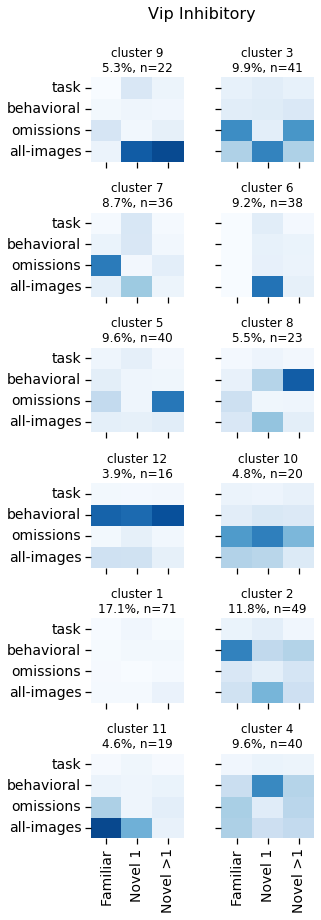

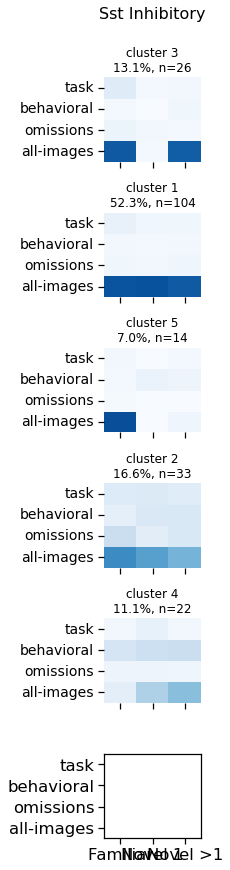

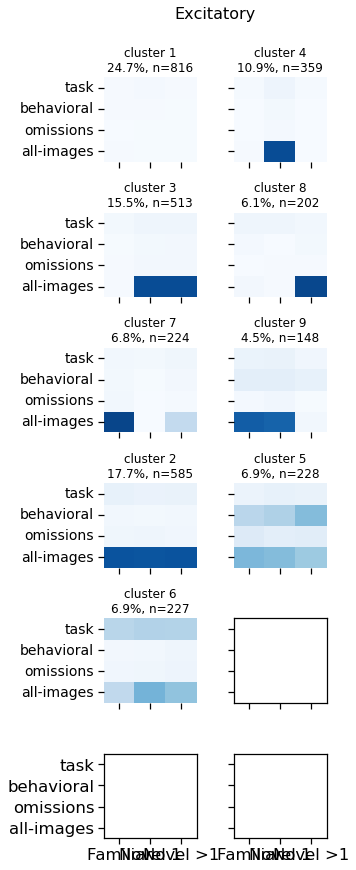

In [64]:
plotting.plot_dropout_heatmaps_for_clusters_sorted(cluster_meta, feature_matrix, cluster_order=cluster_order, 
                                       save_dir=base_dir, folder=folder, sort_type='binned_depth_sort')

### layers

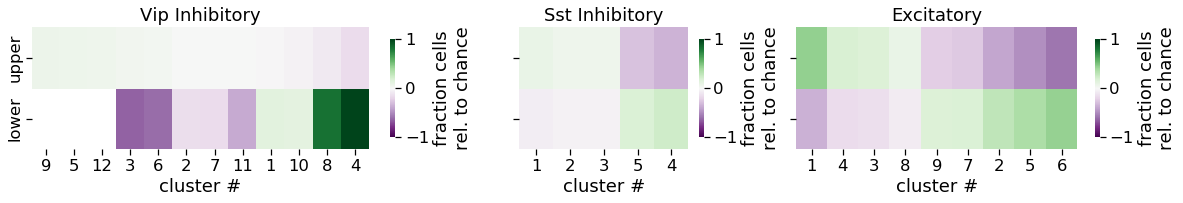

In [65]:
cell_count_stats_area = processing.get_cell_count_stats(cluster_meta, conditions_to_groupby = ['layer'])

value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_limited_range_layer_sort'

cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats_area, cluster_meta, 
                                                                 location='upper', metric='relative_to_random')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats_area, n_clusters_cre,
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-1, vmax=1, 
                                                      cluster_order=cluster_order, save_dir=base_dir, folder=folder, 
                                                      suffix=suffix)

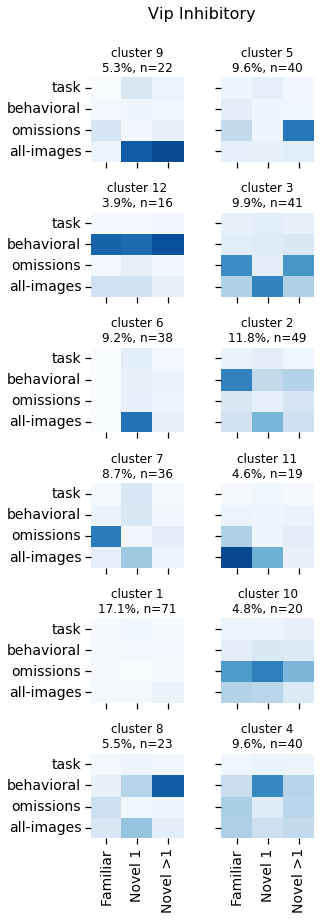

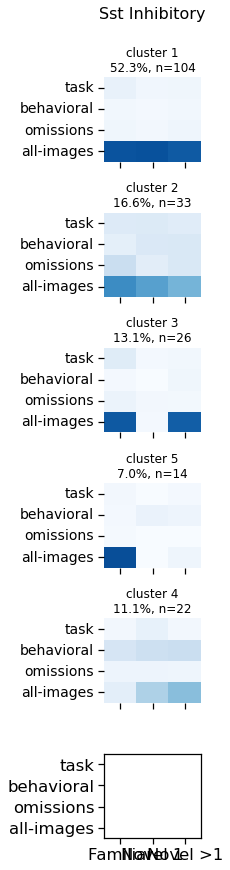

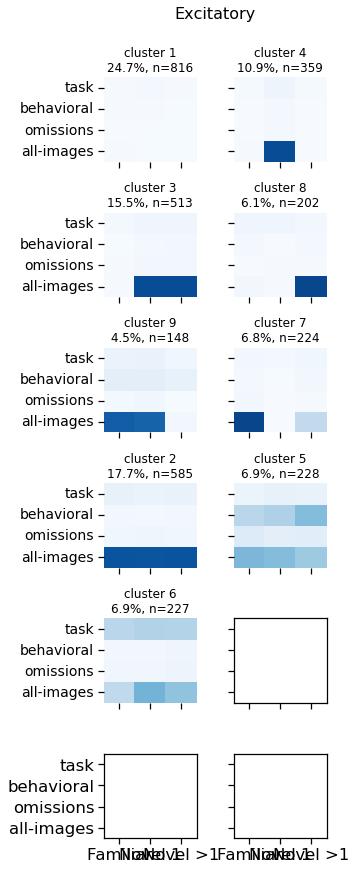

In [66]:
plotting.plot_dropout_heatmaps_for_clusters_sorted(cluster_meta, feature_matrix, cluster_order=cluster_order, 
                                       save_dir=base_dir, folder=folder, sort_type='upper_pct_rel_chance')

### test plot components then plot clusters with other information as additional panels 

### plot clusters with % cells per area and depth

In [67]:
fraction_cells = processing.get_fraction_cells_per_area_depth(cluster_meta)
cre_fraction = fraction_cells[fraction_cells.cre_line==cre_line]

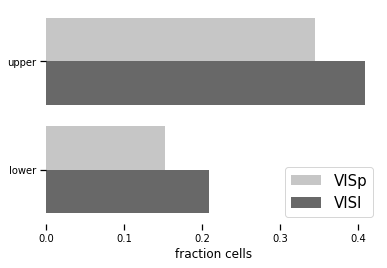

In [69]:
plotting.plot_fraction_cells_per_area_depth(cre_fraction, cluster_id=1, ax=None)

### get relevant data and plot clusters with fractions

In [70]:
cell_count_stats = processing.get_cell_count_stats(cluster_meta)
cre_counts = cell_count_stats[cell_count_stats.cre_line==cre_line]

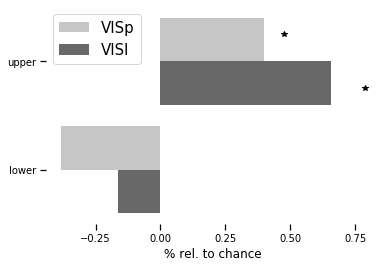

In [73]:
cluster_id = 1
plotting.plot_pct_rel_to_chance_for_cluster(cre_counts, cluster_id, ax=None)

### population average trace

In [74]:
# load dataframe with response traces
df_name = 'omission_response_df'
conditions = ['cell_specimen_id', 'omitted']

data_type = 'events'
event_type = 'omissions'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'


multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)
print(len(multi_session_df.ophys_experiment_id.unique()))

there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels
402


In [75]:
cluster_mdf = multi_session_df.merge(cluster_meta[['cluster_id']], 
                                     on='cell_specimen_id', how = 'inner')

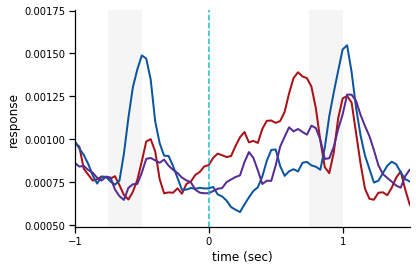

In [77]:
plotting.plot_population_average_response_for_cluster(cluster_mdf, cre_line, cluster_id, change=False, omitted=True, ax=None)

### plot clusters, fraction per area depth, and pop avgs as rows

In [78]:
# get fraction cells relative to chance per cluster per cre_line
cell_count_stats = processing.get_cell_count_stats(cluster_meta)
# get fraction of cells per area/depth per cluster per cre_line 
fraction_cells = processing.get_fraction_cells_per_area_depth(cluster_meta)

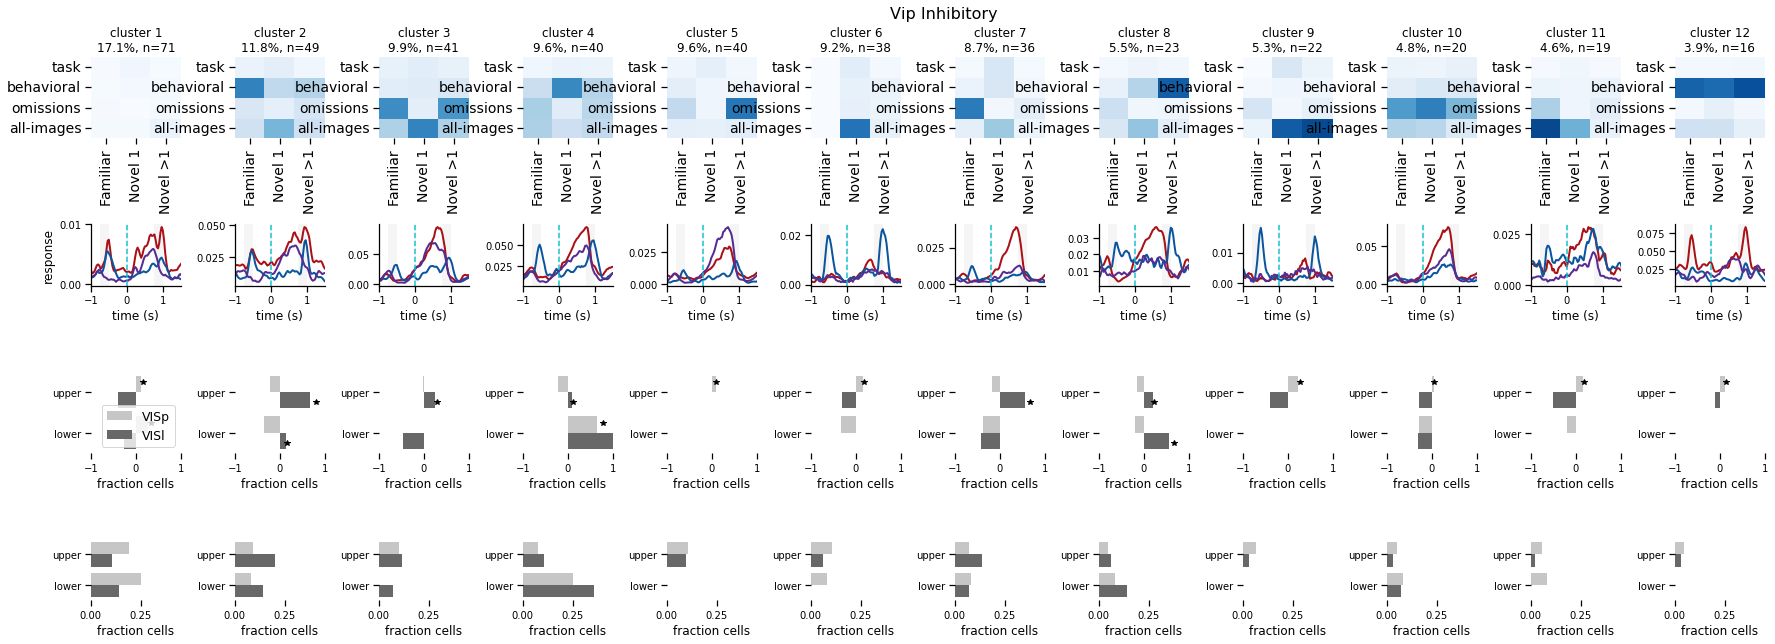

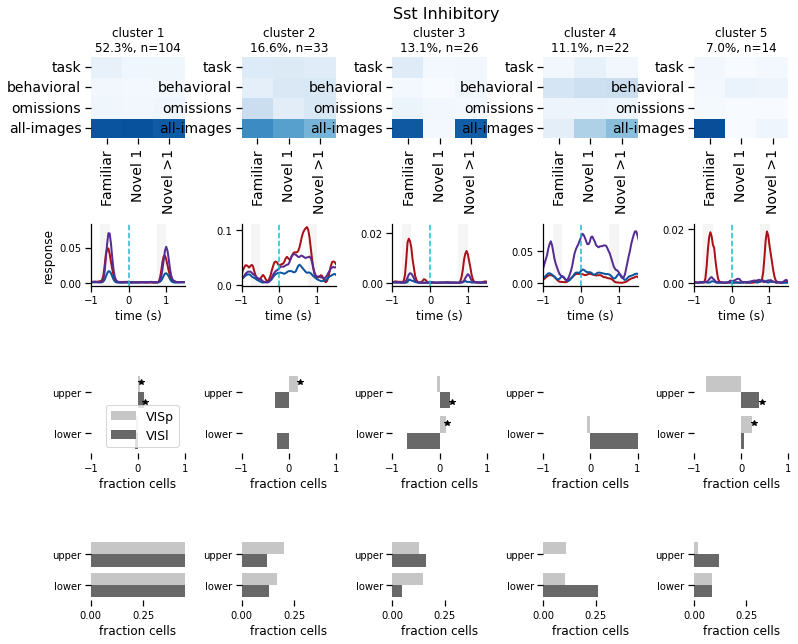

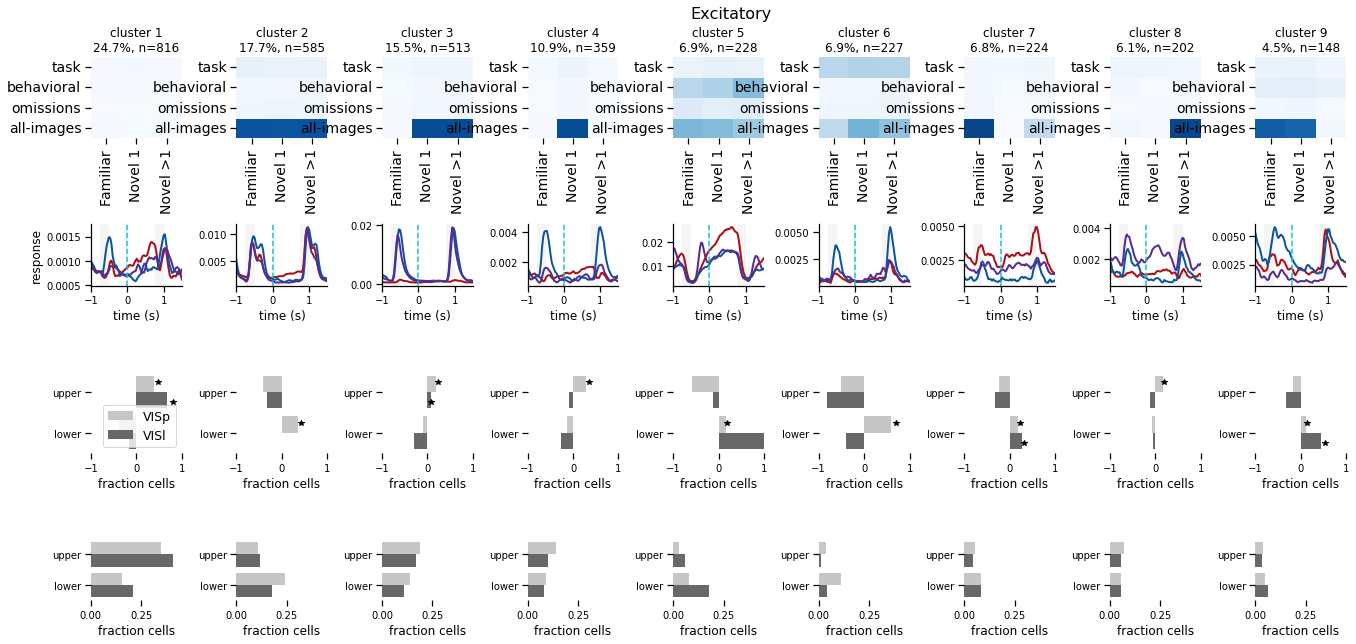

In [79]:
for cre_line in cre_lines: 
    plotting.plot_clusters_stats_pop_avg_rows(cluster_meta, feature_matrix, multi_session_df,
                                              cell_count_stats, fraction_cells, cre_line, 
                                              sort_order=None, suffix='_size_order', 
                                              save_dir=base_dir, folder=folder, )

### use manual sort order

In [80]:
# manual_sort_order = processing.get_manual_sort_order()

# for cre_line in cre_lines: 
#     plotting.plot_clusters_stats_pop_avg_rows(cluster_meta, feature_matrix, multi_session_df,
#                                               cell_count_stats, fraction_cells, cre_line, 
#                                               sort_order=manual_sort_order, suffix='_manual_sort', 
#                                               save_dir=base_dir, folder=folder, )

### sort by visp upper 

In [81]:
# get fraction cells relative to chance per cluster per cre_line
cell_count_stats = processing.get_cell_count_stats(cluster_meta)
# get fraction of cells per area/depth per cluster per cre_line 
fraction_cells = processing.get_fraction_cells_per_area_depth(cluster_meta)

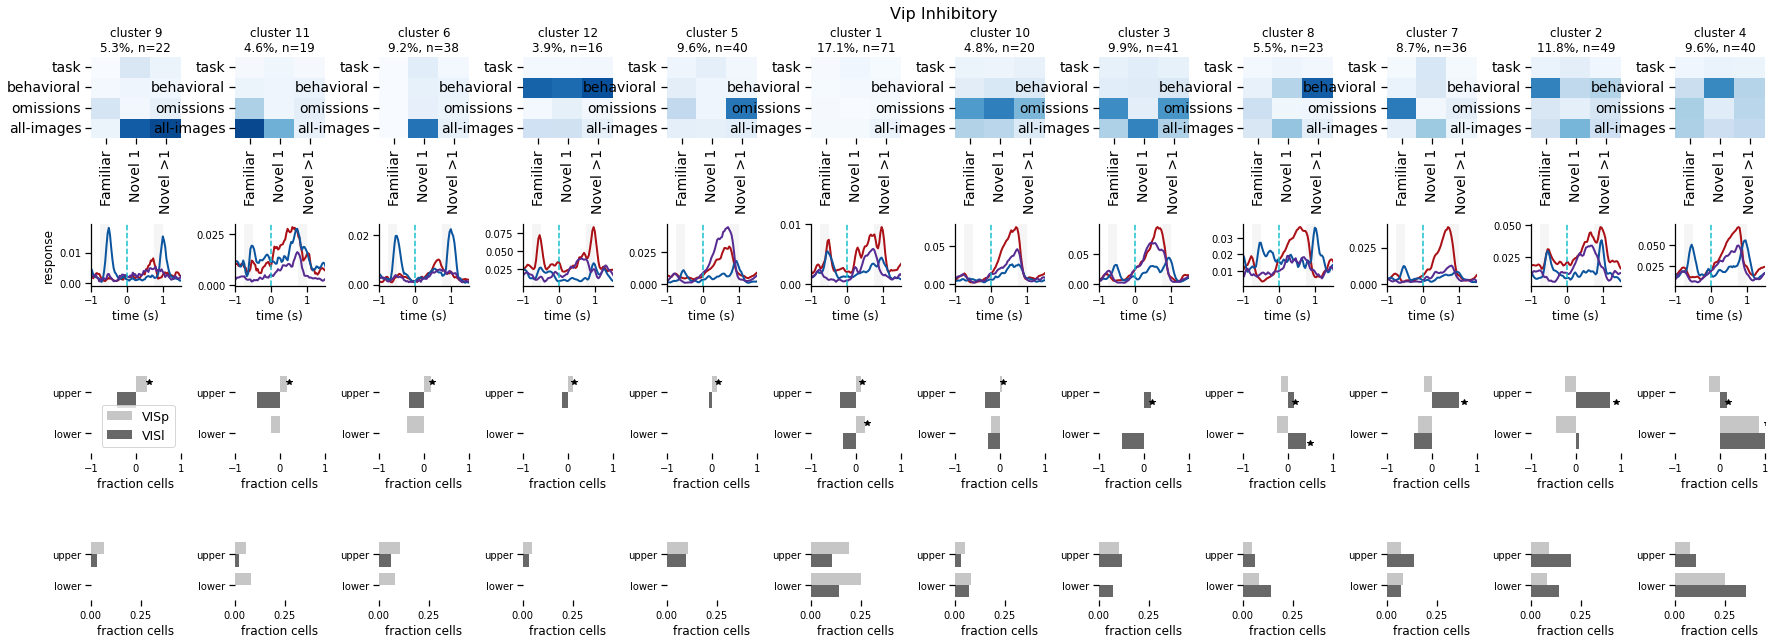

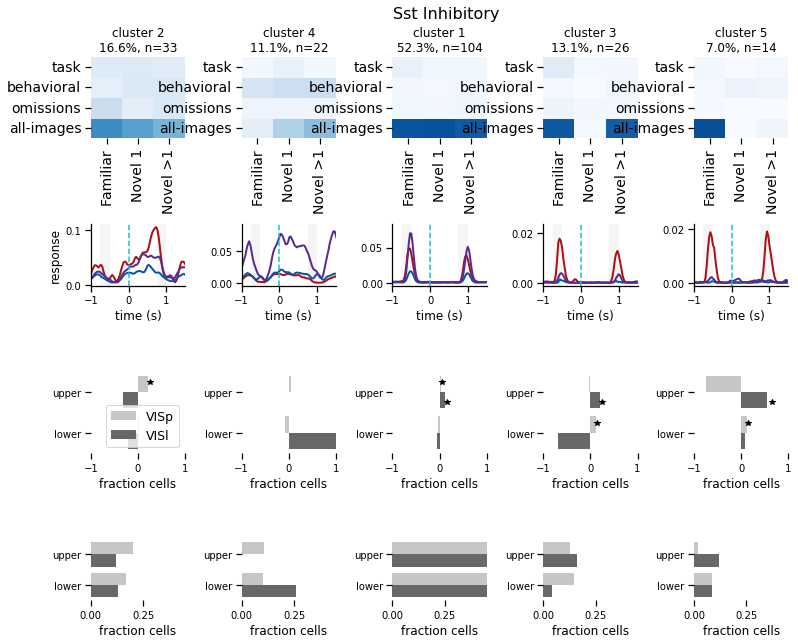

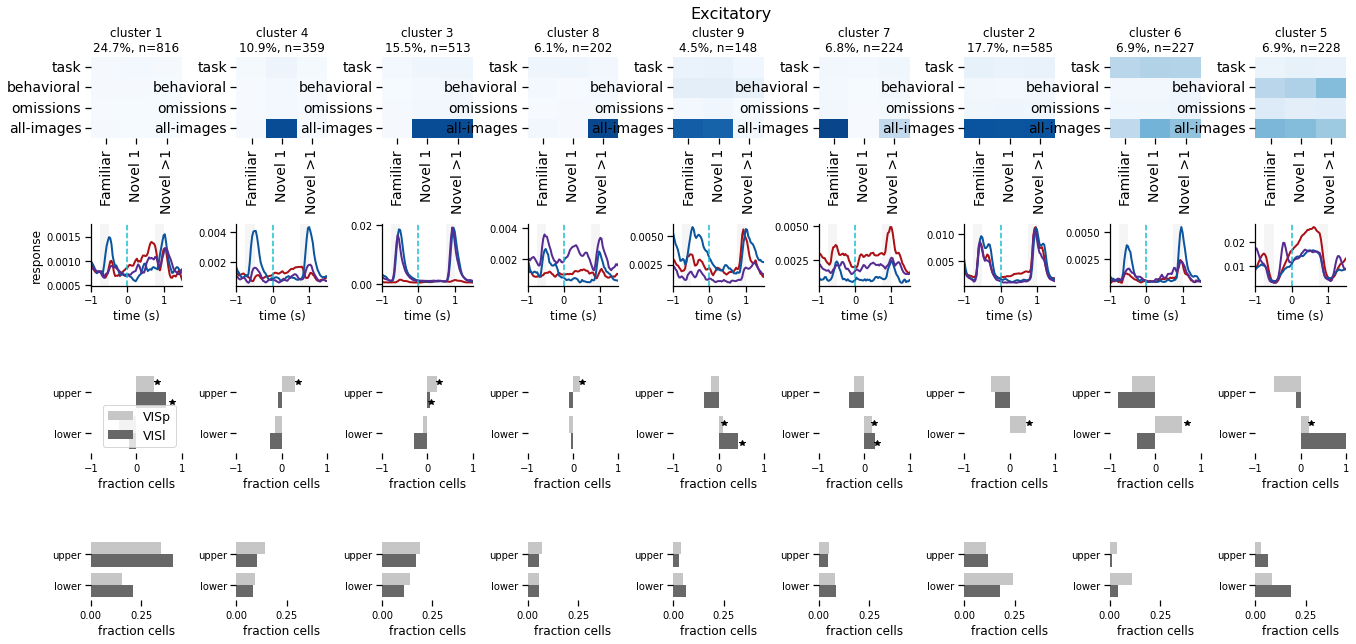

In [82]:
cell_count_stats['location'] = cell_count_stats.targeted_structure+'_'+cell_count_stats.layer
cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, location='VISp_upper', metric='relative_to_random')  

for cre_line in cre_lines: 
    plotting.plot_clusters_stats_pop_avg_rows(cluster_meta, feature_matrix, multi_session_df,
                                              cell_count_stats, fraction_cells, cre_line, 
                                              sort_order=cluster_order, suffix='_VISp_upper_sort', 
                                              save_dir=base_dir, folder=folder, )

### sort by V1 vs LM order

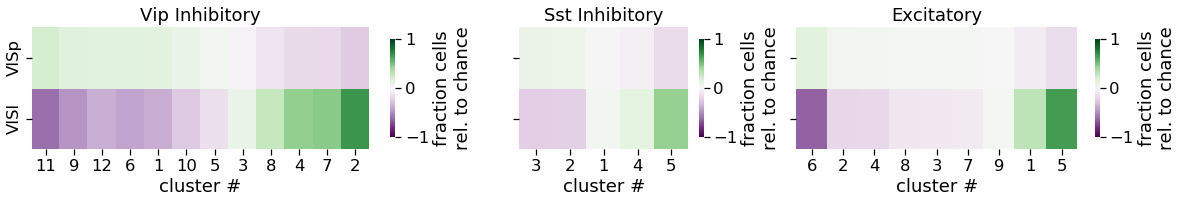

In [83]:
cell_count_stats_area = processing.get_cell_count_stats(cluster_meta, conditions_to_groupby = ['targeted_structure'])

value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_limited_range_area_sort'

cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats_area, cluster_meta, 
                                                                 location='VISp', metric='relative_to_random')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats_area, n_clusters_cre,
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-1, vmax=1, 
                                                      cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

In [84]:
# cell_count_stats_area['location'] = cell_count_stats_area.targeted_structure
# # need to have both a 'layer' and 'targeted_structure' column for plot to work
# cell_count_stats_area['layer'] = cell_count_stats_area.targeted_structure

# cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats_area, cluster_meta, 
#                                                                  location='VISp', metric='relative_to_random')  

# for cre_line in cre_lines: 
#     plotting.plot_clusters_stats_pop_avg_rows(cluster_meta, feature_matrix, multi_session_df,
#                                               cell_count_stats_area, fraction_cells, cre_line, 
#                                               sort_order=cluster_order, suffix='_area_sort', 
#                                               save_dir=base_dir, folder=folder, )

### plot as columns

In [85]:
# for cre_line in cre_lines: 
#     plotting.plot_clusters_stats_pop_avg_cols(cluster_meta, feature_matrix, multi_session_df,
#                                               cell_count_stats, fraction_cells, cre_line, 
#                                               sort_order=cluster_order, suffix='_VISp_upper_sort', 
#                                               save_dir=base_dir, folder=folder, )

### within cluster correlations sorted by VISp upper

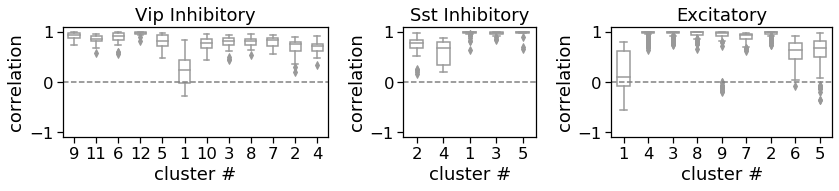

In [86]:
sort_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, location='VISp_upper', metric='relative_to_random')  

plotting.plot_within_cluster_correlations_all_cre(cluster_meta, n_clusters_cre, sort_order=sort_order, 
                                                  suffix='_VISp_upper_sort', save_dir=base_dir, folder=folder)


## Compute selectivity metrics on dropout scores

### define stats

### compute stats across cells 

* positive value of exp_mod_direction means stronger coding of pref feature in novel session 
* positive value of exp_mod_persistence means similar coding in Novel 1 and Novel >1 for pref feature
* high value of feature_sel_within_session means highly feature selective in strongest exp level
* low value of feature_sel_within_session means similar strength of coding for multiple features in a given session
* high value of feature_sel_across sessions means there is a big difference between the strength of coding for the preferred feature in the preferred experience level and a different feature in a different experience level 
* low value of feature_sel_across sessions means similar coding across two different features in two different sessions
* cell switching is indicated by low feature_sel_across_sessions and high experience selectivity
* lack of coding overall would be low exp selectivity and low feature_sel_across_sessions

In [87]:
cell_stats = pd.DataFrame()
for i, cell_specimen_id in enumerate(cluster_meta.index.values):
    cell_dropouts = dropouts[dropouts.cell_specimen_id==cell_specimen_id].groupby('experience_level').mean()[features]
    stats = processing.get_coding_metrics(index_dropouts=cell_dropouts, index_value=cell_specimen_id, index_name='cell_specimen_id')
    cell_stats = pd.concat([cell_stats, stats], sort=False)
cell_stats = cell_stats.merge(cluster_meta, on='cell_specimen_id')
metrics = stats.keys()[-6:]

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:929: RuntimeWarning: invalid value encountered in double_scalars
  exp_mod_direction = (row['Novel 1']-row['Familiar'])/(row['Novel 1']+row['Familiar'])
c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:932: RuntimeWarning: divide by zero encountered in double_scalars
  exp_mod_persistence = row['Novel >1']/row['Novel 1']
c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:932: RuntimeWarning: invalid value encountered in double_scalars
  exp_mod_persistence = row['Novel >1']/row['Novel 1']
c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:919: RuntimeWarning: invalid value encountered in double_scalars
  feature_selectivity = (values[0]-(np.mean(value

### average stats across cells per cluster

In [88]:
avg_cluster_stats = cell_stats.groupby(['cre_line', 'cluster_id']).mean()
avg_cluster_stats = avg_cluster_stats[list(metrics)]
avg_cluster_stats = avg_cluster_stats.reset_index()
n_cells = cell_stats.groupby(['cre_line', 'cluster_id']).count()[['labels']].rename(columns={'labels':'n_cells'})
avg_cluster_stats = avg_cluster_stats.merge(n_cells, on=['cre_line', 'cluster_id'])

### compute stats on each cluster directly

In [89]:
cluster_stats = pd.DataFrame()
for cre_line in cre_lines:
    # get cell specimen ids for this cre line
    cre_cell_specimen_ids = cluster_meta[cluster_meta.cre_line==cre_line].index.values
    # get cluster labels dataframe for this cre line
    cre_cluster_ids = cluster_meta.loc[cre_cell_specimen_ids]
    # get unique cluster labels for this cre line
    cluster_labels = np.sort(cre_cluster_ids.cluster_id.unique())
    # limit dropouts df to cells in this cre line
    feature_matrix_cre = feature_matrix.loc[cre_cell_specimen_ids]
    for i, cluster_id in enumerate(cluster_labels):
        # get cell specimen ids in this cluster in this cre line
        this_cluster_csids = cre_cluster_ids[cre_cluster_ids['cluster_id'] == cluster_id].index.values
        # get dropout scores for cells in this cluster in this cre line
        mean_dropout_df = np.abs(feature_matrix_cre.loc[this_cluster_csids].mean().unstack())
        stats = processing.get_coding_metrics(index_dropouts=mean_dropout_df.T, index_value=cluster_id, index_name='cluster_id')
        fraction_cre = len(this_cluster_csids) / float(len(cre_cell_specimen_ids))
        stats['fraction_cre'] = fraction_cre
        stats['cre_line'] = cre_line
        stats['F_max'] = mean_dropout_df['Familiar'].max()
        stats['N1_max'] = mean_dropout_df['Novel 1'].max()
        stats['N2_max'] = mean_dropout_df['Novel >1'].max()
        cluster_stats = pd.concat([cluster_stats, stats])
cluster_stats = cluster_stats.reset_index()
n_cells = cell_stats.groupby(['cre_line', 'cluster_id']).count()[['labels']].rename(columns={'labels':'n_cells_cluster'})
cluster_stats = cluster_stats.merge(n_cells, on=['cre_line', 'cluster_id'])

### merge cluster stats with cell counts per cluster

In [90]:
# create location column merging area and depth
cell_count_stats['location'] = cell_count_stats.targeted_structure+'_'+cell_count_stats.layer
# group & unstack to get fraction relative to random for each location as columns
fraction_cells = cell_count_stats[['cre_line', 'cluster_id', 'location', 'relative_to_random']].groupby(['cre_line', 'cluster_id', 'location']).mean().unstack()
# get rid of multi-index column
fraction_cells.columns = fraction_cells.columns.droplevel()
# merge fraction cells per location with other cluster metrics
cluster_stats = fraction_cells.reset_index().merge(cluster_stats, on=['cre_line', 'cluster_id'])

In [91]:
cluster_stats.head()

cre_line  cluster_id  VISl_lower  VISl_upper  VISp_lower  \
0  Slc17a7-IRES2-Cre           1   -0.157475    0.660882   -0.380270   
1  Slc17a7-IRES2-Cre           2    0.002834   -0.334016    0.347311   
2  Slc17a7-IRES2-Cre           3   -0.293372    0.058914   -0.106096   
3  Slc17a7-IRES2-Cre           4   -0.258998   -0.077439   -0.145887   
4  Slc17a7-IRES2-Cre           5    1.547425   -0.112689    0.178513   

   VISp_upper dominant_feature dominant_experience_level  \
0    0.386074             task                   Novel 1   
1   -0.403974       all-images                  Novel >1   
2    0.203773       all-images                   Novel 1   
3    0.295251       all-images                   Novel 1   
4   -0.587363       all-images                  Familiar   

  next_highest_conditions  feature_selectivity  experience_selectivity  \
0  (Familiar, behavioral)             0.357109                0.243331   
1        (Familiar, task)             0.895500                0.002784   
2        (Novel >1, task)             0.926534                0.327805   
3        (Familiar, task)             0.930123                0.980790   
4  (Novel >1, behavioral)             0.483975                0.058112   

   exp_mod_direction  exp_mod_persistence  feature_sel_within_session  \
0           0.227614             0.587987                    0.254160   
1          -0.003099             1.008709                    0.845088   
2           0.973665             0.999147                    0.898357   
3           0.971493             0.004937                    0.889282   
4          -0.021128             0.857172                    0.231036   

   feature_sel_across_sessions  fraction_cre     F_max    N1_max    N2_max  \
0                     0.267889      0.247123  0.013037  0.020721  0.012184   
1                     0.829065      0.177165  0.864070  0.858731  0.866210   
2                     0.893041      0.155360  0.025168  0.893832  0.893069   
3                     0.963623      0.108722  0.016537  0.892661  0.016455   
4                     0.019346      0.069049  0.458800  0.439814  0.441385   

   n_cells_cluster  
0              816  
1              585  
2              513  
3              359  
4              228

### plot each relationship on its own fig

In [92]:
# for col_x in cluster_stats.columns[2:]:
#     for col_y in cluster_stats.columns[2:]:
#         try:
#             figsize=(4,4)
#             fig, ax = plt.subplots(figsize=figsize)
#             ax = sns.scatterplot(data=cluster_stats, x=col_x, y=col_y, size='fraction_cre', sizes=(0, 1000), 
#                                 hue='cre_line', hue_order=cre_lines, palette=colors, ax=ax)
#             ax.axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
#             ax.axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
#             ax.get_legend().remove()
#             plt.axis("equal")
#             for i in range(len(cluster_stats[col_x].values)):
#                 xy = (cluster_stats[col_x].values[i], cluster_stats[col_y].values[i])
#                 color_index = cluster_stats['color_index'].values[i]
#                 cluster_id = cluster_stats['cluster_id'].values[i]
#                 plt.annotate(cluster_id, xy, color=colors[color_index])
#             utils.save_figure(fig, figsize, save_dir, 'scatterplots', col_x+'_'+col_y)
#         except:
#             pass

### barplots of metric values for clusters

problem for next_highest_conditions


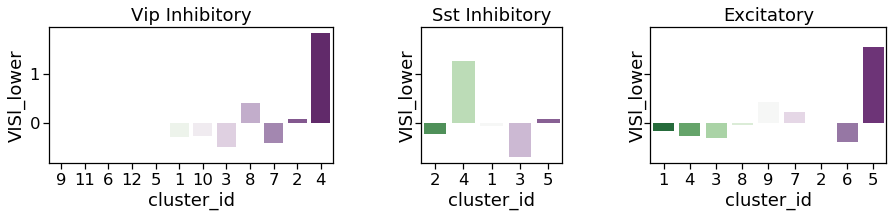

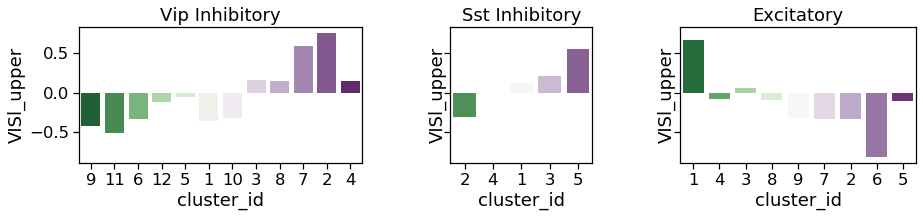

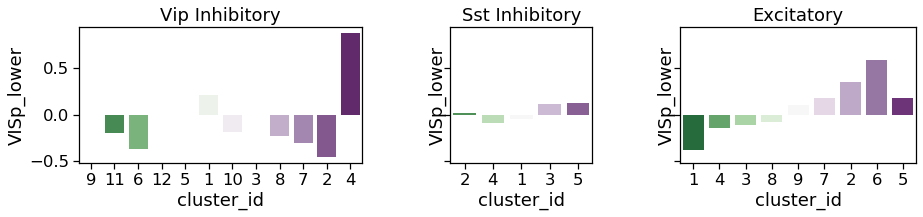

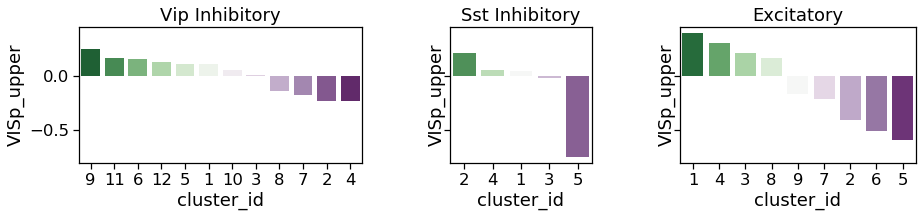

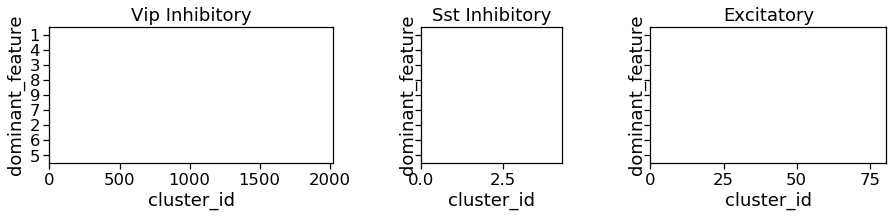

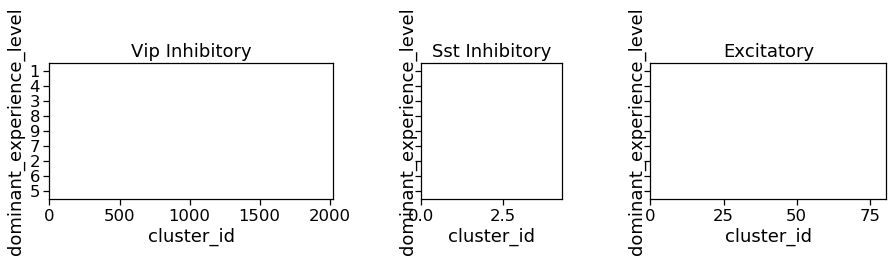

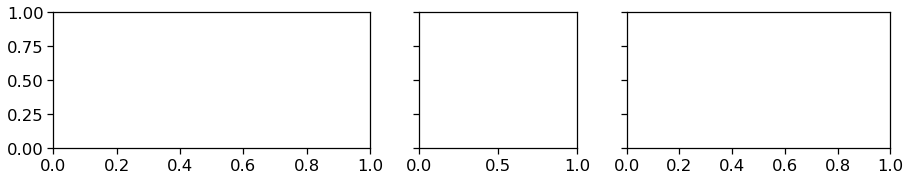

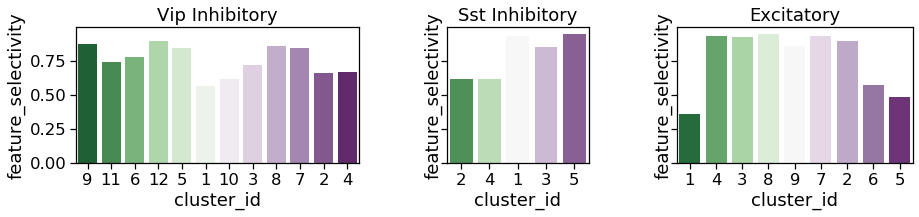

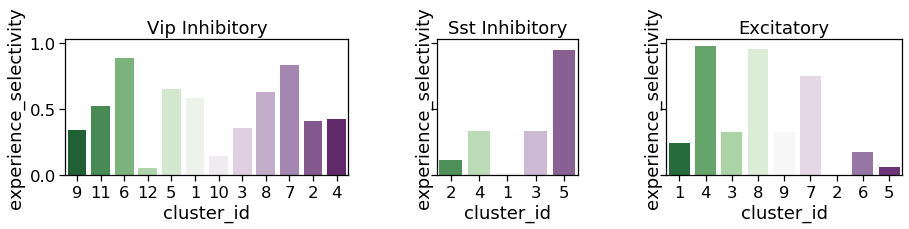

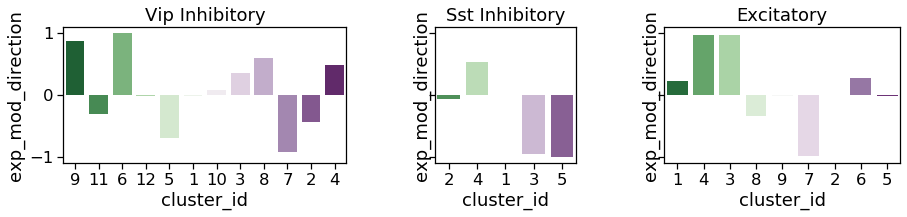

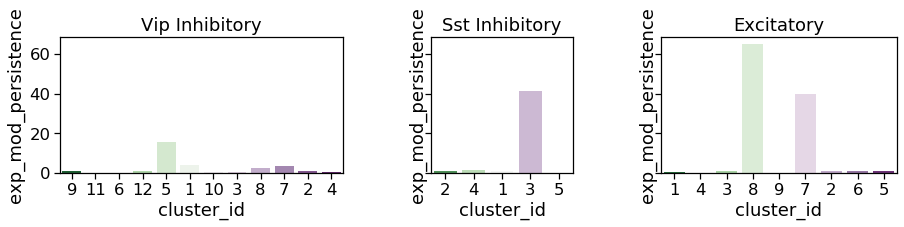

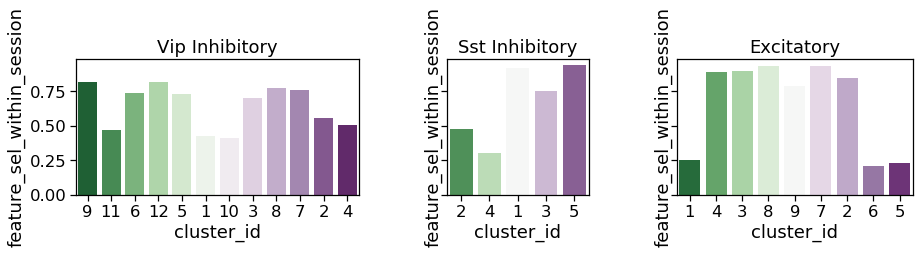

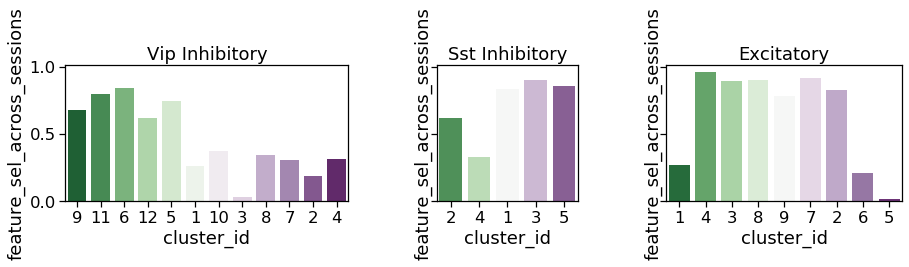

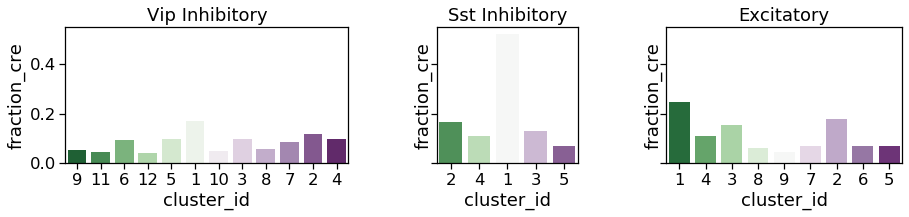

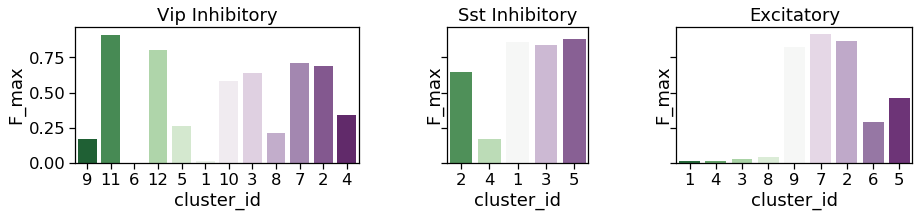

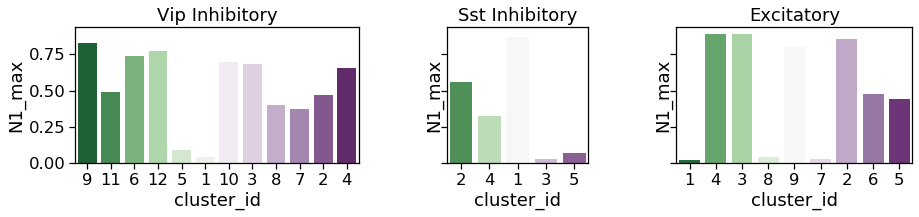

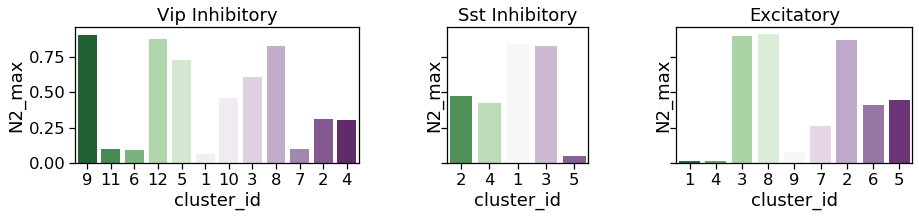

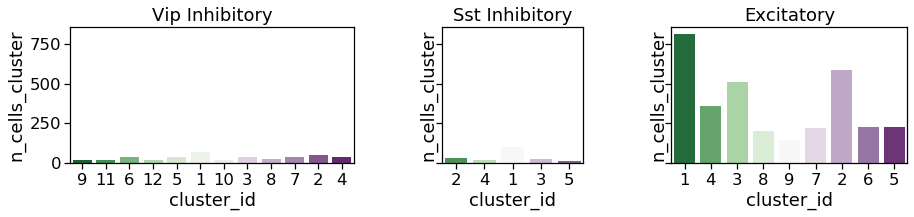

In [93]:
cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, location='VISp_upper', metric='relative_to_random')  
n_clusters = [n_clusters_cre[cre] for cre in cre_lines]

for metric in cluster_stats.columns[2:]:
    try:
        figsize=(15,2.5)
        fig, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios':n_clusters}, sharey=True)
        for i, cre_line in enumerate(processing.get_cre_lines(cluster_meta)):
            data = cluster_stats[cluster_stats.cre_line==cre_line]
            ax[i] = sns.barplot(data=data, x='cluster_id', order=cluster_order[cre_line], y=metric, 
                                hue='VISp_upper', palette='PRGn', ax=ax[i], dodge=False)
            ax[i].set_title(processing.get_cell_type_for_cre_line(cluster_meta, cre_line))
            ax[i].get_legend().remove()
        plt.subplots_adjust(wspace=0.4)
        utils.save_figure(fig, figsize, save_dir, 'pointplots_VISp_upper_sort', metric)
    except:
        print('problem for', metric)

### relationship of across session switching and Familiar session max to % cells in VISp or VISl

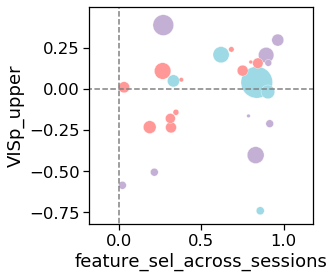

In [94]:
col_x = 'feature_sel_across_sessions'
col_y = 'VISp_upper'

colors = utils.get_cre_line_colors()

figsize=(4,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=cluster_stats, x=col_x, y=col_y, size='fraction_cre', sizes=(0, 1000), 
                    hue='cre_line', hue_order=cre_lines, palette=colors, ax=ax)
ax.axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
ax.axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
ax.get_legend().remove()
plt.axis("equal")
# for i in range(len(cluster_stats[col_x].values)):
#     xy = (cluster_stats[col_x].values[i], cluster_stats[col_y].values[i])
#     color_index = cluster_stats['color_index'].values[i]
#     cluster_id = cluster_stats['cluster_id'].values[i]
#     plt.annotate(cluster_id, xy, color=colors[color_index])
utils.save_figure(fig, figsize, save_dir, 'scatterplots', col_x+'_'+col_y)


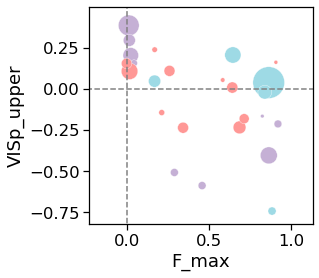

In [95]:
col_x = 'F_max'
col_y = 'VISp_upper'

colors = utils.get_cre_line_colors()

figsize=(4,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=cluster_stats, x=col_x, y=col_y, size='fraction_cre', sizes=(0, 1000), 
                    hue='cre_line', hue_order=cre_lines, palette=colors, ax=ax)
ax.axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
ax.axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
ax.get_legend().remove()
plt.axis("equal")
# for i in range(len(cluster_stats[col_x].values)):
#     xy = (cluster_stats[col_x].values[i], cluster_stats[col_y].values[i])
#     color_index = cluster_stats['color_index'].values[i]
#     cluster_id = cluster_stats['cluster_id'].values[i]
#     plt.annotate(cluster_id, xy, color=colors[color_index])
utils.save_figure(fig, figsize, save_dir, 'scatterplots', col_x+'_'+col_y)


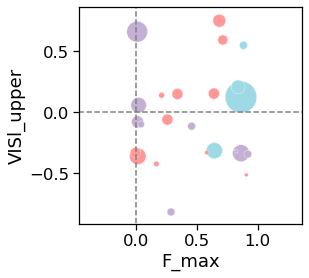

In [96]:
col_x = 'F_max'
col_y = 'VISl_upper'

colors = utils.get_cre_line_colors()

figsize=(4,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=cluster_stats, x=col_x, y=col_y, size='fraction_cre', sizes=(0, 1000), 
                    hue='cre_line', hue_order=cre_lines, palette=colors, ax=ax)
ax.axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
ax.axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
ax.get_legend().remove()
plt.axis("equal")
# for i in range(len(cluster_stats[col_x].values)):
#     xy = (cluster_stats[col_x].values[i], cluster_stats[col_y].values[i])
#     color_index = cluster_stats['color_index'].values[i]
#     cluster_id = cluster_stats['cluster_id'].values[i]
#     plt.annotate(cluster_id, xy, color=colors[color_index])
utils.save_figure(fig, figsize, save_dir, 'scatterplots', col_x+'_'+col_y)


### boxplots of metric values for all cells in each cluster

#### first merge with fraction cells info per cluster

In [97]:
# create location column merging area and depth
cell_count_stats['location'] = cell_count_stats.targeted_structure+'_'+cell_count_stats.layer
# group & unstack to get fraction relative to random for each location as columns
fraction_cells = cell_count_stats[['cre_line', 'cluster_id', 'location', 'relative_to_random']].groupby(['cre_line', 'cluster_id', 'location']).mean().unstack()
# get rid of multi-index column
fraction_cells.columns = fraction_cells.columns.droplevel()
# merge fraction cells per location with other cluster metrics
cell_stats_loc = fraction_cells.reset_index().merge(cell_stats.reset_index(), on=['cre_line', 'cluster_id'])
cell_stats_loc = cell_stats_loc.set_index('cell_specimen_id')

problem for next_highest_conditions


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\matplotlib\cbook\__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\matplotlib\cbook\__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, ax

problem for fraction_cre
problem for F_max
problem for N1_max
problem for N2_max
problem for n_cells_cluster


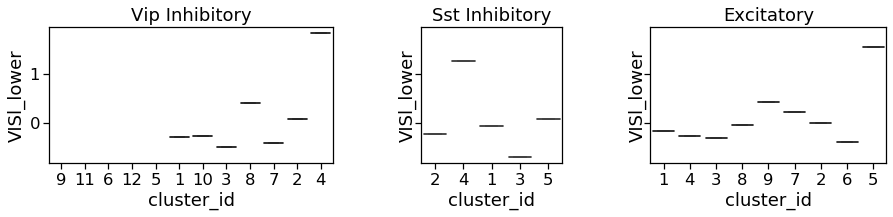

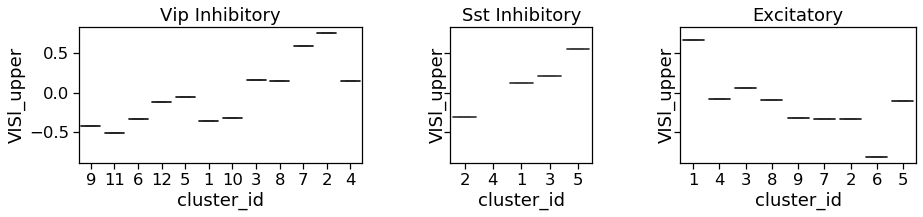

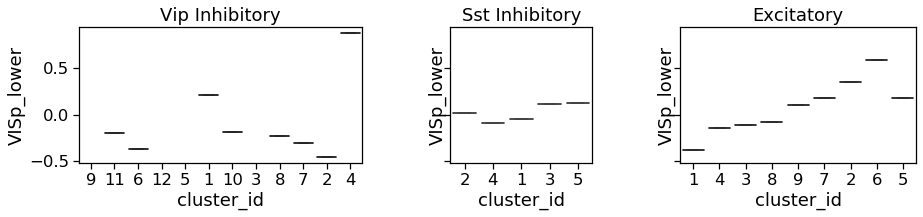

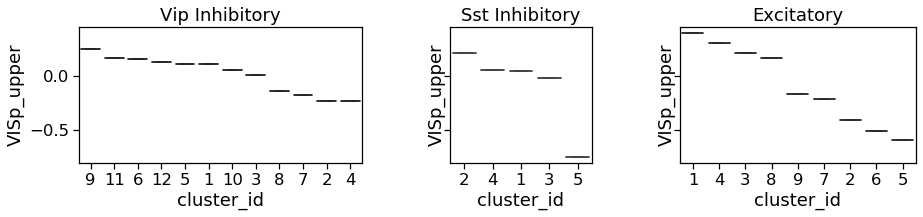

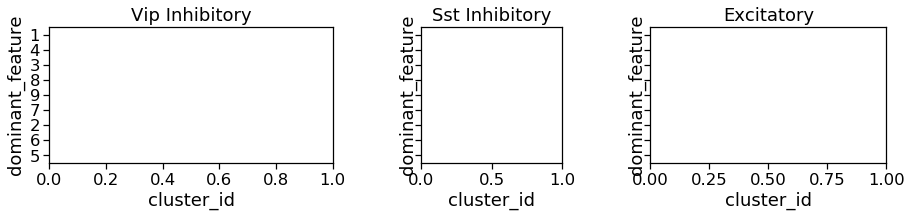

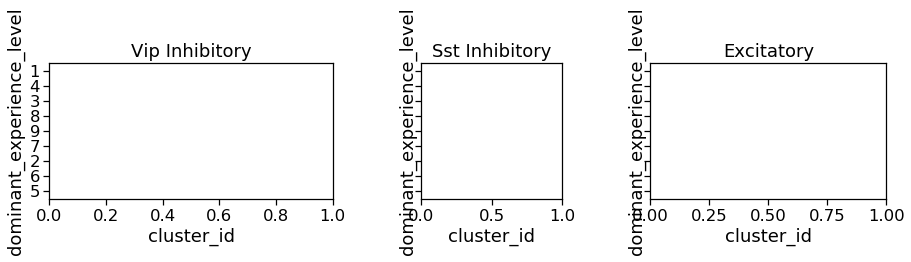

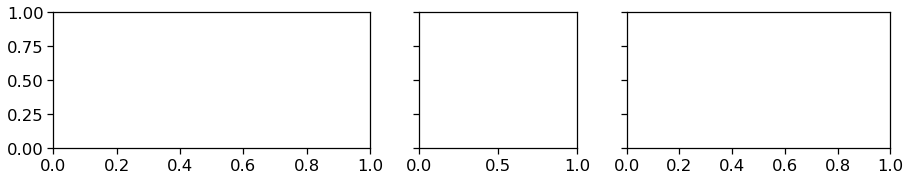

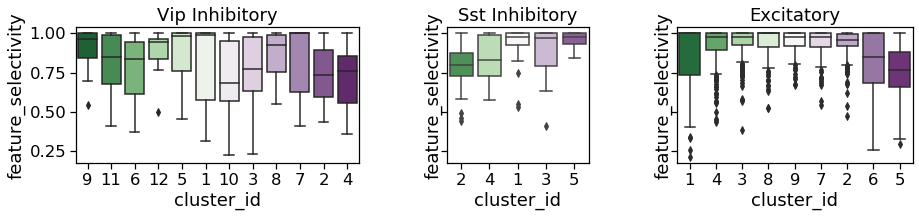

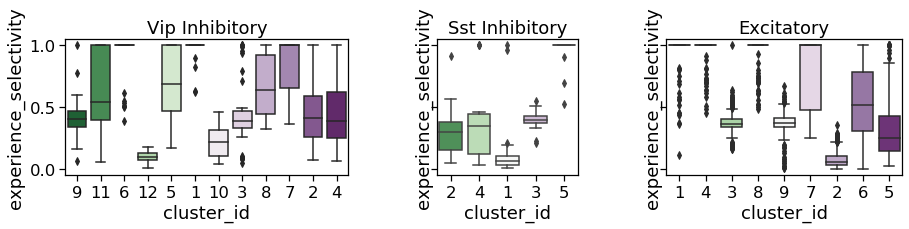

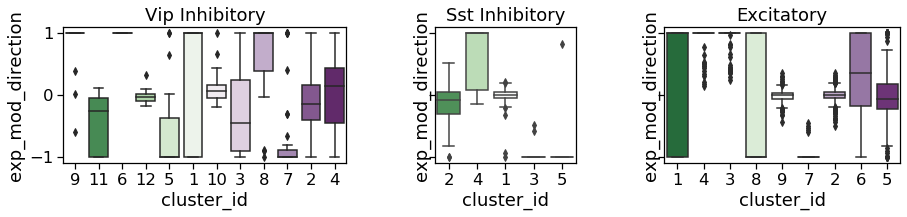

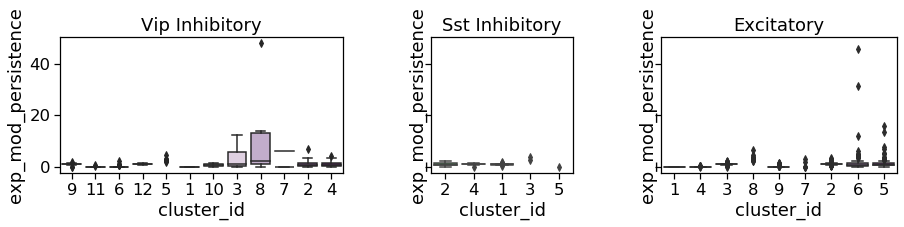

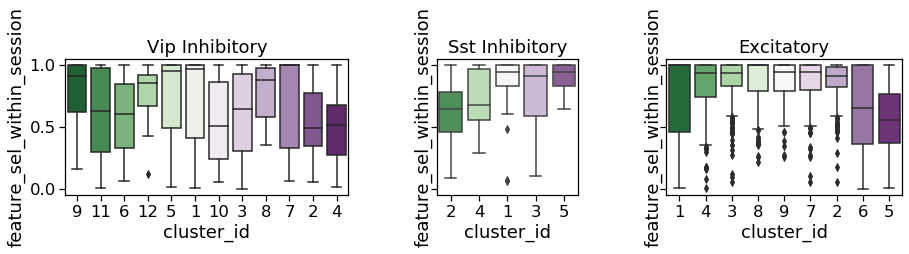

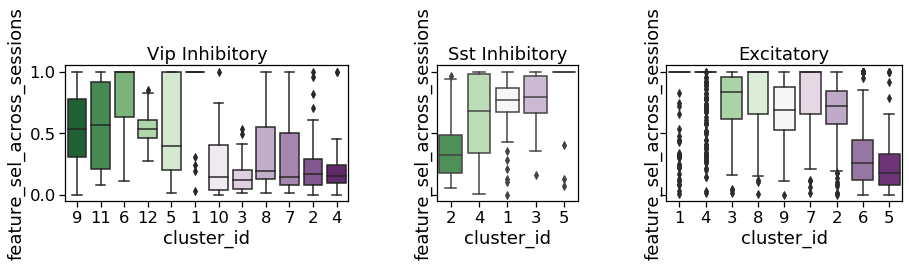

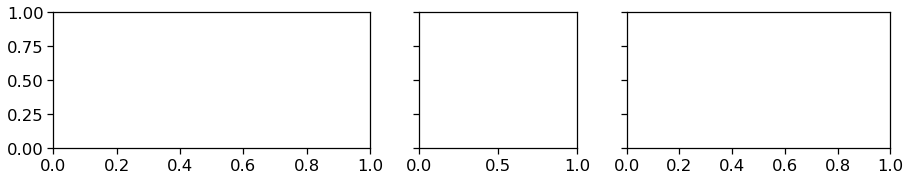

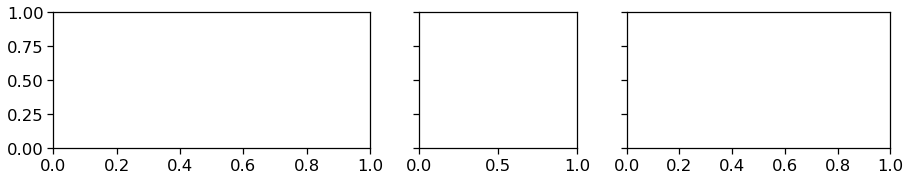

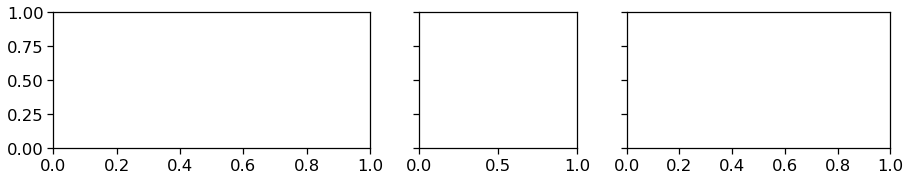

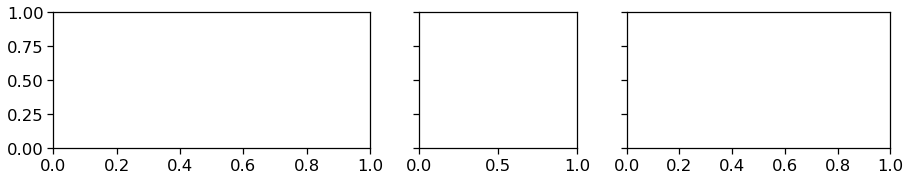

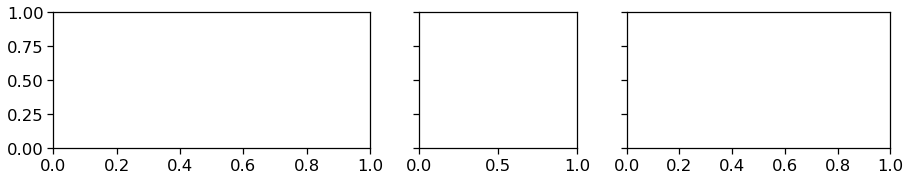

In [98]:
cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, location='VISp_upper', metric='relative_to_random')  
n_clusters = [n_clusters_cre[cre] for cre in cre_lines]

for metric in cluster_stats.columns[2:]:
    try:
        figsize=(15,2.5)
        fig, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios':n_clusters}, sharey=True)
        for i, cre_line in enumerate(processing.get_cre_lines(cluster_meta)):
            data = cell_stats_loc[cell_stats_loc.cre_line==cre_line]
            ax[i] = sns.boxplot(data=data, x='cluster_id', order=cluster_order[cre_line], y=metric, 
                                hue='VISp_upper', palette='PRGn', ax=ax[i], dodge=False)
            ax[i].set_title(processing.get_cell_type_for_cre_line(cluster_meta, cre_line))
            ax[i].get_legend().remove()
        plt.subplots_adjust(wspace=0.4)
        utils.save_figure(fig, figsize, save_dir, 'boxplots_VISp_upper_sort', metric)
    except:
        print('problem for', metric)

### boxplots using V1/LM or upper/lower

In [99]:
cell_count_stats_area = processing.get_cell_count_stats(cluster_meta, conditions_to_groupby = ['targeted_structure'])

In [100]:
# create location column merging area and depth
cell_count_stats_area['location'] = cell_count_stats_area.targeted_structure
# group & unstack to get fraction relative to random for each location as columns
fraction_cells = cell_count_stats_area[['cre_line', 'cluster_id', 'location', 'relative_to_random']].groupby(['cre_line', 'cluster_id', 'location']).mean().unstack()
# get rid of multi-index column
fraction_cells.columns = fraction_cells.columns.droplevel()
# merge fraction cells per location with other cluster metrics
cell_stats_loc = fraction_cells.reset_index().merge(cell_stats.reset_index(), on=['cre_line', 'cluster_id'])
cell_stats_loc = cell_stats_loc.set_index('cell_specimen_id')

problem for VISl_lower
problem for VISl_upper
problem for VISp_lower
problem for VISp_upper
problem for next_highest_conditions


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\matplotlib\cbook\__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\matplotlib\cbook\__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, ax

problem for fraction_cre
problem for F_max
problem for N1_max
problem for N2_max
problem for n_cells_cluster


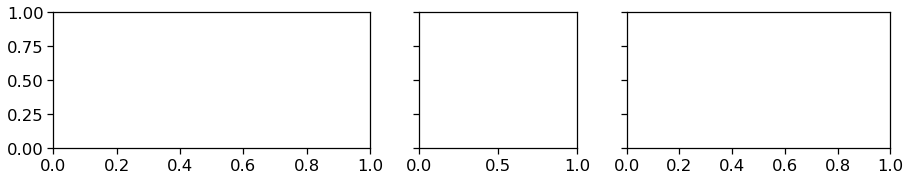

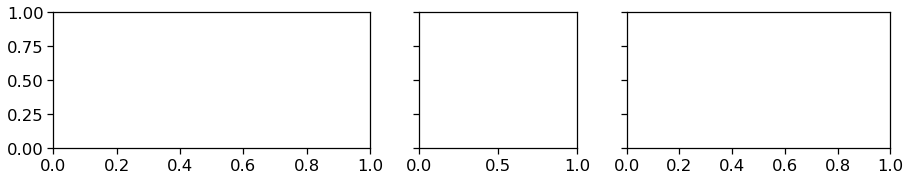

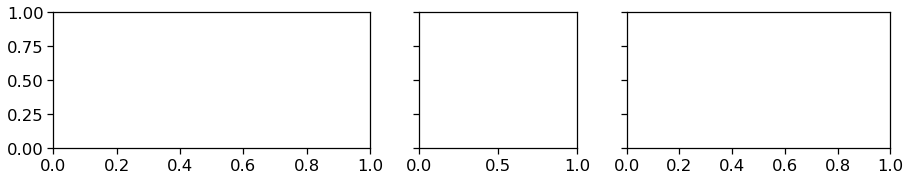

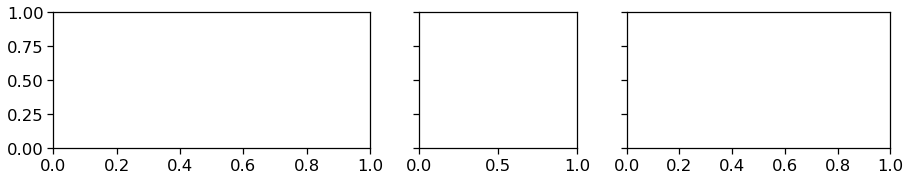

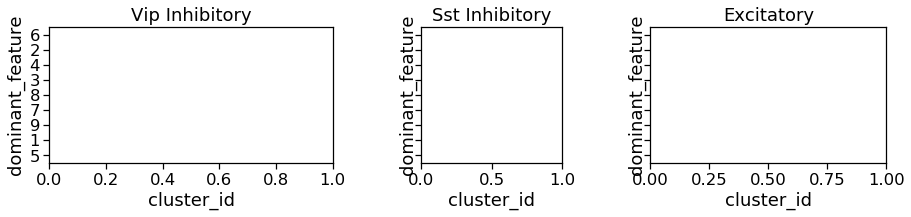

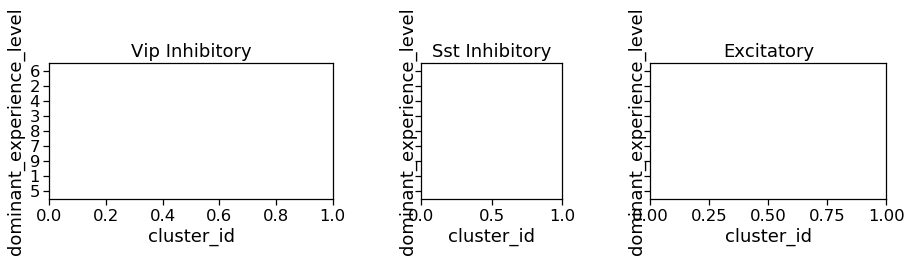

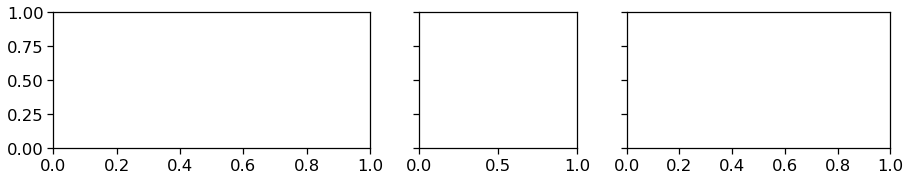

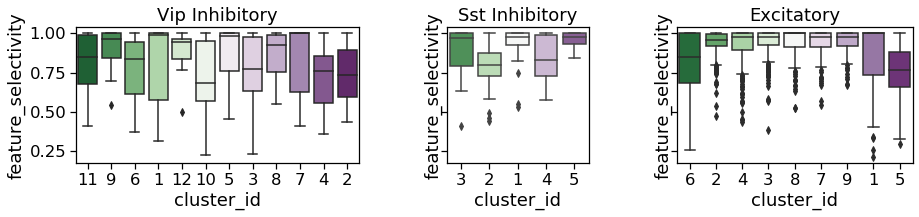

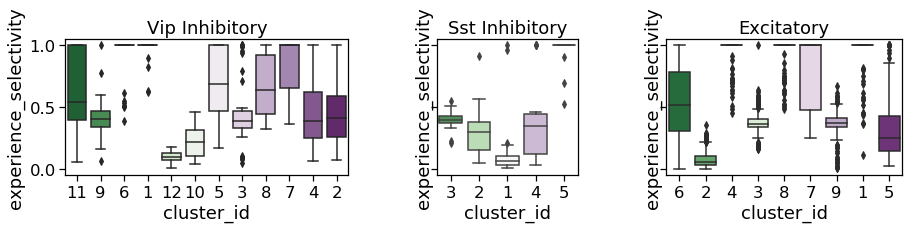

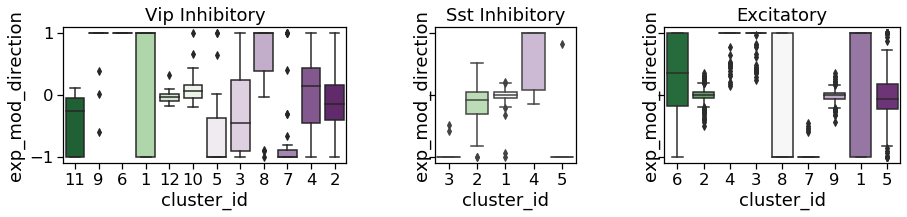

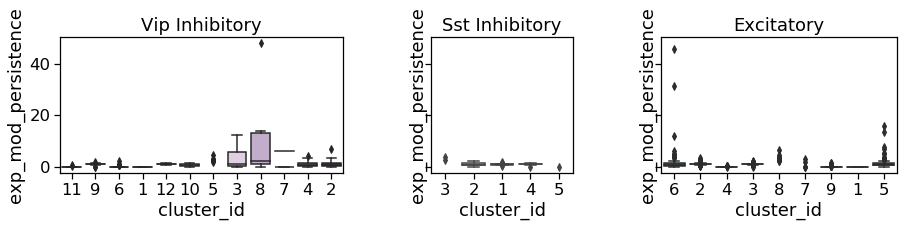

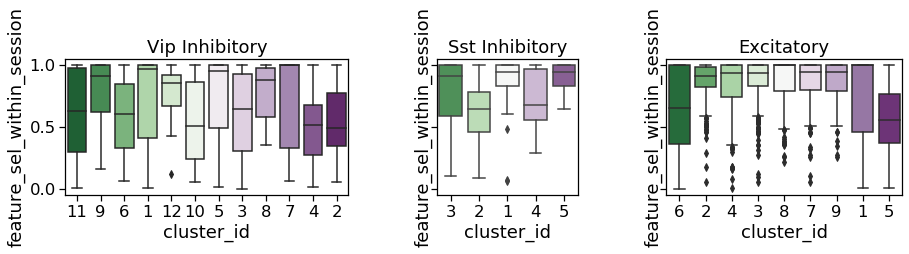

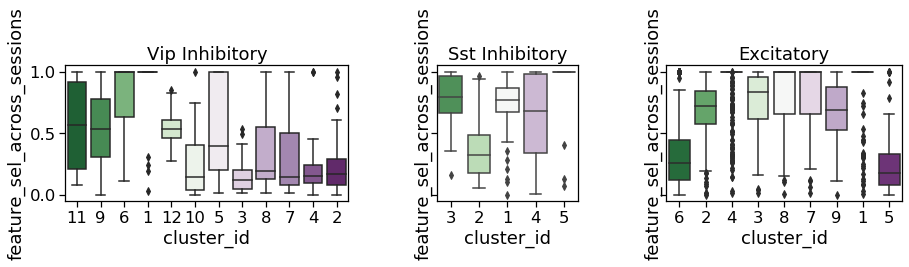

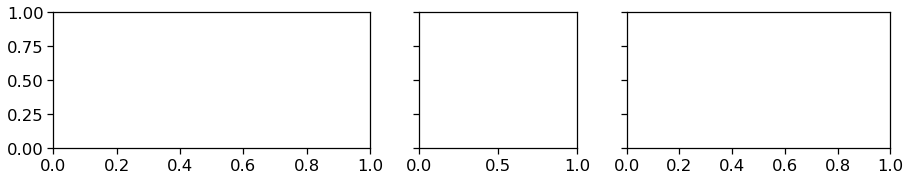

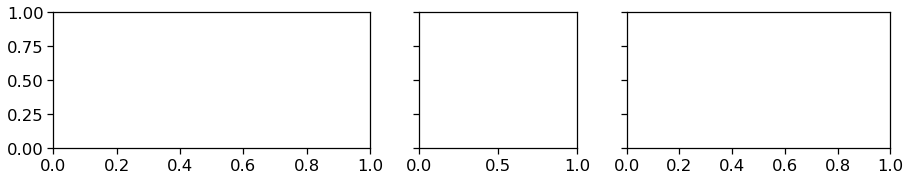

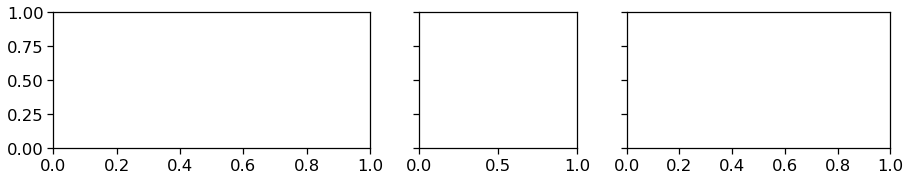

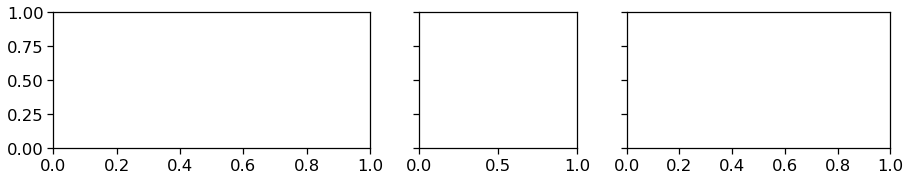

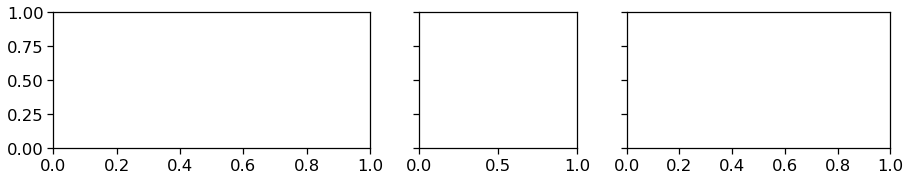

In [101]:
cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats_area, cluster_meta, 
                                                                 location='VISp', metric='relative_to_random')  
n_clusters = [n_clusters_cre[cre] for cre in cre_lines]

for metric in cluster_stats.columns[2:]:
    try:
        figsize=(15,2.5)
        fig, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios':n_clusters}, sharey=True)
        for i, cre_line in enumerate(processing.get_cre_lines(cluster_meta)):
            data = cell_stats_loc[cell_stats_loc.cre_line==cre_line]
            ax[i] = sns.boxplot(data=data, x='cluster_id', order=cluster_order[cre_line], y=metric, 
                                hue='VISp', palette='PRGn', ax=ax[i], dodge=False)
            ax[i].set_title(processing.get_cell_type_for_cre_line(cluster_meta, cre_line))
            ax[i].get_legend().remove()
        plt.subplots_adjust(wspace=0.4)
        utils.save_figure(fig, figsize, save_dir, 'boxplots_VISp_sort', metric)
    except:
        print('problem for', metric)

### layer

In [102]:
cell_count_stats_area = processing.get_cell_count_stats(cluster_meta, conditions_to_groupby = ['layer'])

In [103]:
# create location column merging area and depth
cell_count_stats_area['location'] = cell_count_stats_area.layer
# group & unstack to get fraction relative to random for each location as columns
fraction_cells = cell_count_stats_area[['cre_line', 'cluster_id', 'location', 'relative_to_random']].groupby(['cre_line', 'cluster_id', 'location']).mean().unstack()
# get rid of multi-index column
fraction_cells.columns = fraction_cells.columns.droplevel()
# merge fraction cells per location with other cluster metrics
cell_stats_loc = fraction_cells.reset_index().merge(cell_stats.reset_index(), on=['cre_line', 'cluster_id'])
cell_stats_loc = cell_stats_loc.set_index('cell_specimen_id')

problem for VISl_lower
problem for VISl_upper
problem for VISp_lower
problem for VISp_upper
problem for next_highest_conditions


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\matplotlib\cbook\__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\matplotlib\cbook\__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, ax

problem for fraction_cre
problem for F_max
problem for N1_max
problem for N2_max
problem for n_cells_cluster


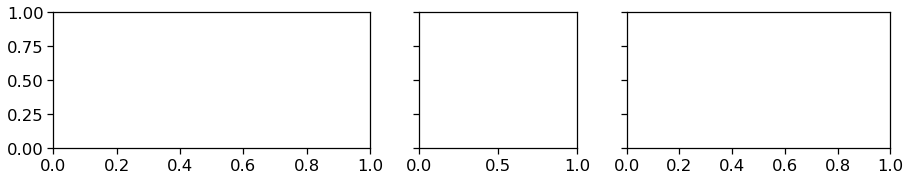

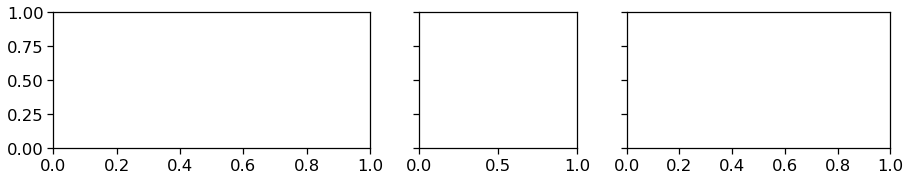

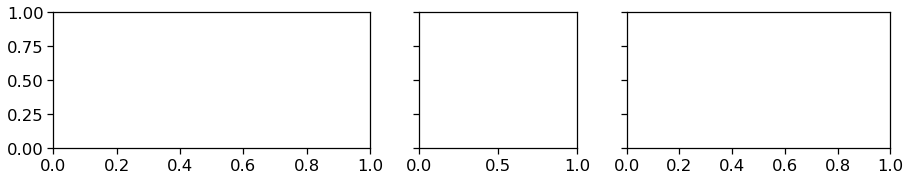

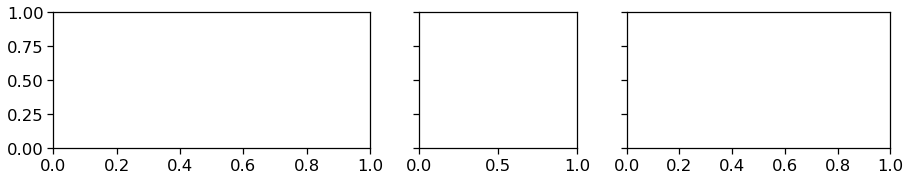

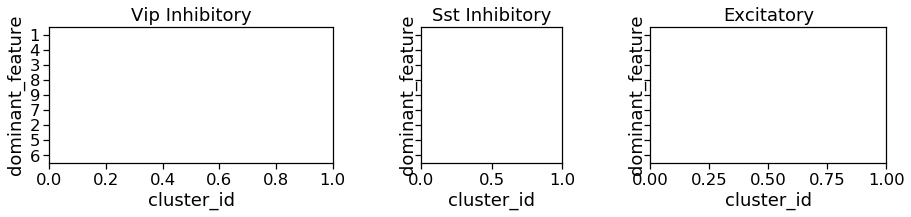

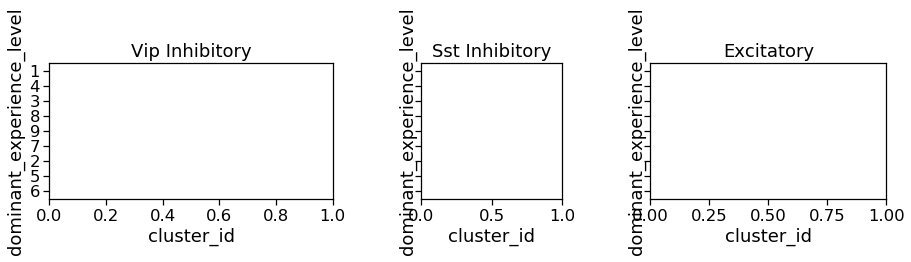

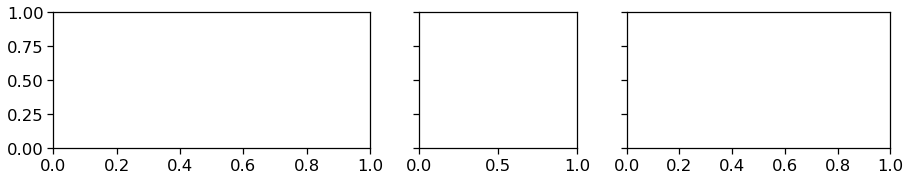

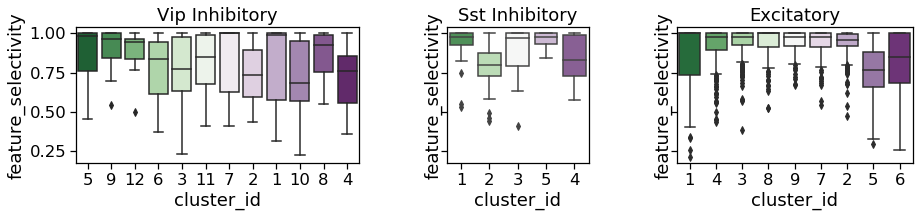

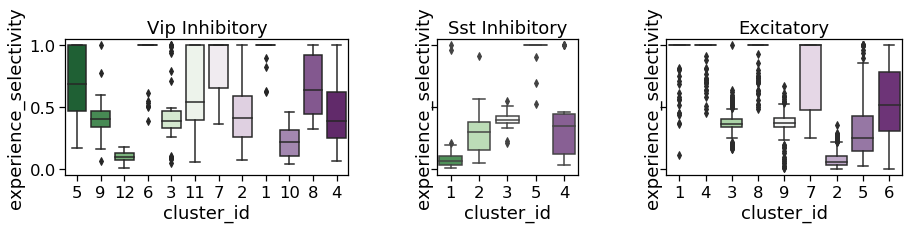

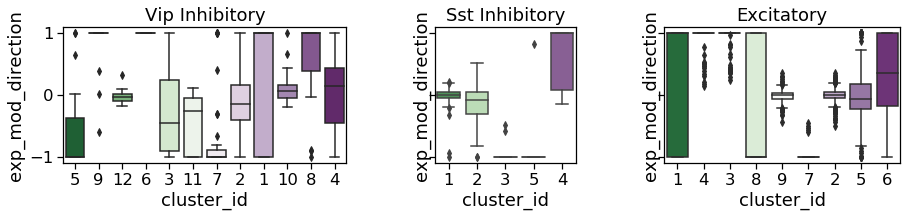

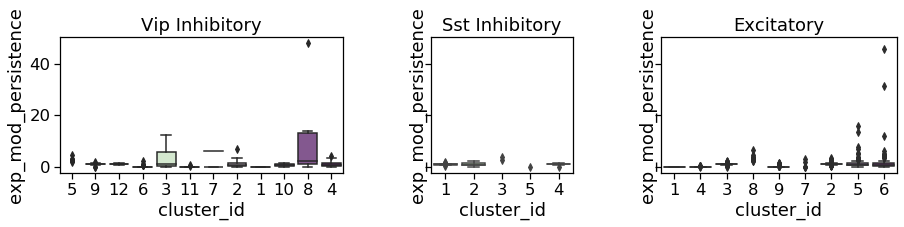

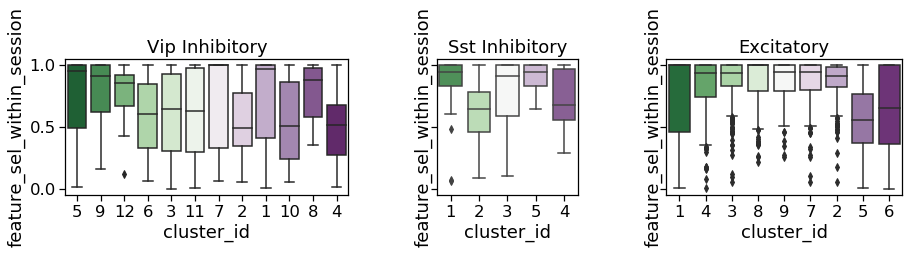

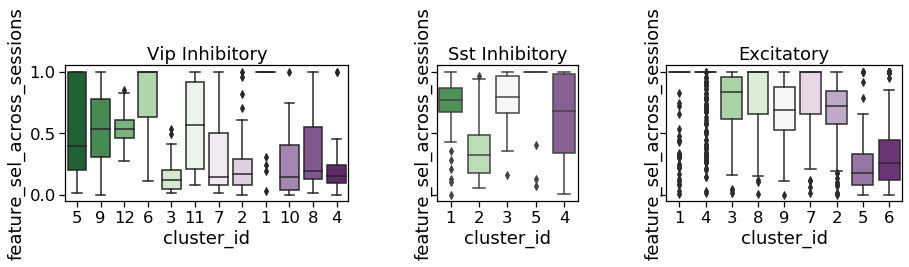

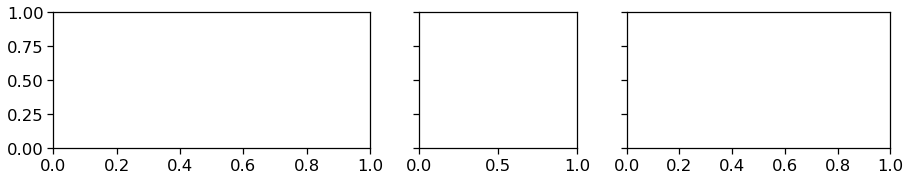

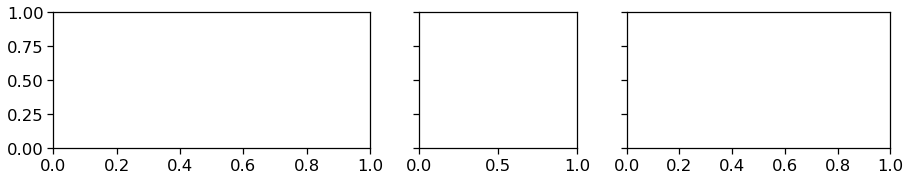

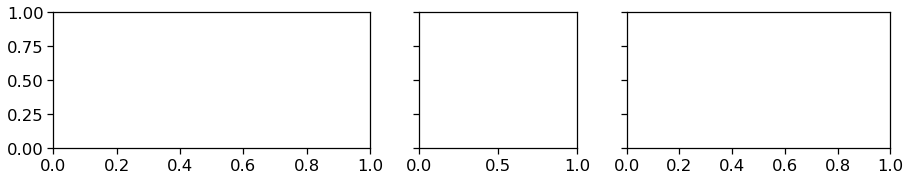

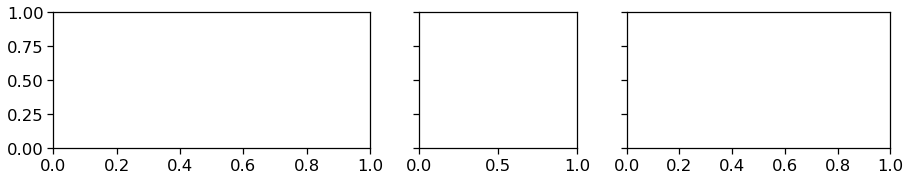

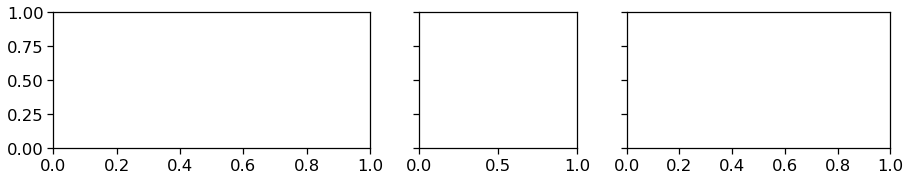

In [104]:
cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats_area, cluster_meta, 
                                                                 location='upper', metric='relative_to_random')  
n_clusters = [n_clusters_cre[cre] for cre in cre_lines]

for metric in cluster_stats.columns[2:]:
    try:
        figsize=(15,2.5)
        fig, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios':n_clusters}, sharey=True)
        for i, cre_line in enumerate(processing.get_cre_lines(cluster_meta)):
            data = cell_stats_loc[cell_stats_loc.cre_line==cre_line]
            ax[i] = sns.boxplot(data=data, x='cluster_id', order=cluster_order[cre_line], y=metric, 
                                hue='upper', palette='PRGn', ax=ax[i], dodge=False)
            ax[i].set_title(processing.get_cell_type_for_cre_line(cluster_meta, cre_line))
            ax[i].get_legend().remove()
        plt.subplots_adjust(wspace=0.4)
        utils.save_figure(fig, figsize, save_dir, 'boxplots_upper_sort', metric)
    except:
        print('problem for', metric)

## Summary plots experimentation

### plot experience mod values for cluster average

9
5
9


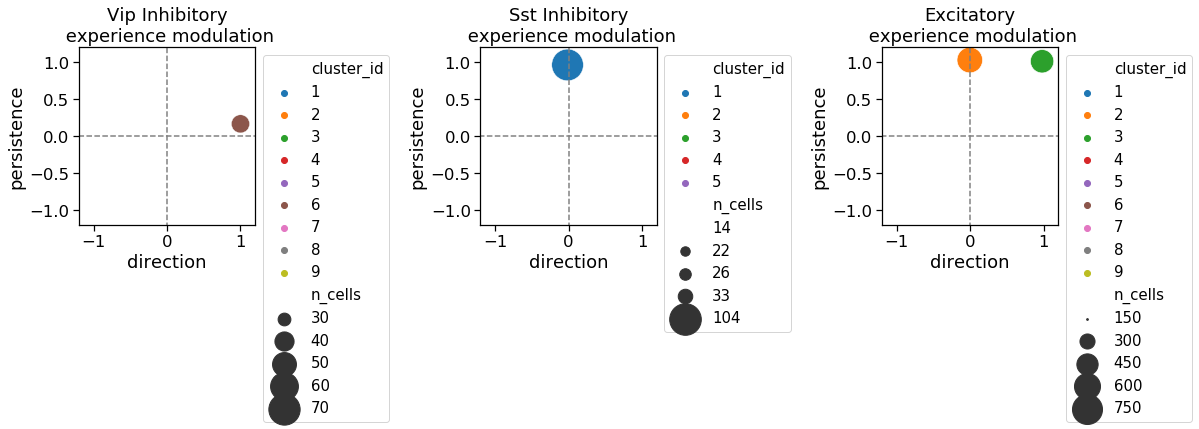

In [105]:
figsize = (17,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    print(n_clusters)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i])
    ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
    ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n experience modulation')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('persistence')
    ax[i].set_xlim(-1.2,1.2)
    ax[i].set_ylim(-1.2,1.2)
fig.tight_layout()
# utils.save_figure(fig, figsize, base_dir, folder, 'experience_modulation_avg_across_cells_in_cluster')

### cells and clusters together 

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


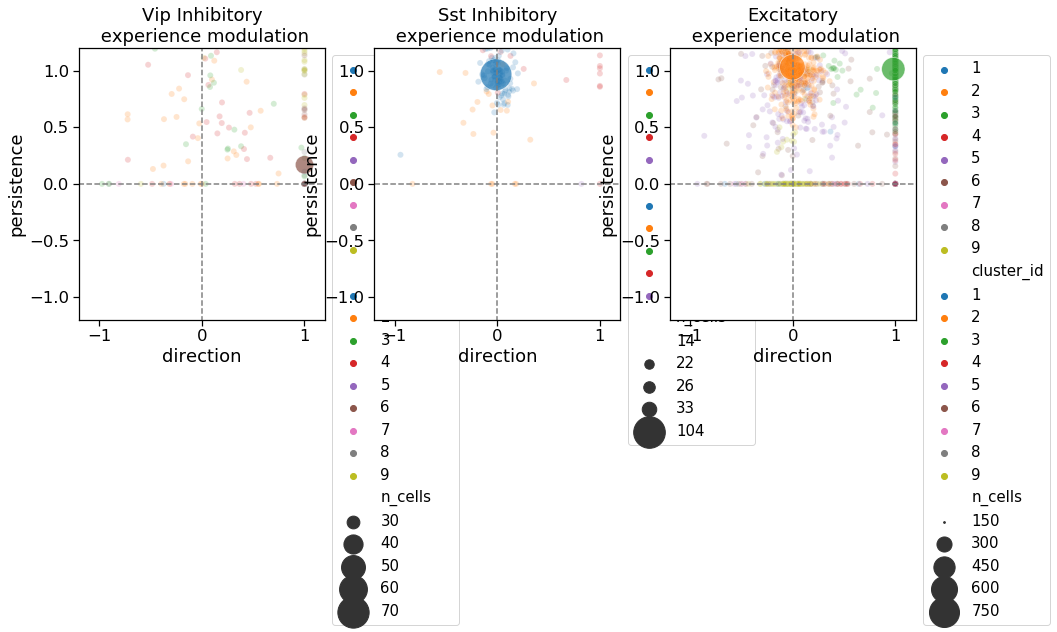

In [106]:
figsize = (15,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = cell_stats[cell_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', alpha=0.2,
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], ax=ax[i])
    
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i], alpha=0.7)
    
    ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
    ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n experience modulation')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('persistence')
    ax[i].set_xlim(-1.2,1.2)
    ax[i].set_ylim(-1.2,1.2)
fig.tight_layout()
# utils.save_figure(fig, figsize, base_dir, folder, 'experience_modulation_across_cells_and_clusters')

### feature selectivity within and across sesions

In [107]:
# figsize = (15,5)
# fig, ax = plt.subplots(1,3, figsize=figsize)
# for i, cre_line in enumerate(cre_lines):
#     data = cell_stats[cell_stats.cre_line==cre_line]
#     data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
#     cluster_order = np.sort(data.cluster_id.unique())
#     n_clusters = len(cluster_order)
#     ax[i] = sns.scatterplot(data=data, x='feature_sel_within_session', y='feature_sel_across_sessions', alpha=0.2,
#                             hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], ax=ax[i])
    
#     data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
#     data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
#     cluster_order = np.sort(data.cluster_id.unique())
#     n_clusters = len(cluster_order)
#     ax[i] = sns.scatterplot(data=data, x='feature_sel_within_session', y='feature_sel_across_sessions', 
#                             hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
#                             size='n_cells', sizes=(0, 1000), ax=ax[i], alpha=0.7)
    
# #     ax[i].axvline(x=0, ymin=0, ymax=1, linestyle='--', color='gray')
# #     ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
#     ax[i].set_title(cell_types[cre_line]+'\n feature selectivity')
#     ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
#     ax[i].set_xlabel('within session')
#     ax[i].set_ylabel('across sessions')
#     ax[i].set_xlim(-0.1,1.1)
#     ax[i].set_ylim(-0.1,1.1)
# fig.tight_layout()
# # utils.save_figure(fig, figsize, base_dir, folder, 'feature_selectivity_across_cells_and_clusters')

### feature selectivity across sessions vs. experience selectivity 

* cell switching is indicated by low feature_sel_across_sessions and high experience selectivity


9
5
9


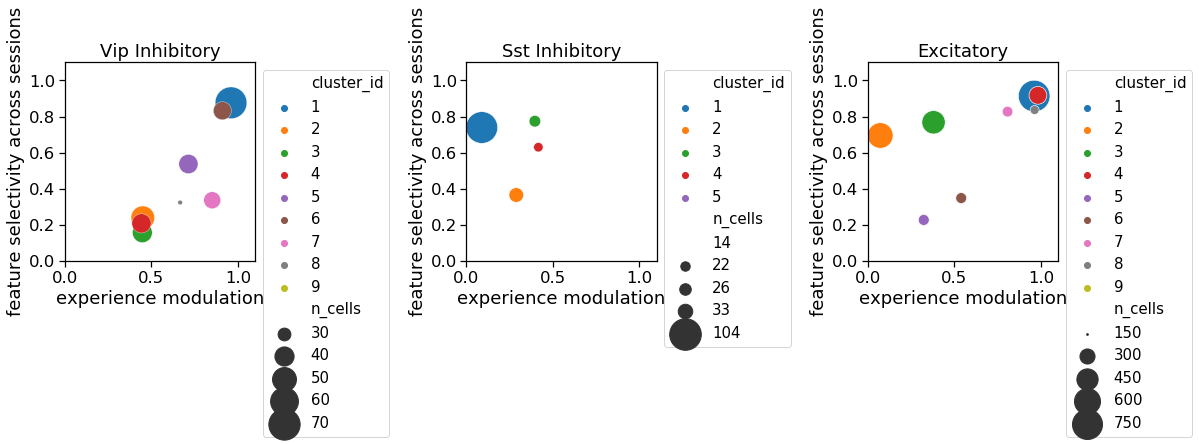

In [108]:
figsize = (17,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    print(n_clusters)
    ax[i] = sns.scatterplot(data=data, x='experience_selectivity', y='feature_sel_across_sessions', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i])
#     ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
#     ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line])
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('experience modulation')
    ax[i].set_ylabel('feature selectivity across sessions')
    ax[i].set_xlim(0, 1.1)
    ax[i].set_ylim(0, 1.1)
fig.tight_layout()
# utils.save_figure(fig, figsize, base_dir, folder, 'feature_sel_exp_mod_avg_across_cells_in_cluster')

### summarize

In [109]:
n_clusters_per_cre = cell_stats.groupby(['cre_line']).count().rename(columns={'cluster_id':'n_cells_total'})[['n_cells_total']]
n_clusters_per_feature = cell_stats.groupby(['cre_line', 'dominant_feature']).count().rename(columns={'cluster_id':'n_cells'})[['n_cells']]
n_clusters_per_feature = n_clusters_per_feature.reset_index().merge(n_clusters_per_cre, on='cre_line')
n_clusters_per_feature['fraction_cells'] = n_clusters_per_feature['n_cells']/n_clusters_per_feature['n_cells_total']

[Text(0, 0, 'all-images'),
 Text(0, 0, 'omissions'),
 Text(0, 0, 'behavioral'),
 Text(0, 0, 'task')]

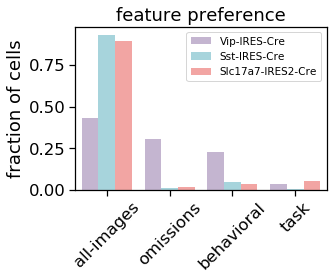

In [110]:
colors = utils.get_cre_line_colors()[::-1]

figsize=(4.5,3)
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=n_clusters_per_feature, x='dominant_feature', y='fraction_cells', hue='cre_line',
             palette=colors, order=features, hue_order=cre_lines, ax=ax)
ax.legend(fontsize='xx-small', title='', loc='upper right')
ax.set_ylabel('fraction of cells')
ax.set_xlabel('')
ax.set_title('feature preference')
ax.set_xticklabels(features, rotation=45)

In [111]:
n_clusters_per_cre = cell_stats.groupby(['cre_line']).count().rename(columns={'cluster_id':'n_cells_total'})[['n_cells_total']]
n_clusters_per_feature = cell_stats.groupby(['cre_line', 'dominant_experience_level']).count().rename(columns={'cluster_id':'n_cells'})[['n_cells']]
n_clusters_per_feature = n_clusters_per_feature.reset_index().merge(n_clusters_per_cre, on='cre_line')
n_clusters_per_feature['fraction_cells'] = n_clusters_per_feature['n_cells']/n_clusters_per_feature['n_cells_total']

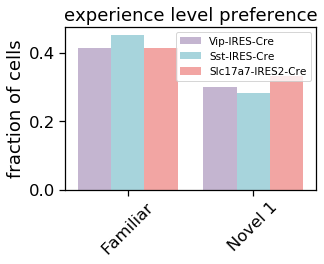

In [112]:
colors = utils.get_cre_line_colors()[::-1]
experience_levels = np.sort(cluster_meta.experience_level.unique())

figsize=(4.5,3)
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=n_clusters_per_feature, x='dominant_experience_level', y='fraction_cells', hue='cre_line',
             palette=colors, order=experience_levels, hue_order=cre_lines, ax=ax)
ax.legend(fontsize='xx-small', title='', loc='upper right')
ax.set_ylabel('fraction of cells')
ax.set_xlabel('')
ax.set_title('experience level preference')
ax.set_xticklabels(experience_levels, rotation=45);

### repeat but per cluster instead of across cells 

In [113]:
cell_stats = cluster_meta.copy()
for i, cell_specimen_id in enumerate(cell_stats.index.values):
    # get dropout scores per cell 
    cell_dropouts = dropouts[dropouts.cell_specimen_id==cell_specimen_id].groupby('experience_level').mean()[features]
    # get preferred regressor and experience level and save
    dominant_feature = cell_dropouts.stack().idxmax()[1]
    dominant_experience_level = cell_dropouts.stack().idxmax()[0]
    cell_stats.loc[cell_specimen_id, 'dominant_feature'] = dominant_feature
    cell_stats.loc[cell_specimen_id, 'dominant_experience_level'] = dominant_experience_level
    # get selectivity for feature & experience level 
    # feature selectivity is ratio of largest and next largest dropouts for the dominant experience level
    order = np.argsort(cell_dropouts.loc[dominant_experience_level])
    values = cell_dropouts.loc[dominant_experience_level].values[order[::-1]]
    feature_selectivity = (values[0]-(np.mean(values[1:])))/(values[0]+(np.mean(values[1:])))
    # experience selectivity is ratio of largest and next largest dropouts for the dominant feature
    order = np.argsort(cell_dropouts[dominant_feature])
    values = cell_dropouts[dominant_feature].values[order[::-1]]
    experience_selectivity = (values[0]-(np.mean(values[1:])))/(values[0]+(np.mean(values[1:])))
    cell_stats.loc[cell_specimen_id, 'feature_selectivity'] = feature_selectivity
    cell_stats.loc[cell_specimen_id, 'experience_selectivity'] = experience_selectivity

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [114]:
cluster_stats.keys()

Index(['cre_line', 'cluster_id', 'VISl_lower', 'VISl_upper', 'VISp_lower',
       'VISp_upper', 'dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'feature_selectivity',
       'experience_selectivity', 'exp_mod_direction', 'exp_mod_persistence',
       'feature_sel_within_session', 'feature_sel_across_sessions',
       'fraction_cre', 'F_max', 'N1_max', 'N2_max', 'n_cells_cluster'],
      dtype='object')

(0, 1)

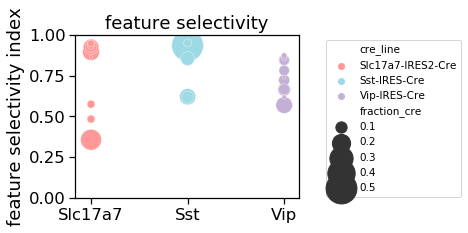

In [115]:
min_size = 0
max_size = 1000

colors = utils.get_cre_line_colors()

figsize=(4,3)
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(data=cluster_stats, x='cre_line', y='feature_selectivity', hue='cre_line',
             palette=colors, hue_order=cell_types, size='fraction_cre', sizes=(min_size, max_size), ax=ax)
ax.legend(fontsize='xx-small', title='', bbox_to_anchor=(1.1,1))
ax.set_ylabel('feature selectivity index')
ax.set_xlabel('')
ax.set_title('feature selectivity')
# ax.set_xticklabels([processing.get_cell_type_for_cre_line(cluster_meta, cre_line) for cre_line in cre_lines], rotation=45)
ax.set_xticklabels([cre_line.split('-')[0] for cre_line in cre_lines[::-1]], rotation=0)

ax.set_ylim(0,1)

(0, 1)

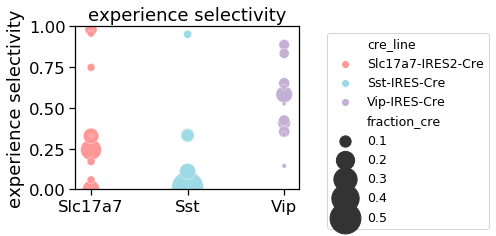

In [116]:
max_size = 0
max_size = 1000

figsize=(4,3)
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(data=cluster_stats, x='cre_line', y='experience_selectivity', hue='cre_line', 
             palette=colors, hue_order=cell_types, size='fraction_cre', sizes=(min_size, max_size), ax=ax)
ax.legend(fontsize='x-small', title='', bbox_to_anchor=(1.1,1))
ax.set_ylabel('experience selectivity')
ax.set_xlabel('')
ax.set_title('experience selectivity')
# ax.set_xticklabels([processing.get_cell_type_for_cre_line(cluster_meta, cre_line) for cre_line in cre_lines], rotation=45)
ax.set_xticklabels([cre_line.split('-')[0] for cre_line in cre_lines[::-1]], rotation=0)

ax.set_ylim(0,1)

### details stuff / validation

#### count number of cells in different areas & depths

In [117]:
make_frequency_table(cluster_meta, groupby_columns = ['cre_line', 'targeted_structure'], normalize=False)

NameError: name 'make_frequency_table' is not defined

There are way more cells in VISp than VISl

In [ ]:
make_frequency_table(cluster_meta, groupby_columns = ['cre_line', 'layer'], normalize=False)

There are way more cells in lower layers for Sst and upper layers for Vip

In [ ]:
make_frequency_table(cluster_meta, groupby_columns = ['cre_line', 'binned_depth'], normalize=False)

Numbers get pretty small for inhibitory lines when looking at depths in 4 bins

#### get frequency across areas & layer for one cre line

In [ ]:
cre_line = cre_lines[1]
print(cre_line)

In [ ]:
make_frequency_table(cluster_meta[cluster_meta.cre_line==cre_line], 
                     groupby_columns = ['targeted_structure', 'layer'], normalize=False)

In [ ]:
cre_meta = cluster_meta[cluster_meta.cre_line==cre_line]
make_frequency_table(cre_meta, groupby_columns = ['targeted_structure', 'layer'], normalize=True)

### plot frequency by area and depth

In [ ]:
cre_line = cre_lines[1]
cre_meta = cluster_meta[cluster_meta.cre_line==cre_line]
frequency = make_frequency_table(cre_meta, groupby_columns = ['targeted_structure', 'layer'], normalize=True)

Rows add up to 1

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))
ax = sns.heatmap(frequency, vmin=0, cmap='magma', ax=ax, cbar_kws={'shrink':0.8, 'label':'fraction of cells'})
ax.set_ylim((0, 4))
# ax.set_yticklabels(frequency.index, rotation=0, horizontalalignment='center')
ax.set_xlim(-0.5, len(frequency.columns)+0.5)
ax.set_ylabel('')
ax.set_title(cell_types[cre_line])
fig.tight_layout()

### normalizing to cluster size doesnt make sense

In [ ]:
stats_df = cre_meta[['cluster_id', 'binned_depth']]
frequency_table= stats_df.groupby('cluster_id')['binned_depth'].value_counts(normalize=False).unstack()
frequency_table= frequency_table.fillna(0)
frequency_table

In [ ]:
stats_df = cre_meta[['cluster_id', 'binned_depth']]
frequency_table= stats_df.groupby('cluster_id')['binned_depth'].value_counts(normalize=True).unstack()
frequency_table= frequency_table.fillna(0)
frequency_table

In [ ]:
sns.heatmap(frequency_table)

### plots with individual cells per cluster

In [ ]:
# get dropouts for some specific condition and add to cre meta for plotting
condition = ('all-images', 'Familiar')
metric_data = df[condition]
metric_data = metric_data.rename(columns={('all-images', 'Novel 1'):'metric'})
metric_data = pd.DataFrame(metric_data, columns=['metric'])
metric_meta = cre_meta.merge(metric_data, on='cell_specimen_id')

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=metric_meta, y='imaging_depth', x='metric', hue='cluster_id', palette='magma_r', ax=ax)
ax.legend(bbox_to_anchor=(1,1), )

In [ ]:
fig, ax = plt.subplots()
ax = sns.pointplot(data=metric_meta, y='binned_depth', x='metric', hue='cluster_id', 
                   orient='h', join=False, dodge=0.5, palette='magma_r', ax=ax)
ax.legend(bbox_to_anchor=(1,1), )

In [ ]:
# get dropouts for some specific condition and add to cre meta for plotting
condition = ('behavioral', 'Novel 1')
metric_data = df[condition]
metric_data = metric_data.rename(columns={('all-images', 'Novel 1'):'metric'})
metric_data = pd.DataFrame(metric_data, columns=['metric'])
metric_meta = cre_meta.merge(metric_data, on='cell_specimen_id')

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=metric_meta, y='imaging_depth', x='metric', hue='cluster_id', palette='magma_r', ax=ax)
ax.legend(bbox_to_anchor=(1,1), )

In [ ]:
area_df = pd.DataFrame(frequency_table_area.unstack(), columns=['fraction']).reset_index()
area_df = area_df.groupby(['cluster_id', 'targeted_structure']).mean().unstack()
area_df.columns = area_df.columns.droplevel()
fig, ax = plt.subplots(figsize=(6,2))
ax = sns.heatmap(area_df.T, vmin=0, cmap='magma', ax=ax, cbar_kws={'shrink':0.8, 'label':'fraction cells\nper area'})
ax.set_ylim((0, 2))
ax.set_yticklabels(area_df.T.index, rotation=0, horizontalalignment='center')
ax.set_ylabel('')
ax.set_xlim(-0.5, len(area_df)+0.5)
fig.tight_layout()

In [ ]:
depth_df = pd.DataFrame(frequency_table_depth.unstack(), columns=['fraction']).reset_index()
depth_df = depth_df.groupby(['cluster_id', 'binned_depth']).mean().unstack()
depth_df.columns = depth_df.columns.droplevel()

fig, ax = plt.subplots(figsize=(6,2.5))
ax = sns.heatmap(depth_df.T, vmin=0, cmap='magma', ax=ax, cbar_kws={'shrink':0.8, 'label':'fraction cells\nper depth'})
ax.set_ylim((0, 4))
ax.set_yticklabels(depth_df.T.index, rotation=0, horizontalalignment='center')
ax.set_xlim(-0.5, len(depth_df)+0.5)
ax.set_ylabel('')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots
sns.barplot(data=area_df, x='cluster_id', y='fraction', hue='targeted_structure')

In [ ]:
frequency_table_depth